In [ ]:
# Install torchaudio
!pip install torchaudio==0.9.1 -q
import librosa
import torchaudio
from torchaudio import transforms

In [1]:
import datetime
import os

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from torch.utils.data import Dataset, DataLoader, IterableDataset

import numpy as np
import pandas as pd

from collections import Counter, defaultdict, OrderedDict

from sklearn.metrics import precision_score, f1_score, recall_score, classification_report, confusion_matrix, make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Consider ragas that have at least 10 samples.
RAGAM_MIN_COUNT = 10

In [4]:
data = pd.read_pickle('/content/drive/MyDrive/mp3_mfcc.pkl')

In [ ]:
data = pd.read_json('/content/drive/MyDrive/song_lyric_map.json')
adata = pd.read_json('/content/drive/MyDrive/mp3_data_genres.json')

In [ ]:
AUD_PATH = '/content/drive/MyDrive/Annamayya'
data['exists'] = data.apply(lambda x:os.path.exists(os.path.join(AUD_PATH,x['MP3 File'])),axis=1)
data = data[data.exists]

In [ ]:
def get_offset(adata, id):
  l = adata[adata.Samputi==id]['Offset'].tolist()
  return 60 if len(l) == 0 else l[0]
data['Offset'] = data.apply(lambda x:get_offset(adata, x.Samputi), axis=1)

data['Offset'].fillna(60,inplace=True)

In [ ]:
all_samples = data.Ragam.value_counts().index
low_samples = all_samples[data.Ragam.value_counts()<RAGAM_MIN_COUNT]
# Drop these rows.
for s in low_samples:
  data = data[data.Ragam!=s]

In [ ]:
le = LabelEncoder()
le.fit_transform(data['Ragam'])
data['RagamCode'] = data.apply(lambda x:le.transform([x.Ragam])[0],axis=1)
n_labels = len(data['RagamCode'].unique())

In [ ]:
data['Ragam'].value_counts()

లలిత            98
సాళంగనాట        94
సామంతం          89
బౌళి            70
శంకరాభరణం       68
శ్రీరాగం        65
రామక్రియ        61
ముఖారి          55
పాడి            50
ఆహిరి           45
దేసాళం          40
దేవగాంధారి      35
శుద్ధవసంతం      33
భూపాలం          32
దేసాక్షి        29
గుండుక్రియ      28
భైరవి           27
నాట             25
వరాళి           22
ధన్నాసి         20
మలహరి           20
కాంబోది         19
మాళవి           18
మాళవిగౌళ        18
గుజ్జరి         15
కన్నడగౌళ        15
గౌళ             14
బౌళిరామక్రియ    13
సాళంగం          11
నాదరామక్రియ     11
Name: Ragam, dtype: int64

In [ ]:
print(f'Unique Ragas : {n_labels}')

Unique Ragas : 30


ఆహిరి : [0]
కన్నడగౌళ : [1]
కాంబోది : [2]
గుండుక్రియ : [3]
గుజ్జరి : [4]
గౌళ : [5]
దేవగాంధారి : [6]
దేసాక్షి : [7]
దేసాళం : [8]
ధన్నాసి : [9]
నాట : [10]
నాదరామక్రియ : [11]
పాడి : [12]
బౌళి : [13]
బౌళిరామక్రియ : [14]
భూపాలం : [15]
భైరవి : [16]
మలహరి : [17]
మాళవి : [18]
మాళవిగౌళ : [19]
ముఖారి : [20]
రామక్రియ : [21]
లలిత : [22]
వరాళి : [23]
శంకరాభరణం : [24]
శుద్ధవసంతం : [25]
శ్రీరాగం : [26]
సామంతం : [27]
సాళంగం : [28]
సాళంగనాట : [29]


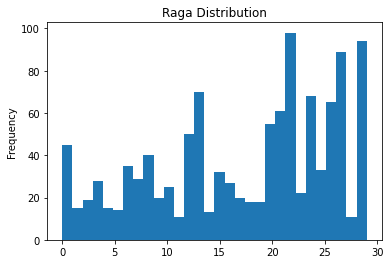

In [ ]:
for c in le.classes_: print(f'{c} : {le.transform([c])}')
data['RagamCode'].plot.hist(bins=n_labels)
plt.title('Raga Distribution')
plt.show()

In [5]:
def get_devices():
    if torch.cuda.is_available():
        gpu = torch.device("cuda")
    else:
        gpu = torch.device("cpu")
    cpu = torch.device("cpu")
    return gpu, cpu
gpu, cpu = get_devices()

In [6]:
def get_loss_function(balance_classes, labels, run_on, loss_fcn=nn.CrossEntropyLoss):
    if balance_classes:
        class_wts = compute_class_weight(class_weight = 'balanced',
                                         classes = np.unique(labels),
                                         y = labels
                                         )
        print(f'Class Weights : {class_wts}')
        # convert class weights to tensor
        weights = torch.tensor(class_wts, dtype=torch.float)
        weights = weights.to(run_on)
        # loss function
        loss_fcn = loss_fcn(weight=weights)
    else:
        loss_fcn = loss_fcn()
    return loss_fcn

In [7]:
def update_best_result(best_scores, valid_loss, train_labels, train_predictions, test_labels, test_predictions,
                       model=None, model_file_name=f'saved_weights_Fold_0.pt'):
    if valid_loss < best_scores['valid_loss']:
        best_scores['valid_loss'] = valid_loss
        best_scores['train_predictions'] = train_predictions
        best_scores['test_predictions'] = test_predictions
        best_scores['train_labels'] = train_labels
        best_scores['test_labels'] = test_labels
        if model:
            torch.save(model.state_dict(), model_file_name)
    return best_scores

In [8]:
def update_results_dict(results, train_labels, train_predictions, test_labels, test_predictions, s='micro'):
    results['train_precision'].append(precision_score(train_labels, train_predictions,average=s))
    results['train_recall'].append(recall_score(train_labels, train_predictions,average=s))
    results['train_f1'].append(f1_score(train_labels, train_predictions,average=s))
    results['validation_precision'].append(precision_score(test_labels, test_predictions,average=s))
    results['validation_recall'].append(recall_score(test_labels, test_predictions,average=s))
    results['validation_f1'].append(f1_score(test_labels, test_predictions,average=s))
    return results

In [9]:
def run_model(model, dataset, loss_fcn, optimizer, is_training, run_on, clip_at=None, lstm_model=False, report_at=20):
  predict = lambda model, data, hidden: model(data, hidden) if hidden else model(data)
  hid = lambda model, data, run_on, lstm_model: model.init_hidden(data.shape[0], run_on) if lstm_model else None
  if is_training:
      model.train()
  else:
      model.eval()
  total_loss, total_accuracy, model_predictions, model_labels, aud_data = 0, 0, [], [], None
  for step, batch in enumerate(dataset):
      if step % report_at == 0 and not step == 0:
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataset)))
      # push the batch to gpu
      batch = [r.to(run_on) for r in batch]        
      aud_data, labels = batch
      h = hid(model, aud_data, run_on, lstm_model)
      if is_training:
          for o in optimizer: o.zero_grad()
          model.zero_grad()
          predictions = predict(model, aud_data, h)
      else:
          with torch.no_grad():
            predictions = predict(model, aud_data, h)
      # compute the loss between actual and predicted values
      loss = loss_fcn(predictions, labels)
      predictions = predictions.detach().cpu().numpy()
      total_loss = total_loss + loss.item()
      if is_training:
          loss.backward()  # backward pass to calculate the gradients
          if clip_at: torch.nn.utils.clip_grad_norm_(model.parameters(), clip_at)
          # update parameters
          for o in optimizer: o.step()
      # append the model predictions
      model_predictions.append(predictions)
      model_labels.append(labels.detach().cpu().numpy())
      del batch
  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataset)
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  model_predictions = np.concatenate(model_predictions, axis=0)
  model_labels = np.concatenate(model_labels, axis=0)
  # returns the loss and predictions
  model_predictions = np.argmax(model_predictions, axis=1)
  return avg_loss, model_predictions, model_labels, model

In [10]:
def plot_results(results, model_name):
    fig = plt.figure(figsize=[20, 10])
    epochs = len(results[0]['train_precision'])
    x_label = f'{len(results)} Fold and {epochs} Epochs'
    legend_labels = ['Train', 'Val']

    def subplot_routine(key1, key2, title, loss=False):
        plt.plot([x for k in results for x in results[k][key1]])
        plt.plot([x for k in results for x in results[k][key2]])
        plt.grid()
        plt.xlabel(x_label)
        plt.legend([f'{x} {title}' for x in legend_labels])
        if not loss:
            plt.ylim([0, 1.1])
        else:
            b, t = plt.ylim()
            plt.ylim(np.floor(b), np.ceil(t))

    gs = GridSpec(2, 3, figure=fig)
    plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
    subplot_routine('train_losses', 'validation_losses', 'Losses', True)
    plt.subplot(2, 3, 4)
    subplot_routine('train_precision', 'validation_precision', 'Precision')
    plt.subplot(2, 3, 5)
    subplot_routine('train_recall', 'validation_recall', 'Recall')
    plt.subplot(2, 3, 6)
    subplot_routine('train_f1', 'validation_f1', 'F1')
    plt.suptitle(f'Metrics for {model_name}')
    plt.tight_layout()
    plt.show()

In [11]:
class AbsDataset(IterableDataset):
  def __init__(self):
    super().__init__()
  
  def get_data_loader(self, batch_size=32, random_seed=42):
    g = torch.Generator()
    g.manual_seed(random_seed)
    return DataLoader(self, batch_size=batch_size, generator=g)

In [12]:
def train_model(data, prepare_data_hnd, gpu, **kwargs):
  torch.manual_seed(42)
  start_time = datetime.datetime.now()

  n_labels = kwargs['n_labels']
  title = kwargs['title']
  report = kwargs['report'] if 'report' in kwargs else 20
  lstm = kwargs['lstm'] if 'lstm' in kwargs else False
  lr = kwargs['lr'] if 'lr' in kwargs else 1e-4
  clip_at = kwargs['clip_at'] if 'clip_at' in kwargs else None
  k_folds = kwargs['k_folds'] if 'k_folds' in kwargs else 5
  balance_classes = kwargs['balance_classes'] if 'balance_classes' in kwargs else True
  dropout = kwargs['dropout'] if 'dropout' in kwargs else 0.25
  plot = kwargs['plot'] if 'plot' in kwargs else True
  epochs = kwargs['epochs'] if 'epochs' in kwargs else 5
  mdlargs = kwargs['mdlargs'] if 'mdlargs' in kwargs else {}
  feature = kwargs['feature'] if 'feature' in kwargs else ['mfcc_mean']
  target = kwargs['target'] if 'target' in kwargs else 'RagamCode'
  
  k_fold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
  results = {x: {} for x in range(k_folds)}
  labels = data[target]
  ovl_best_scores = {'valid_loss': float('inf'),
                    'train_predictions': [],
                    'test_predictions': [],
                    'train_labels': [],
                    'test_labels': []
                    }
  for fold, (train_ids, test_ids) in enumerate(k_fold.split(data[feature], data[target])):
    print(f'FOLD {fold + 1} \n Data Sizes (Train/Test) : {len(train_ids)}/{len(test_ids)}')
    fold_start = datetime.datetime.now()
    # empty lists to store training and validation loss of each epoch
    train_losses, valid_losses = [], []
    best_scores = {'valid_loss': float('inf'),
                    'train_predictions': [],
                    'test_predictions': [],
                    'train_labels': [],
                    'test_labels': []
                    }
    # for each epoch
    results[fold] = {
        'train_f1': [],
        'validation_f1': [],
        'train_precision': [],
        'validation_precision': [],
        'train_recall': [],
        'validation_recall': []
    }
    train_data, test_data, train_lbls, test_lbls = prepare_data_hnd(data, train_ids, test_ids)
    model = kwargs['model'](n_labels,dropout=dropout,**mdlargs)
    model.to(gpu)
    loss_fcn = get_loss_function(balance_classes, data[target].tolist(), gpu, nn.CrossEntropyLoss)
    # define the optimizer
    optimizer = [torch.optim.Adam(model.parameters(), lr=lr)]
    lr_schedulers = [ReduceLROnPlateau(optimizer[0], patience=3,factor=0.1,threshold=1e-9,mode='min'),
                     ExponentialLR(optimizer[0],gamma=0.9)]
    for epoch in range(epochs):
        e_start = datetime.datetime.now()
        # train model
        train_loss, train_predictions, train_labels, model = run_model(model, train_data.get_data_loader(batch_size=32),
                                                                        loss_fcn, optimizer, run_on=gpu,
                                                                        is_training=True, clip_at=clip_at,
                                                                       lstm_model=lstm, report_at=report)
        # evaluate model
        valid_loss, test_predictions, test_labels, model = run_model(model, test_data.get_data_loader(batch_size=32),
                                                                      loss_fcn, optimizer, run_on=gpu,
                                                                      is_training=False, clip_at=clip_at,
                                                                     lstm_model=lstm, report_at=report)
        for lr_scheduler in lr_schedulers:
            lr_scheduler.step(valid_loss)
        torch.cuda.empty_cache()
        # save the best model
        best_scores = update_best_result(best_scores,
                                          valid_loss,
                                          train_labels, train_predictions,
                                          test_labels, test_predictions,
                                          model=model,
                                          model_file_name=f'saved_weights_Fold_{fold}.pt')
        ovl_best_scores = update_best_result(ovl_best_scores,
                                          valid_loss,
                                          train_labels, train_predictions,
                                          test_labels, test_predictions)
        # append training and validation loss
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        results[fold] = update_results_dict(results[fold],
                                            train_labels, train_predictions,
                                            test_labels, test_predictions)
        e_end = datetime.datetime.now()
        print(f'Epoch {epoch+1}/{epochs} : Training Loss: {train_loss:.3f} / Validation Loss : {valid_loss:.3f} [Time Taken : {(e_end - e_start).total_seconds()} seconds]')
    print('*** Confusion Matrix - Training ***')
    print(confusion_matrix(best_scores['train_labels'],best_scores['train_predictions']))
    print('*** Confusion Matrix - Validation ***')
    print(confusion_matrix(best_scores['test_labels'],best_scores['test_predictions']))
    results[fold]['train_losses'] = train_losses
    results[fold]['validation_losses'] = valid_losses
    print(f'Fold {fold+1} : {(datetime.datetime.now() - fold_start).total_seconds()} seconds')
  end_time = datetime.datetime.now()
  print(f'Overall Time : {(end_time - start_time).total_seconds()} seconds')
  print('*** Confusion Matrix - Training ***')
  print(confusion_matrix(ovl_best_scores['train_labels'],ovl_best_scores['train_predictions']))
  print('*** Confusion Matrix - Validation ***')
  print(confusion_matrix(ovl_best_scores['test_labels'],ovl_best_scores['test_predictions']))
  if plot: plot_results(results, title)
  return results

In [47]:
def results_to_df(results):
    p = pd.DataFrame(results[0])
    for i in range(1, len(results)):
        p = pd.concat([p, pd.DataFrame(results[i])], axis=0)
    p.sort_values(by='validation_f1', ascending=False, inplace=True)
    return p

# OVR Experiment 1 - MFCC Feed Forward

In [ ]:
FREQ = 16000
DURATION = 120
mfcc_tx = transforms.MFCC(FREQ, n_mfcc=40)
def get_mfcc(x, aud_path, mfcc_tx):
  aud_path = os.path.join(aud_path, x['MP3 File'])
  i = torchaudio.info(aud_path)
  waveform, sample_rate = torchaudio.load(aud_path, 
                                          frame_offset=int(x['Offset']*i.sample_rate), 
                                          num_frames= DURATION*i.sample_rate)
  waveform = librosa.to_mono(waveform)
  resampler = transforms.Resample(sample_rate, FREQ)
  if len(waveform) > 0 :
    waveform = resampler(torch.tensor(waveform))
    mfcc = mfcc_tx(waveform)
  else:
    mfcc = []
  return mfcc
data['mfcc'] = data.apply(lambda x:get_mfcc(x, AUD_PATH, mfcc_tx),axis=1)
data = data[data.apply(lambda x:not isinstance(x['mfcc'],list),axis=1)]

In [14]:
class MfccMatrixDataset(AbsDataset):
    def __init__(self, labels, mfcc_vals):
        super().__init__()
        self.labels = labels
        self.mfcc_vals = mfcc_vals

    def __get__(self,index):
      if self.mfcc_vals[index].shape[1] < 9601:
        self.mfcc_vals[index] = torch.hstack((self.mfcc_vals[index],torch.zeros(40,9601-self.mfcc_vals[index].shape[1])))
      return self.mfcc_vals[index].reshape((1,)+self.mfcc_vals[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['mfcc'].iloc[x] for x in train_ids]
      test_vals = [data['mfcc'].iloc[x] for x in test_ids]
      train_data = MfccMatrixDataset(train_lbls, train_vals)
      test_data = MfccMatrixDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

In [57]:
class MfccRaga(nn.Module):
    def __init__(self, n_labels, dropout=0.25):
        super().__init__()
        self.height = 40
        self.width = 9601
        # Fully connected audio layer with MFCC Matrix 40x9601 (120secs)
        pool_kernel = 2
        kernel = (2,2)
        self.layers1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=kernel, padding='same'),            
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=pool_kernel),
            nn.Conv2d(in_channels=2, out_channels=4, kernel_size=kernel, padding='same'),            
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=pool_kernel),
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=kernel, padding='same'),            
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=pool_kernel),
            nn.Flatten()
        )
        self.final = nn.Linear(48000,n_labels)
        
    def forward(self,x):
        x = self.layers1(x)
        x = self.final(x)
        return x

In [55]:
def ovr_train_model(data, dataset, mdl, title, labels, label_classes, lbl_encoder=None, target='RagamCode', feature='mfcc', lr=5e-3,
                    lstm=False, dropout=0.1, epochs=15, n_folds=2):
  results = {}
  for i in labels:
    # Create new data    
    nsamples = data[data[target]==i].shape[0]
    if lbl_encoder: 
      lbl = lbl_encoder.inverse_transform([i])
      print(f'Training for {lbl} with {nsamples} positive samples')
    else:
      lbl = i
    ndata = pd.DataFrame()
    ndata[target] = data.apply(lambda x:1 if x[target] == i else 0, axis=1)
    ndata[feature] = data[feature]
    results[i] = train_model(ndata, dataset.prepare_data, gpu, 
                                  **{'n_labels' : 2,
                                   'report' : 50,
                                   'lstm' : lstm,
                                   'lr' : lr,
                                   'clip_at' : None,
                                   'k_folds' : n_folds,
                                   'balance_classes' : True,
                                   'dropout' : dropout,
                                   'title' : title,
                                   'plot' : True,
                                   'epochs' : epochs,
                                   'model' : mdl,
                                   'feature' : feature,
                                   'target' : target})
    print(results_to_df(results[i]))
  return results

Training for ['ఆహిరి'] with 45 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 569/570
Class Weights : [ 0.52056673 12.65555556]
Epoch 1/15 : Training Loss: 0.824 / Validation Loss : 0.702 [Time Taken : 1.902059 seconds]
Epoch 2/15 : Training Loss: 0.556 / Validation Loss : 0.689 [Time Taken : 1.911867 seconds]
Epoch 3/15 : Training Loss: 0.451 / Validation Loss : 0.693 [Time Taken : 1.901599 seconds]
Epoch 4/15 : Training Loss: 0.377 / Validation Loss : 0.701 [Time Taken : 1.892322 seconds]
Epoch 5/15 : Training Loss: 0.314 / Validation Loss : 0.754 [Time Taken : 1.894079 seconds]
Epoch 6/15 : Training Loss: 0.262 / Validation Loss : 0.916 [Time Taken : 1.876725 seconds]
Epoch 7/15 : Training Loss: 0.222 / Validation Loss : 1.220 [Time Taken : 1.879426 seconds]
Epoch 8/15 : Training Loss: 0.194 / Validation Loss : 1.583 [Time Taken : 1.879642 seconds]
Epoch 9/15 : Training Loss: 0.173 / Validation Loss : 1.771 [Time Taken : 1.889288 seconds]
Epoch 10/15 : Training Loss: 0.159 / Va

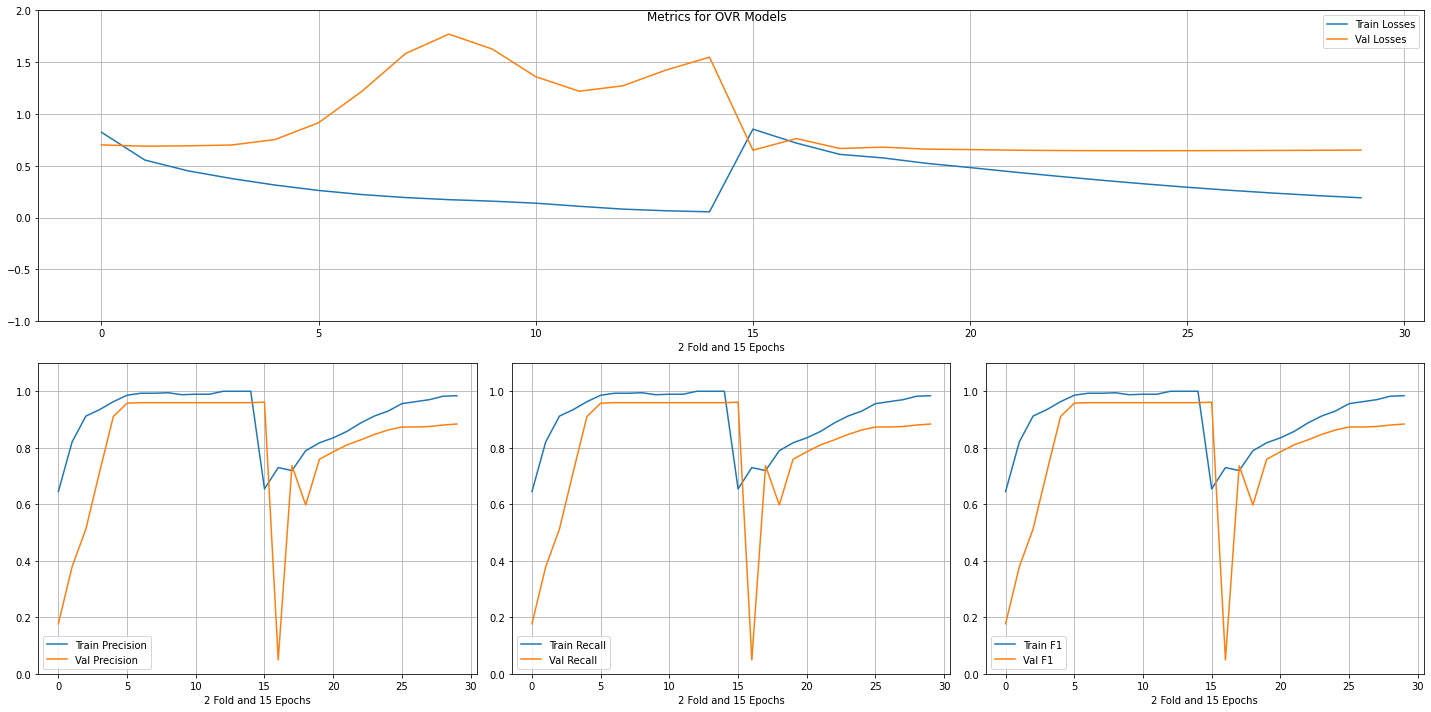

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.654386       0.961336  ...      0.853774           0.650725
12  1.000000       0.959649  ...      0.081868           1.271512
14  1.000000       0.959649  ...      0.055717           1.548482
13  1.000000       0.959649  ...      0.065874           1.424264
6   0.992970       0.959649  ...      0.222348           1.219988
7   0.992970       0.959649  ...      0.193522           1.583239
8   0.994728       0.959649  ...      0.173122           1.771082
9   0.987698       0.959649  ...      0.158594           1.626390
10  0.989455       0.959649  ...      0.139107           1.360022
11  0.989455       0.959649  ...      0.109208           1.219955
5   0.985940       0.957895  ...      0.262181           0.915757
4   0.963093       0.910526  ...      0.313863           0.753835
14  0.984211       0.884007  ...      0.191253           0.651484
13  0.982456       0.880492  ...      0.212257           0.649851
12  0.9701

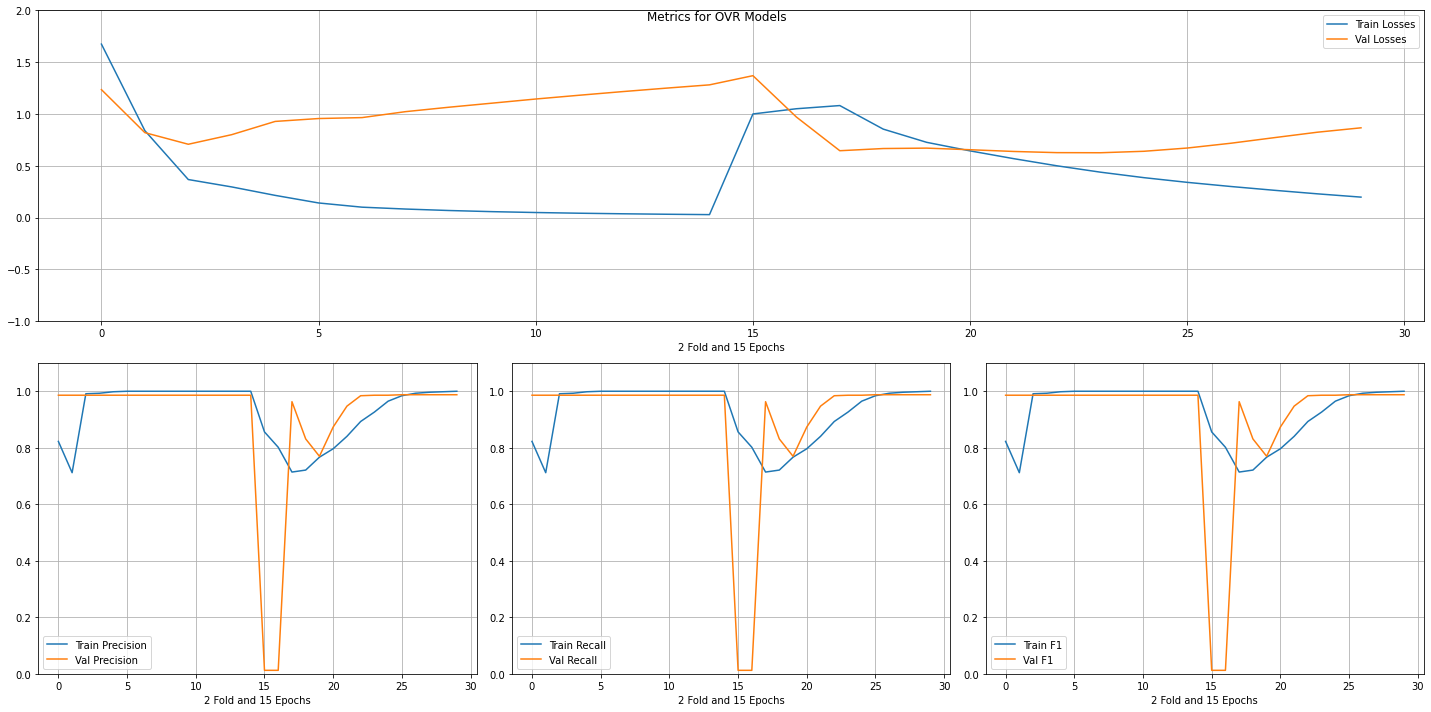

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.987698  ...      0.197648           0.866642
13  0.998246       0.987698  ...      0.229293           0.824407
12  0.996491       0.987698  ...      0.263764           0.771499
11  0.992982       0.987698  ...      0.300339           0.717608
10  0.984211       0.987698  ...      0.340230           0.671512
11  1.000000       0.985965  ...      0.042282           1.181010
1   0.711775       0.985965  ...      0.839336           0.820034
14  1.000000       0.985965  ...      0.028701           1.281300
13  1.000000       0.985965  ...      0.032405           1.249462
12  1.000000       0.985965  ...      0.036863           1.216195
0   0.822496       0.985965  ...      1.674710           1.235230
10  1.000000       0.985965  ...      0.049031           1.144631
5   1.000000       0.985965  ...      0.141316           0.956264
8   1.000000       0.985965  ...      0.068479           1.065356
7   1.0000

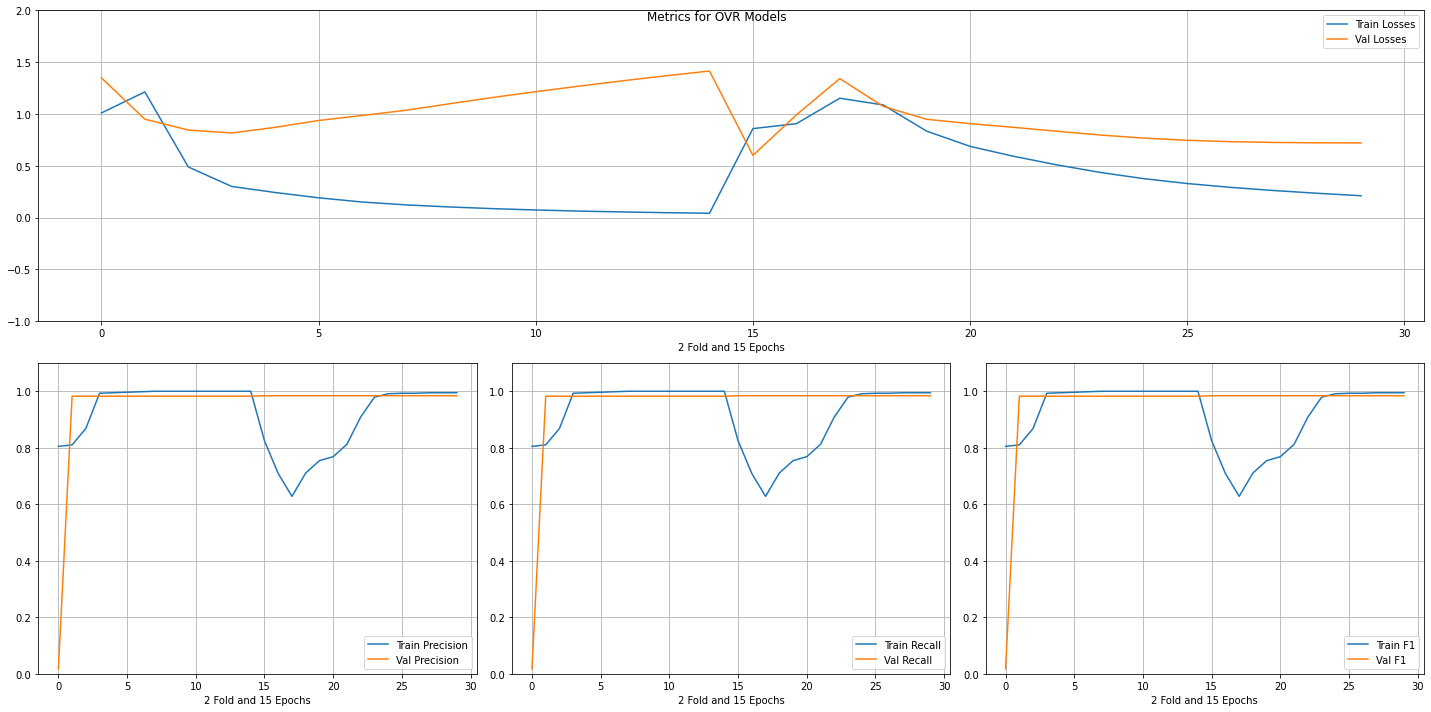

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.824561       0.984183  ...      0.858972           0.600340
1   0.708772       0.984183  ...      0.906531           0.991523
13  0.994737       0.984183  ...      0.234625           0.721848
12  0.994737       0.984183  ...      0.261126           0.725469
11  0.992982       0.984183  ...      0.291678           0.732936
10  0.992982       0.984183  ...      0.328802           0.746203
9   0.991228       0.984183  ...      0.375824           0.767332
8   0.978947       0.984183  ...      0.435748           0.797071
7   0.908772       0.984183  ...      0.508865           0.833393
6   0.812281       0.984183  ...      0.592043           0.871493
5   0.768421       0.984183  ...      0.687508           0.906639
4   0.754386       0.984183  ...      0.834546           0.949100
3   0.710526       0.984183  ...      1.087372           1.073113
2   0.628070       0.984183  ...      1.152476           1.341766
14  0.9947

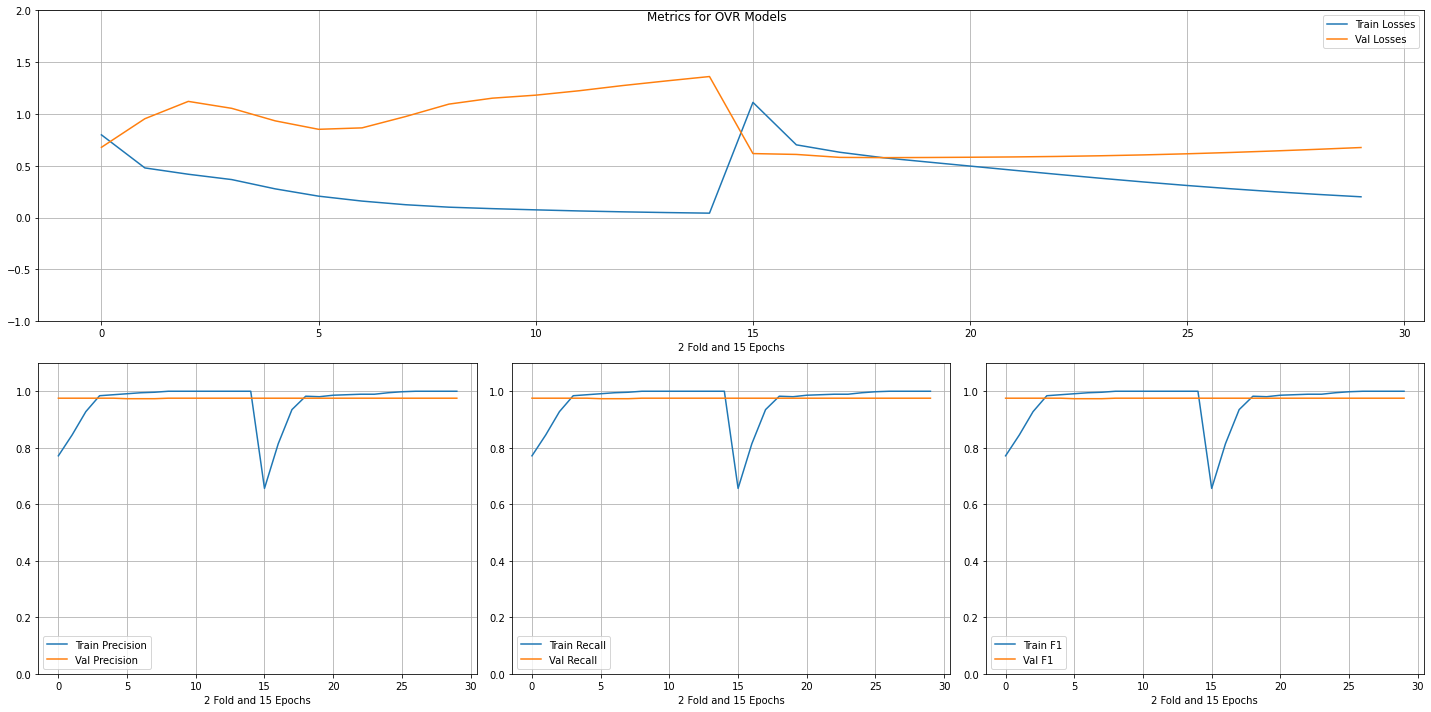

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.771529       0.975439  ...      0.798785           0.678406
8   1.000000       0.975439  ...      0.100606           1.095426
1   0.845343       0.975439  ...      0.479520           0.954457
14  1.000000       0.975439  ...      0.042870           1.361579
13  1.000000       0.975439  ...      0.048699           1.319034
12  1.000000       0.975439  ...      0.055628           1.274477
11  1.000000       0.975439  ...      0.064186           1.224544
9   1.000000       0.975439  ...      0.086464           1.152730
10  1.000000       0.975439  ...      0.074747           1.181824
4   0.987698       0.975439  ...      0.277470           0.933950
3   0.984183       0.975439  ...      0.367036           1.054701
2   0.927944       0.975439  ...      0.418487           1.121726
11  1.000000       0.975395  ...      0.278446           0.628688
6   0.987719       0.975395  ...      0.457166           0.585585
12  1.0000

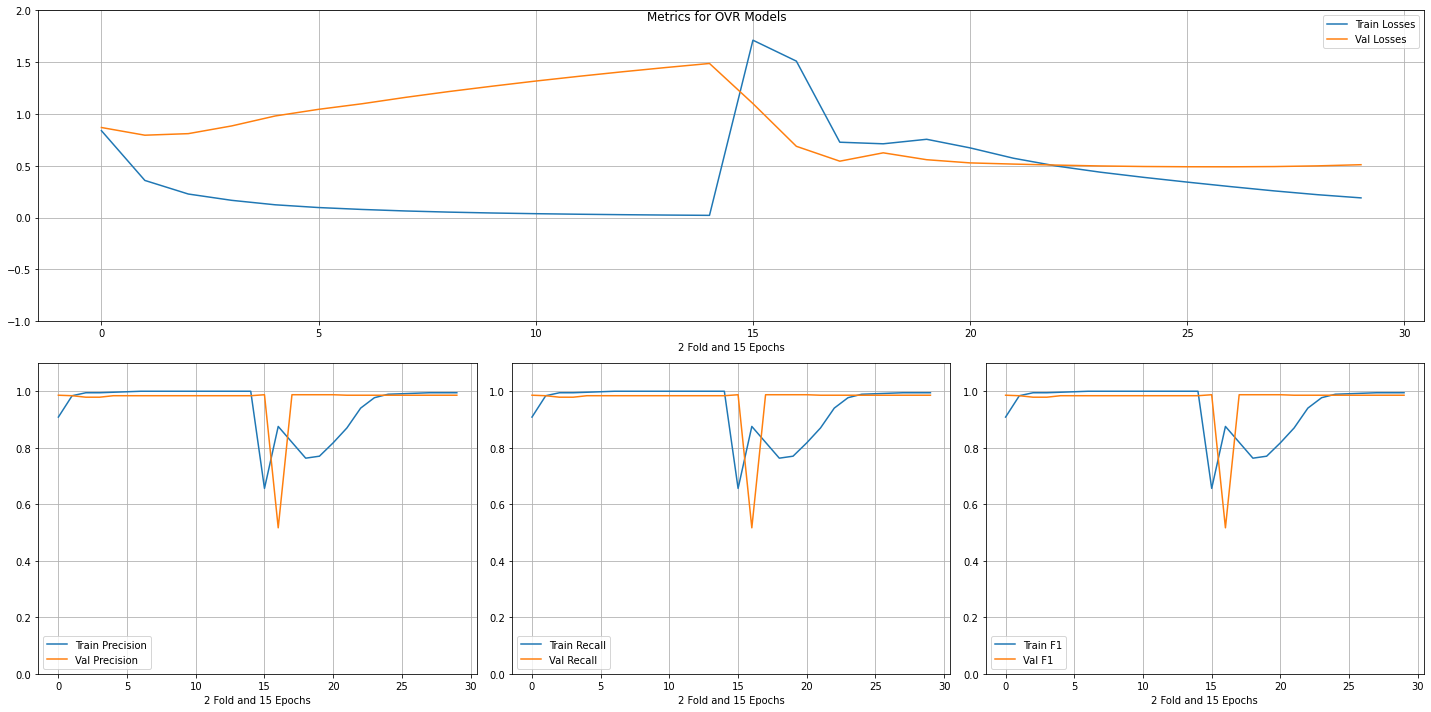

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.656140       0.987698  ...      1.712375           1.100579
2   0.819298       0.987698  ...      0.727651           0.544546
5   0.817544       0.987698  ...      0.672926           0.528005
4   0.770175       0.987698  ...      0.755912           0.558786
3   0.763158       0.987698  ...      0.712346           0.625250
0   0.908612       0.985965  ...      0.839087           0.869604
14  0.994737       0.985940  ...      0.190348           0.510538
13  0.994737       0.985940  ...      0.221068           0.499314
12  0.994737       0.985940  ...      0.257861           0.492577
11  0.992982       0.985940  ...      0.298971           0.490311
10  0.991228       0.985940  ...      0.342548           0.490778
9   0.989474       0.985940  ...      0.388370           0.493175
8   0.977193       0.985940  ...      0.438311           0.498391
7   0.940351       0.985940  ...      0.497037           0.506749
6   0.8701

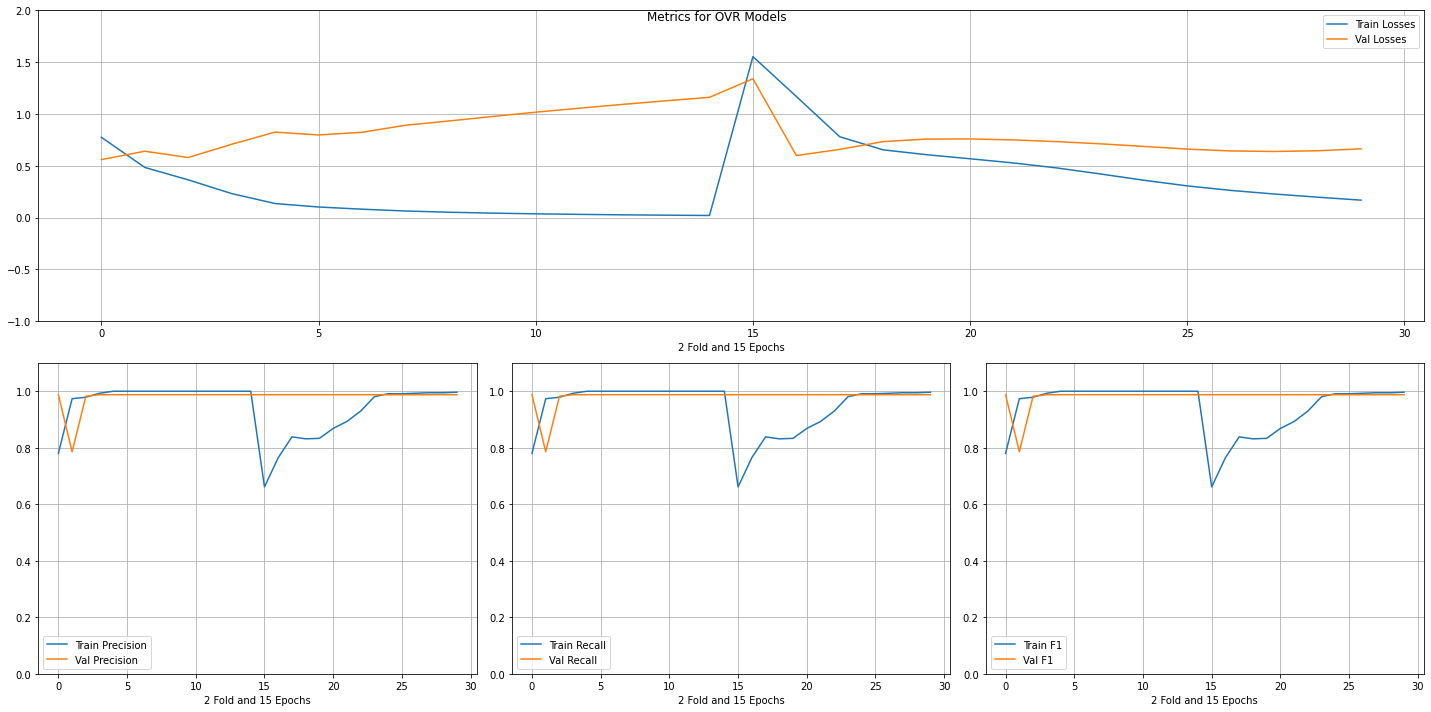

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.780316       0.987719  ...      0.774872           0.559696
8   1.000000       0.987719  ...      0.051815           0.932584
14  1.000000       0.987719  ...      0.020499           1.160896
13  1.000000       0.987719  ...      0.023348           1.127563
12  1.000000       0.987719  ...      0.026806           1.092767
11  1.000000       0.987719  ...      0.031060           1.055688
9   1.000000       0.987719  ...      0.043136           0.975659
10  1.000000       0.987719  ...      0.036361           1.017491
7   1.000000       0.987719  ...      0.063709           0.891194
6   1.000000       0.987719  ...      0.081203           0.823528
5   1.000000       0.987719  ...      0.102347           0.797686
4   1.000000       0.987719  ...      0.135546           0.825180
3   0.992970       0.987719  ...      0.231735           0.708077
6   0.892982       0.987698  ...      0.527364           0.749921
13  0.9947

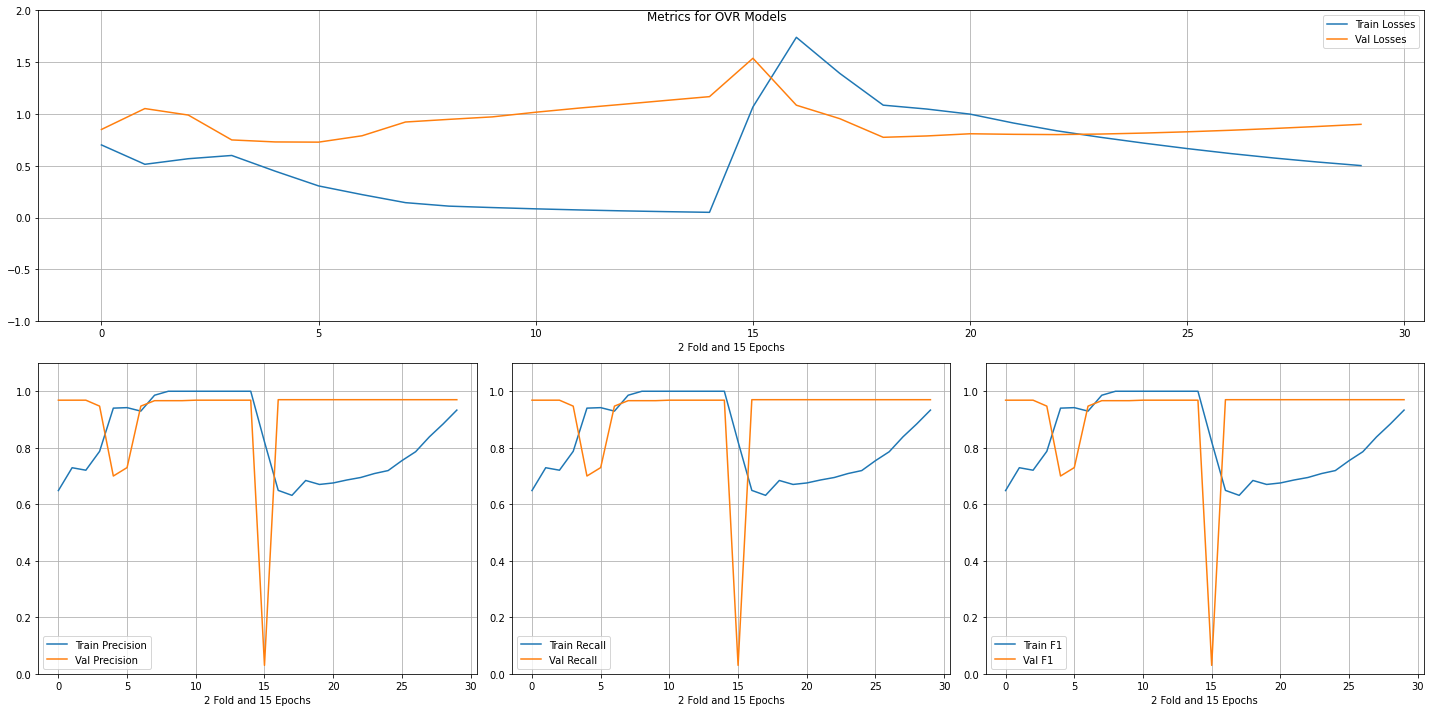

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.933333       0.970123  ...      0.502094           0.900348
13  0.884211       0.970123  ...      0.536473           0.879577
12  0.838596       0.970123  ...      0.574994           0.860298
11  0.785965       0.970123  ...      0.618166           0.843072
10  0.754386       0.970123  ...      0.666178           0.828177
9   0.719298       0.970123  ...      0.718757           0.815909
8   0.708772       0.970123  ...      0.775325           0.806453
7   0.694737       0.970123  ...      0.837496           0.801243
6   0.685965       0.970123  ...      0.912688           0.803795
5   0.675439       0.970123  ...      0.998680           0.809209
4   0.670175       0.970123  ...      1.047970           0.788053
3   0.684211       0.970123  ...      1.085285           0.775026
2   0.631579       0.970123  ...      1.391865           0.954825
1   0.649123       0.970123  ...      1.740161           1.084971
1   0.7293

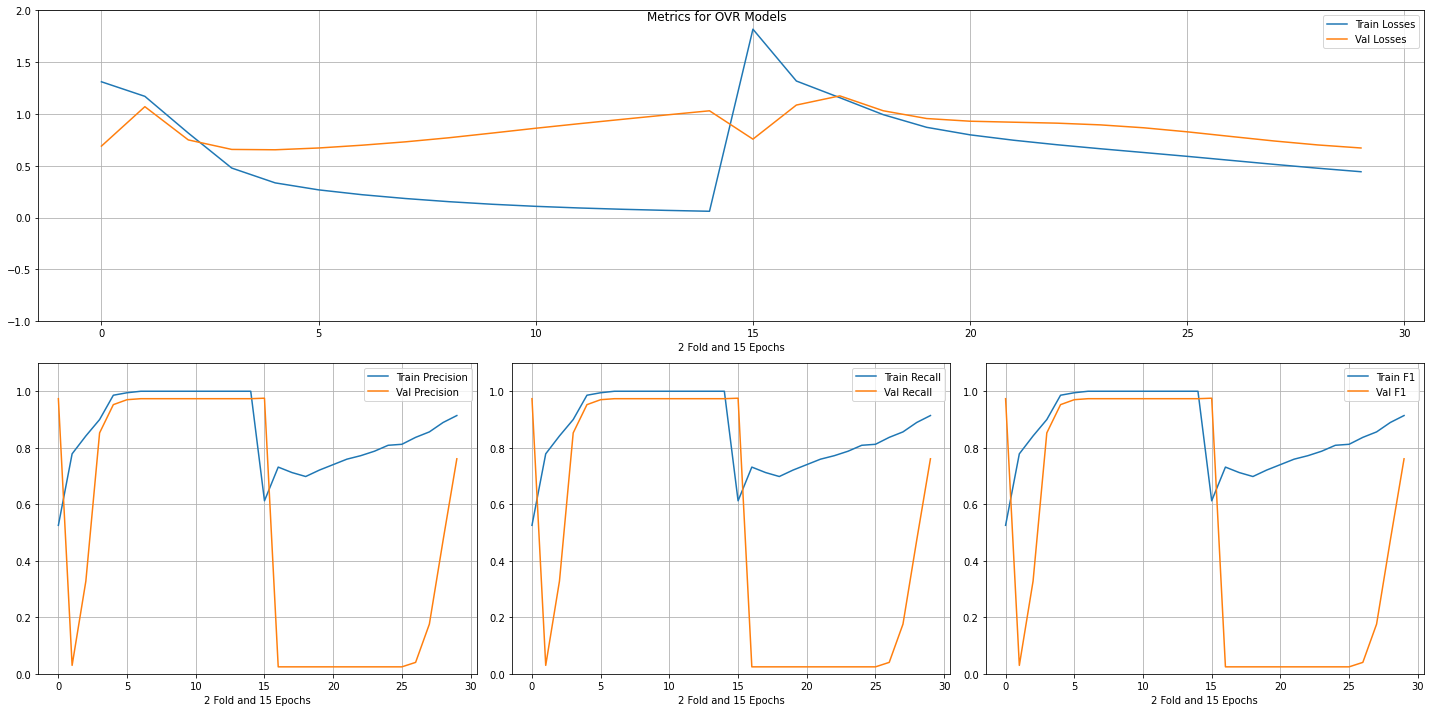

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.612281       0.975395  ...      1.818559           0.757234
8   1.000000       0.973684  ...      0.153685           0.770641
14  1.000000       0.973684  ...      0.061029           1.030878
13  1.000000       0.973684  ...      0.069729           0.990506
12  1.000000       0.973684  ...      0.080213           0.948859
11  1.000000       0.973684  ...      0.092946           0.906493
10  1.000000       0.973684  ...      0.108732           0.862546
9   1.000000       0.973684  ...      0.128701           0.816047
0   0.525483       0.973684  ...      1.311053           0.690074
7   1.000000       0.973684  ...      0.184134           0.731317
6   1.000000       0.973684  ...      0.221049           0.698806
5   0.994728       0.970175  ...      0.267764           0.671885
4   0.985940       0.952632  ...      0.335237           0.654648
3   0.899824       0.852632  ...      0.478265           0.658059
14  0.9140

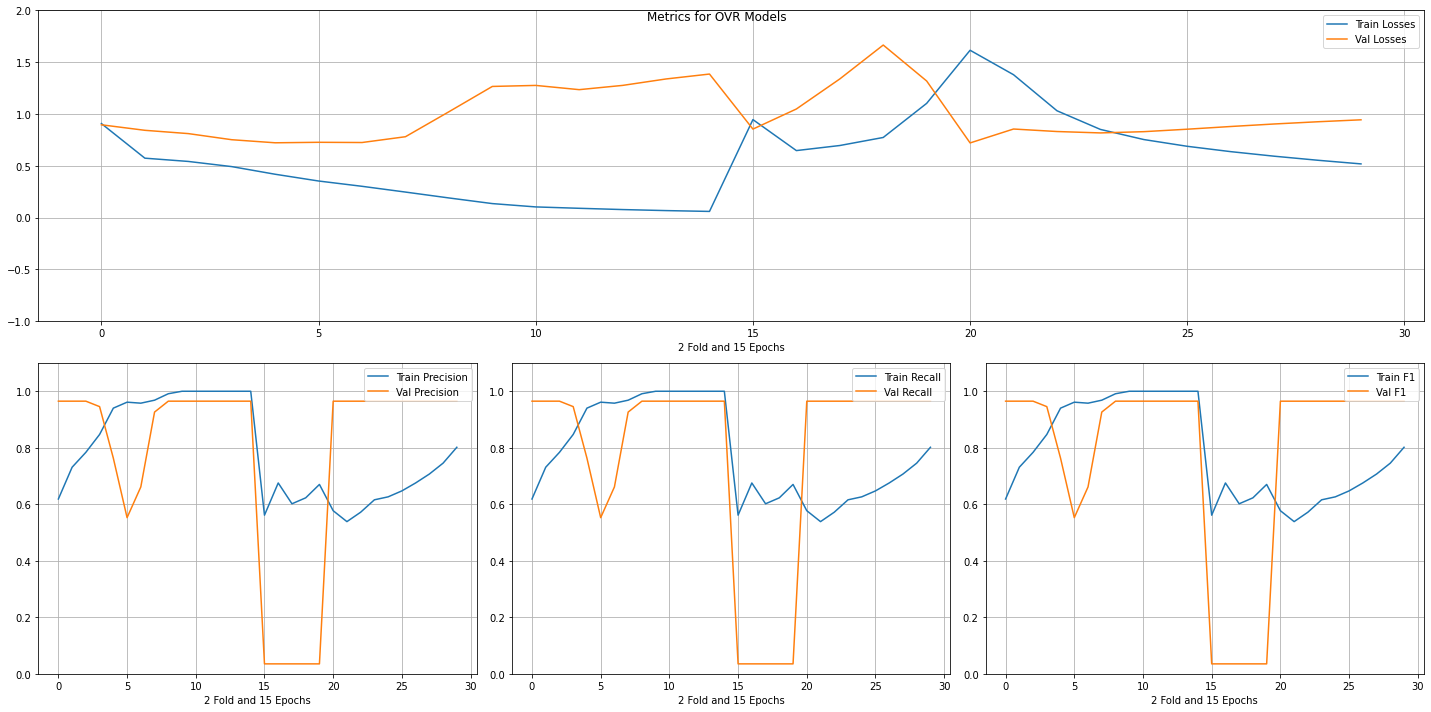

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.618629       0.964912  ...      0.907473           0.895687
8   0.991213       0.964912  ...      0.189722           1.021560
1   0.731107       0.964912  ...      0.573598           0.842629
14  1.000000       0.964912  ...      0.059623           1.385595
13  1.000000       0.964912  ...      0.067656           1.338191
12  1.000000       0.964912  ...      0.077575           1.276066
11  1.000000       0.964912  ...      0.089784           1.234985
10  1.000000       0.964912  ...      0.103064           1.275874
9   1.000000       0.964912  ...      0.135228           1.266062
2   0.783831       0.964912  ...      0.542112           0.810797
5   0.577193       0.964851  ...      1.615244           0.720755
9   0.626316       0.964851  ...      0.753376           0.829478
10  0.647368       0.964851  ...      0.688186           0.853244
11  0.675439       0.964851  ...      0.636692           0.879319
12  0.7070

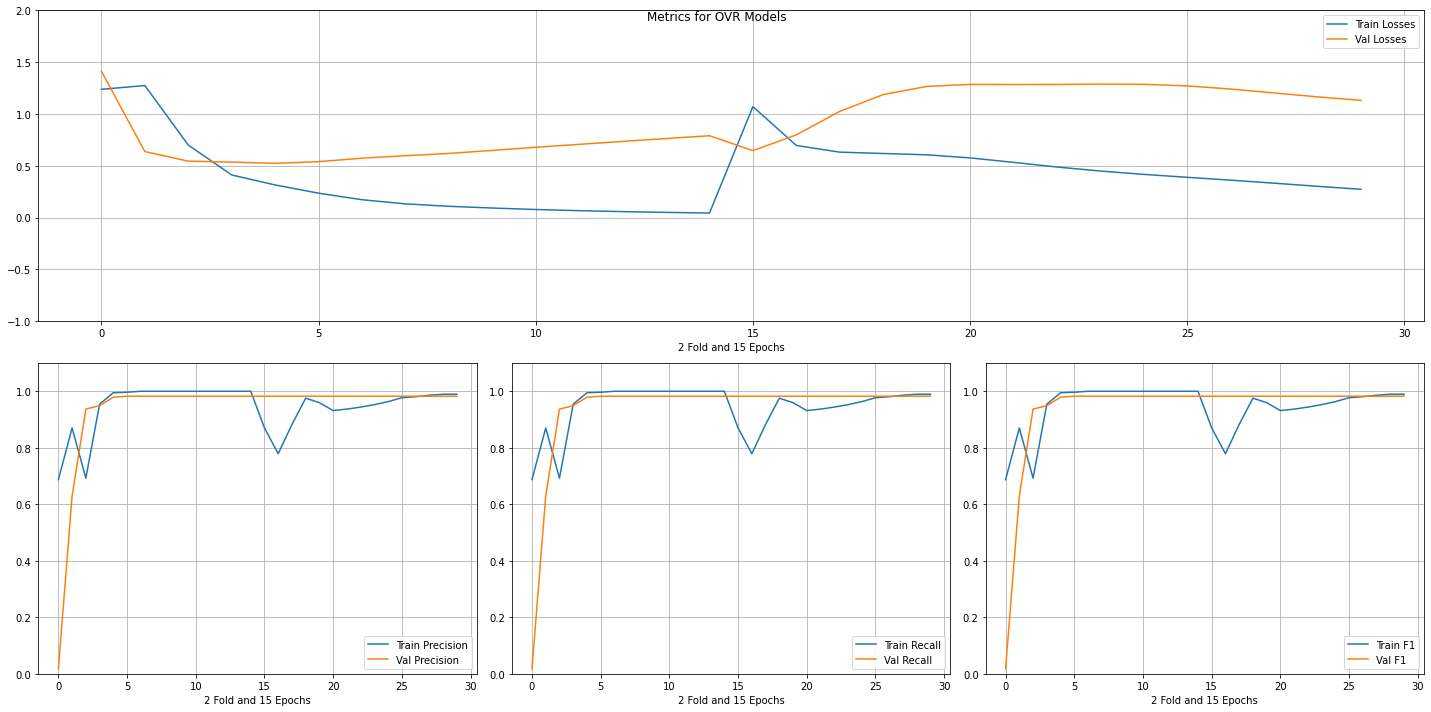

    train_f1  validation_f1  ...  train_losses  validation_losses
10  1.000000       0.982456  ...      0.078192           0.678802
14  1.000000       0.982456  ...      0.044129           0.790169
5   0.996485       0.982456  ...      0.235719           0.539921
6   1.000000       0.982456  ...      0.172513           0.573567
7   1.000000       0.982456  ...      0.132458           0.597366
8   1.000000       0.982456  ...      0.109174           0.619320
9   1.000000       0.982456  ...      0.092339           0.648895
11  1.000000       0.982456  ...      0.066841           0.707065
12  1.000000       0.982456  ...      0.057769           0.735537
13  1.000000       0.982456  ...      0.050301           0.763207
7   0.943860       0.982425  ...      0.488296           1.285264
8   0.952632       0.982425  ...      0.449329           1.288682
9   0.963158       0.982425  ...      0.417055           1.286433
10  0.977193       0.982425  ...      0.388888           1.270858
0   0.8701

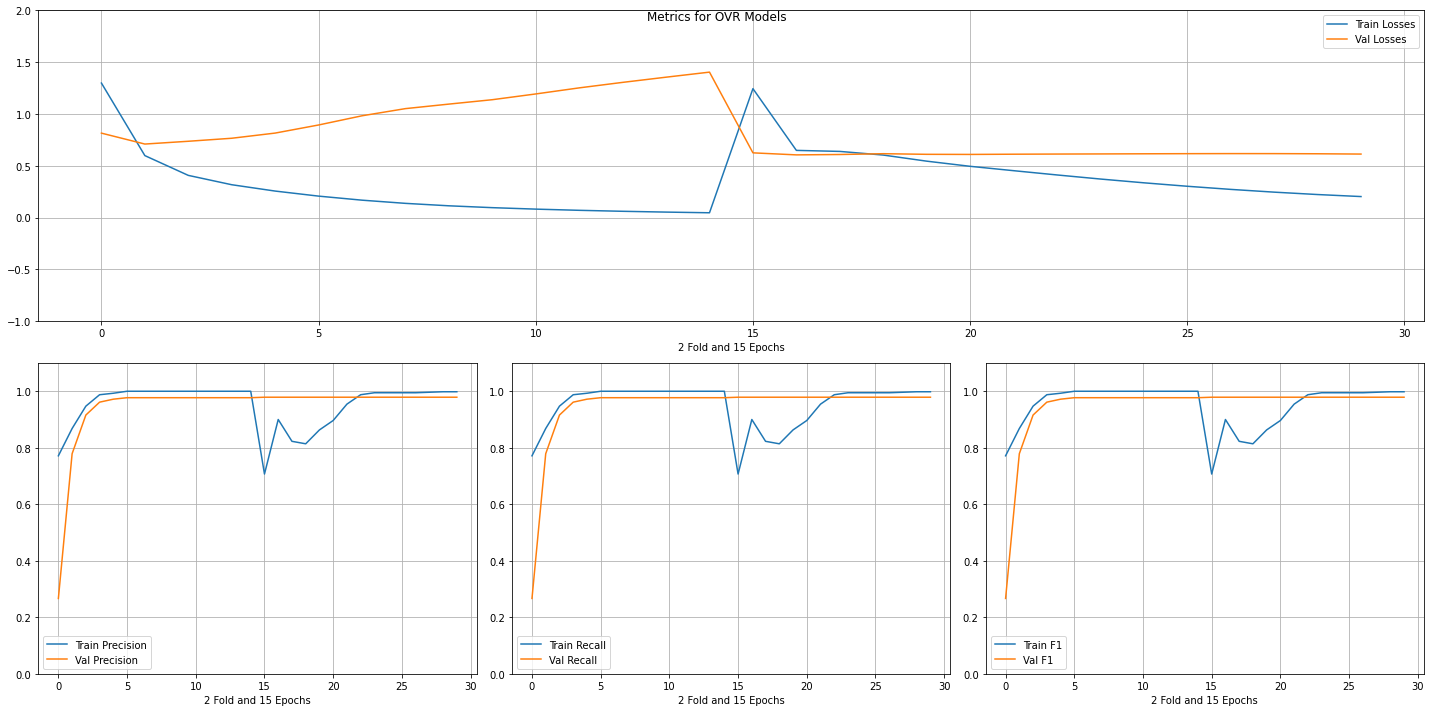

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.707018       0.978910  ...      1.244575           0.625052
1   0.900000       0.978910  ...      0.648820           0.605420
13  0.998246       0.978910  ...      0.222608           0.616179
12  0.996491       0.978910  ...      0.245691           0.617566
11  0.994737       0.978910  ...      0.272354           0.617746
10  0.994737       0.978910  ...      0.302469           0.617095
9   0.994737       0.978910  ...      0.335841           0.615938
8   0.994737       0.978910  ...      0.372287           0.614536
7   0.987719       0.978910  ...      0.411709           0.613370
6   0.954386       0.978910  ...      0.452899           0.611902
5   0.896491       0.978910  ...      0.495044           0.609781
4   0.863158       0.978910  ...      0.544817           0.610814
3   0.814035       0.978910  ...      0.603744           0.616773
2   0.822807       0.978910  ...      0.638877           0.609020
14  0.9982

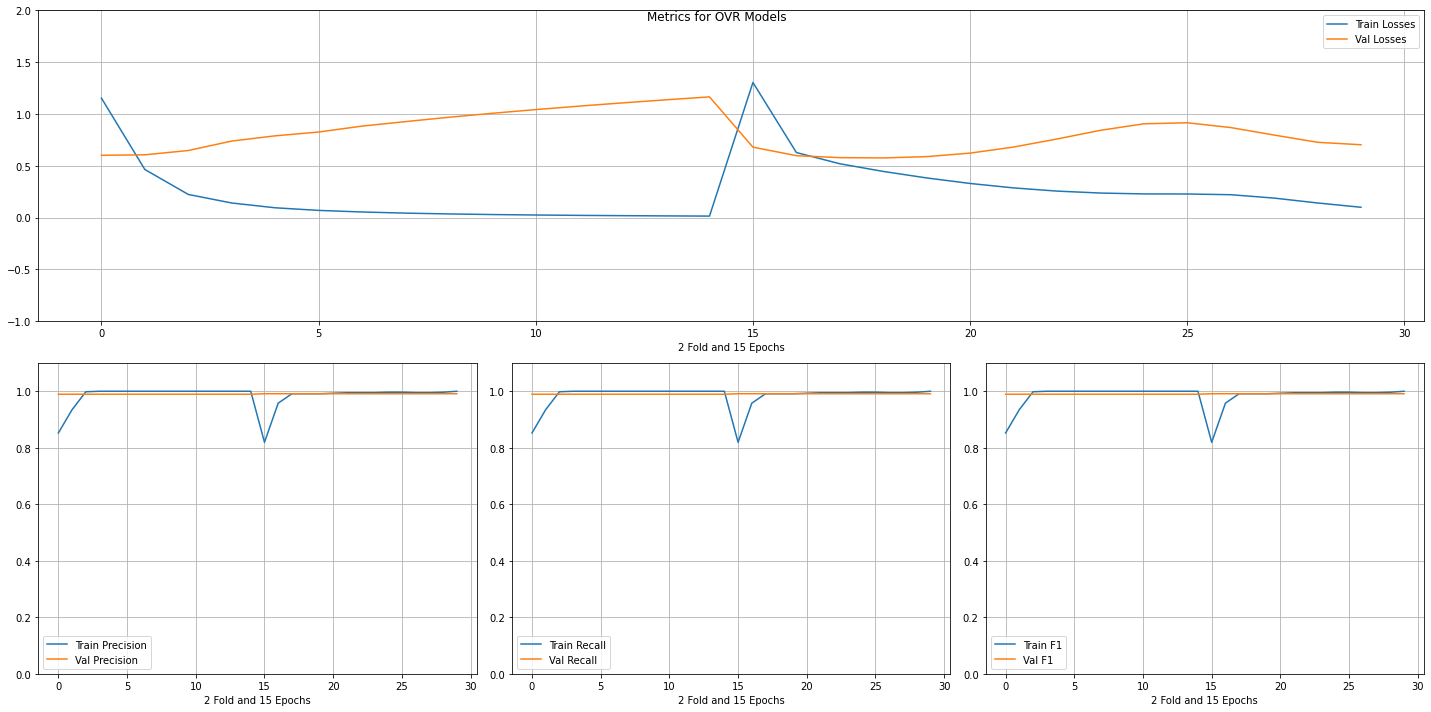

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.819298       0.991213  ...      1.304358           0.679897
1   0.957895       0.991213  ...      0.628218           0.597780
13  0.996491       0.991213  ...      0.141187           0.726951
12  0.994737       0.991213  ...      0.188332           0.796701
11  0.994737       0.991213  ...      0.221051           0.869148
10  0.996491       0.991213  ...      0.227812           0.915416
9   0.996491       0.991213  ...      0.228592           0.905457
8   0.994737       0.991213  ...      0.237027           0.842404
7   0.994737       0.991213  ...      0.255794           0.758719
6   0.994737       0.991213  ...      0.286691           0.680911
5   0.992982       0.991213  ...      0.329439           0.622617
4   0.991228       0.991213  ...      0.382792           0.588559
3   0.991228       0.991213  ...      0.445693           0.575971
2   0.991228       0.991213  ...      0.519722           0.578751
14  1.0000

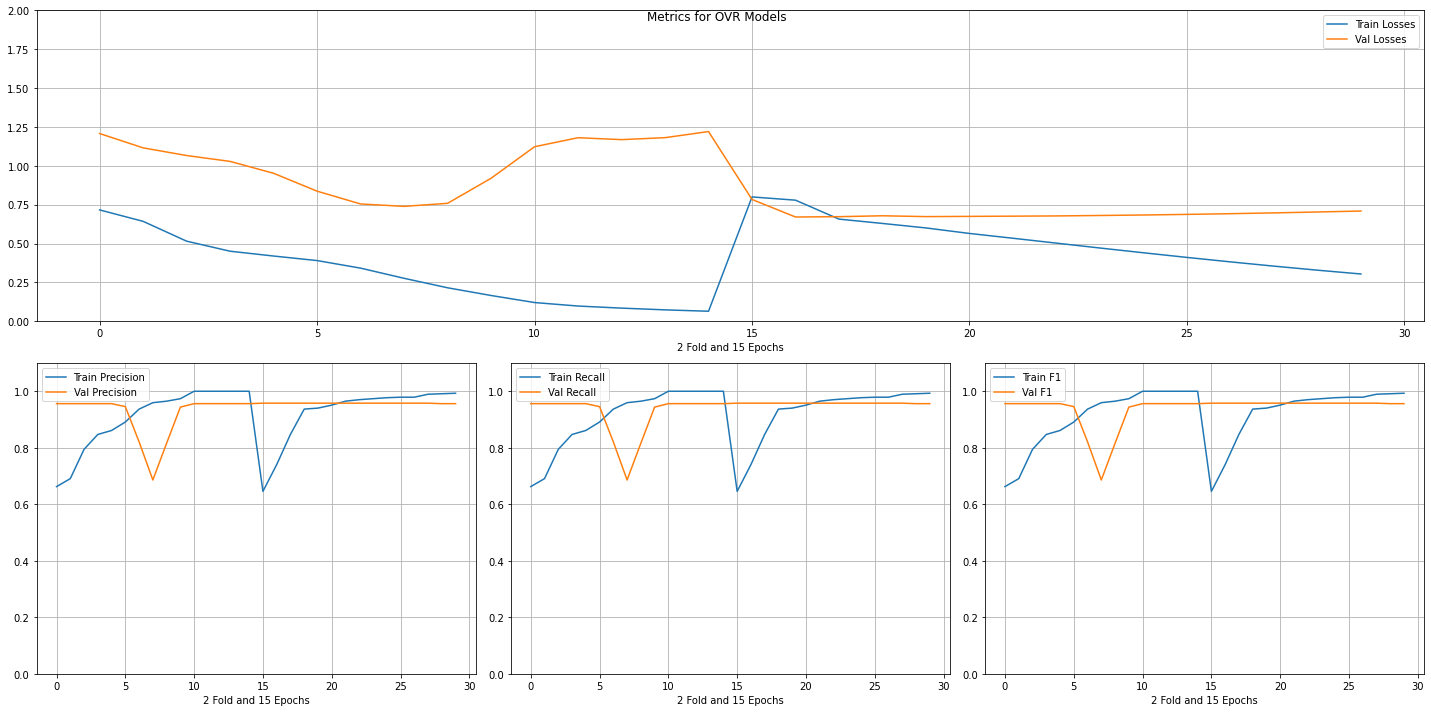

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.645614       0.957821  ...      0.799671           0.783329
12  0.989474       0.957821  ...      0.354302           0.696985
11  0.978947       0.957821  ...      0.381742           0.691851
10  0.978947       0.957821  ...      0.410465           0.687310
9   0.977193       0.957821  ...      0.440323           0.683425
8   0.973684       0.957821  ...      0.470926           0.680276
7   0.970175       0.957821  ...      0.502374           0.677427
6   0.964912       0.957821  ...      0.533758           0.675921
5   0.950877       0.957821  ...      0.564636           0.674504
4   0.940351       0.957821  ...      0.600081           0.673066
3   0.936842       0.957821  ...      0.628995           0.678432
2   0.847368       0.957821  ...      0.656902           0.672648
1   0.740351       0.957821  ...      0.778815           0.670513
1   0.690685       0.956140  ...      0.642556           1.115501
0   0.6625

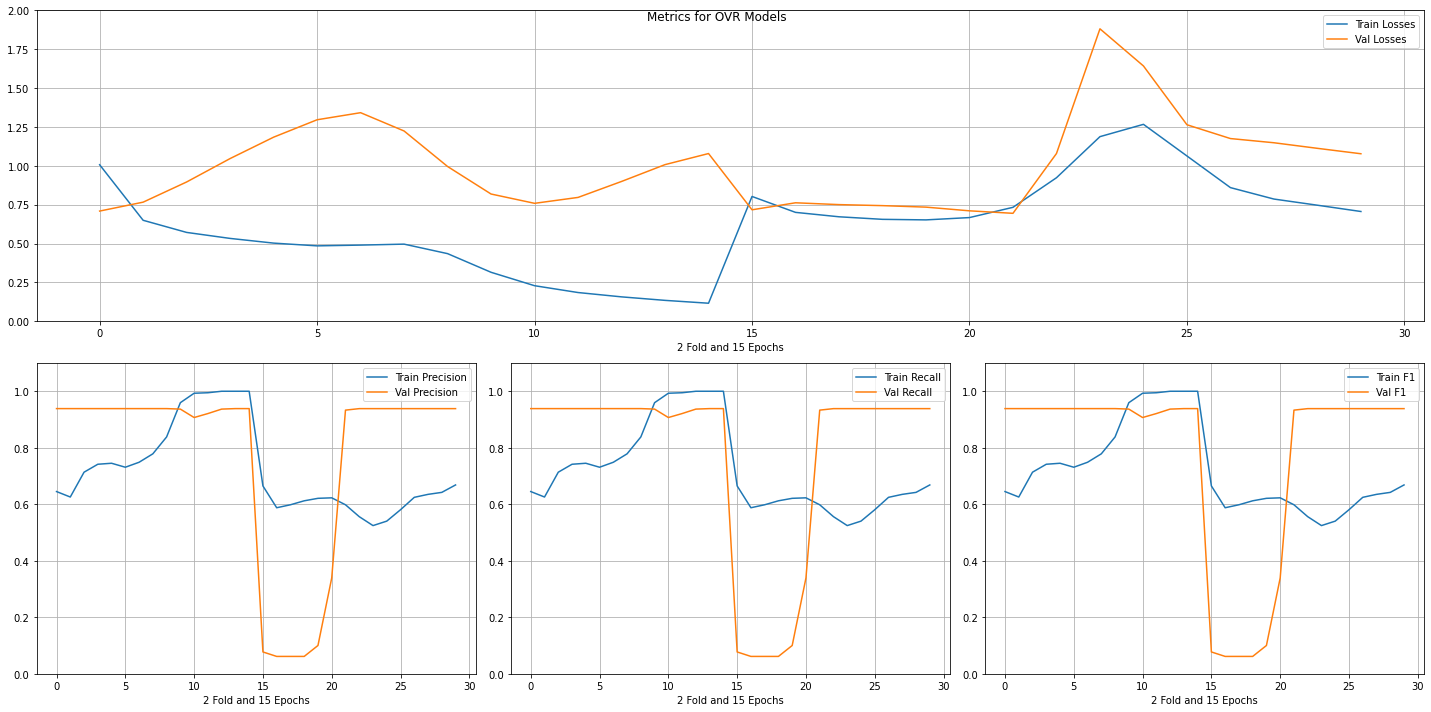

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.644991       0.938596  ...      1.006738           0.708703
13  1.000000       0.938596  ...      0.134050           1.007561
2   0.713533       0.938596  ...      0.571330           0.895889
3   0.741652       0.938596  ...      0.532719           1.046621
4   0.745167       0.938596  ...      0.502503           1.184196
5   0.731107       0.938596  ...      0.484825           1.296259
6   0.748682       0.938596  ...      0.489691           1.341765
7   0.778559       0.938596  ...      0.495951           1.224016
8   0.838313       0.938596  ...      0.434776           0.995479
1   0.625659       0.938596  ...      0.649351           0.766002
14  1.000000       0.938596  ...      0.115686           1.078880
9   0.540351       0.938489  ...      1.266779           1.642411
13  0.642105       0.938489  ...      0.746368           1.112386
10  0.580702       0.938489  ...      1.063233           1.264116
11  0.6245

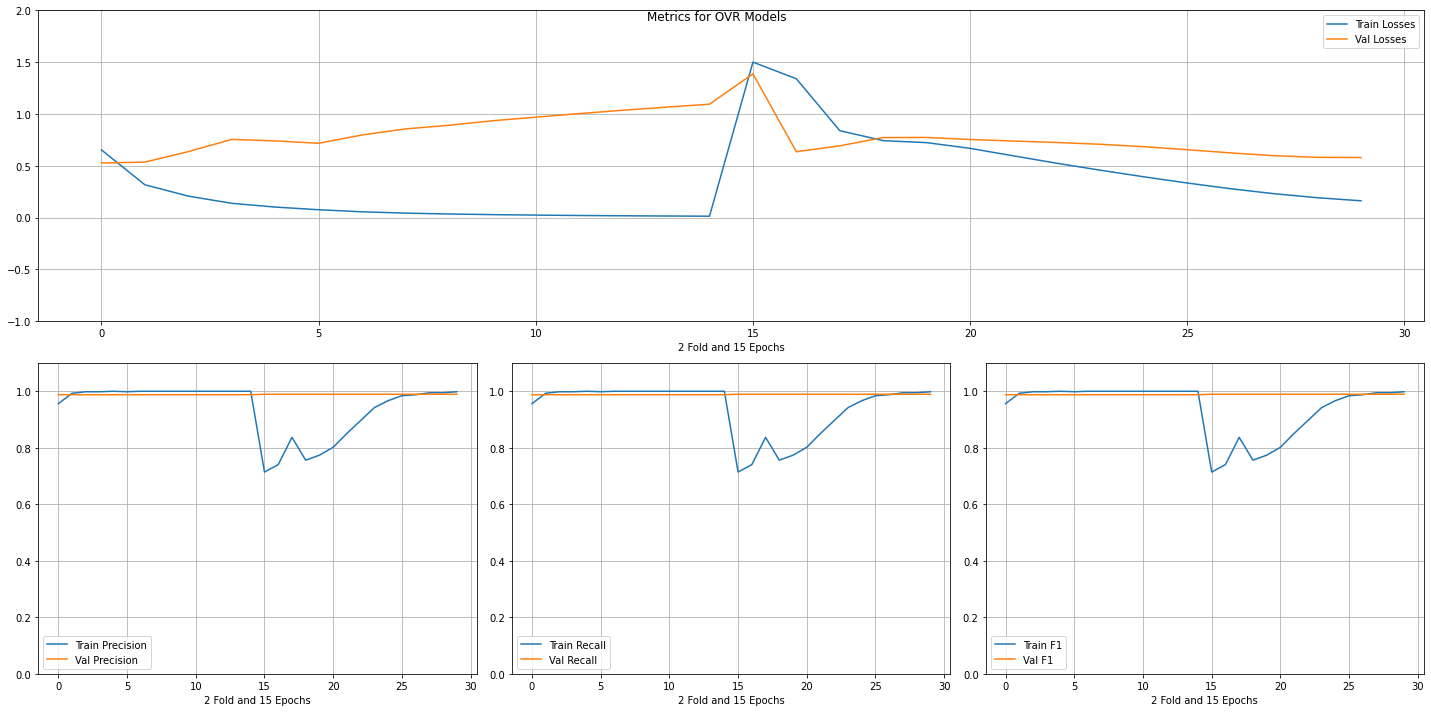

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.714035       0.989455  ...      1.500821           1.387574
1   0.740351       0.989455  ...      1.339915           0.635862
13  0.994737       0.989455  ...      0.191800           0.581885
12  0.994737       0.989455  ...      0.230559           0.597421
11  0.987719       0.989455  ...      0.278587           0.624356
10  0.984211       0.989455  ...      0.333755           0.655694
9   0.966667       0.989455  ...      0.393777           0.684581
8   0.942105       0.989455  ...      0.457373           0.707701
7   0.896491       0.989455  ...      0.524514           0.725088
6   0.850877       0.989455  ...      0.595862           0.739068
5   0.801754       0.989455  ...      0.668415           0.754077
4   0.773684       0.989455  ...      0.723454           0.773400
3   0.756140       0.989455  ...      0.742931           0.772564
2   0.836842       0.989455  ...      0.838900           0.692941
14  0.9982

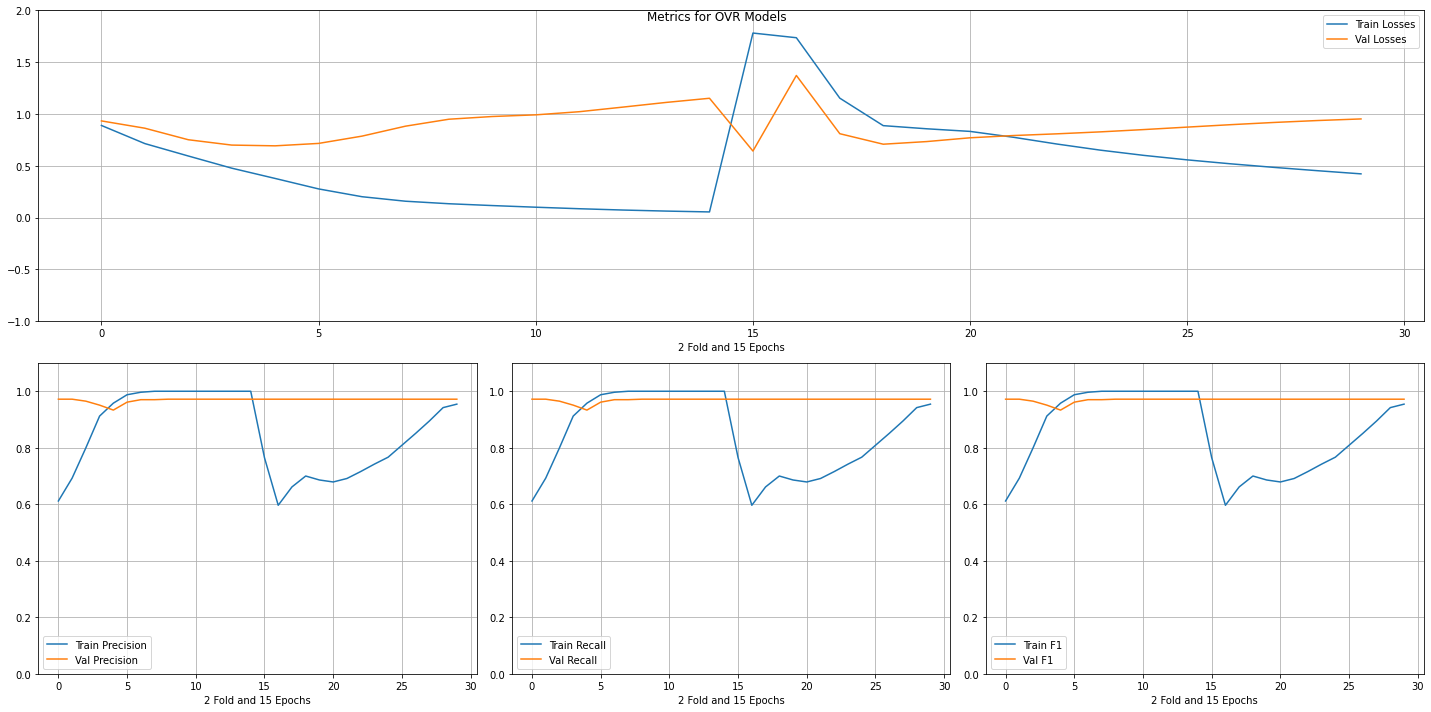

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.611599       0.971930  ...      0.889381           0.933347
8   1.000000       0.971930  ...      0.133790           0.949581
1   0.692443       0.971930  ...      0.714385           0.862811
14  1.000000       0.971930  ...      0.054750           1.151834
13  1.000000       0.971930  ...      0.062920           1.111640
12  1.000000       0.971930  ...      0.073077           1.066293
11  1.000000       0.971930  ...      0.085663           1.022040
10  1.000000       0.971930  ...      0.100273           0.991812
9   1.000000       0.971930  ...      0.116173           0.975823
4   0.685965       0.971880  ...      0.857357           0.733866
8   0.742105       0.971880  ...      0.651007           0.827523
9   0.766667       0.971880  ...      0.600566           0.849685
10  0.808772       0.971880  ...      0.557223           0.873487
11  0.850877       0.971880  ...      0.519126           0.896909
12  0.8947

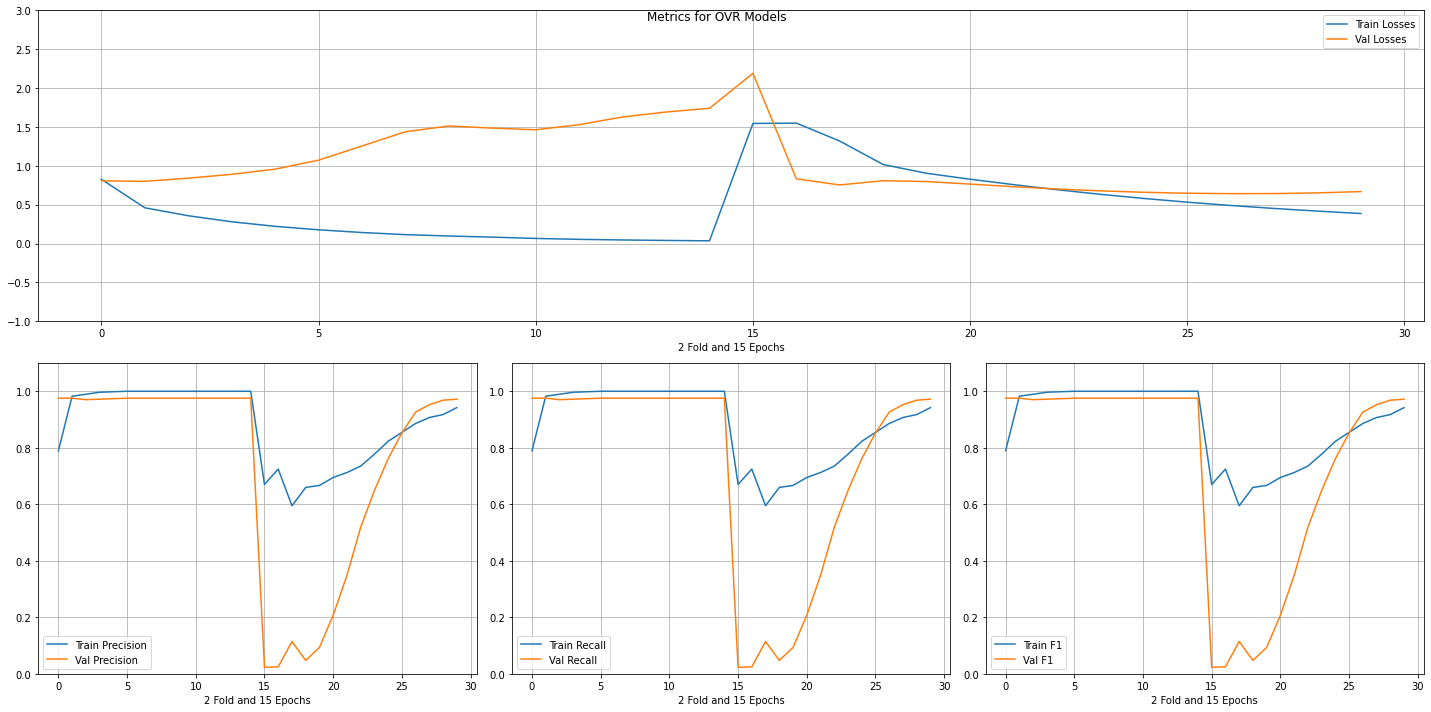

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.789104       0.975439  ...      0.825974           0.806451
14  1.000000       0.975439  ...      0.034437           1.740003
1   0.982425       0.975439  ...      0.459471           0.800165
5   1.000000       0.975439  ...      0.176385           1.072837
6   1.000000       0.975439  ...      0.141360           1.255079
7   1.000000       0.975439  ...      0.113998           1.438394
8   1.000000       0.975439  ...      0.096464           1.512369
9   1.000000       0.975439  ...      0.081841           1.484936
10  1.000000       0.975439  ...      0.065176           1.463874
11  1.000000       0.975439  ...      0.053494           1.529656
12  1.000000       0.975439  ...      0.045591           1.628474
13  1.000000       0.975439  ...      0.039369           1.692078
4   0.998243       0.973684  ...      0.220822           0.957192
3   0.996485       0.971930  ...      0.279583           0.890371
14  0.9421

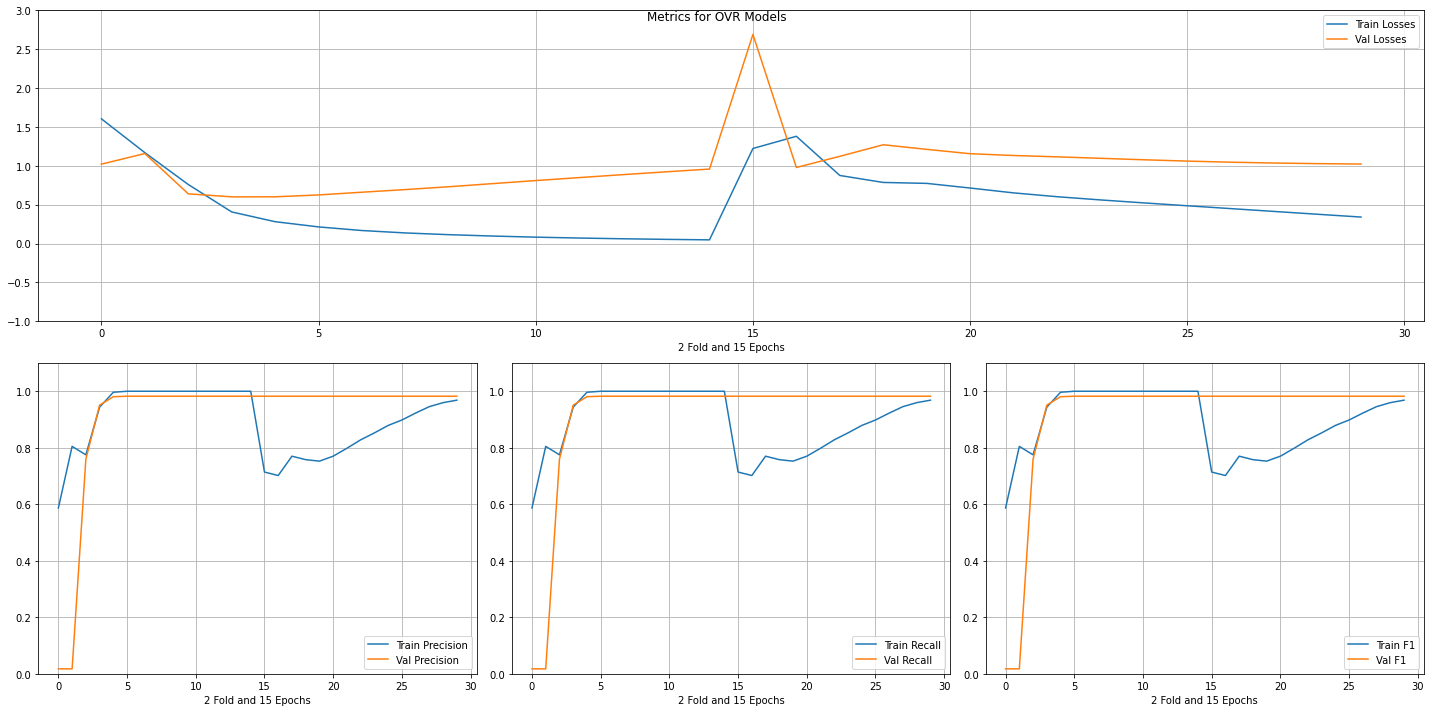

    train_f1  validation_f1  ...  train_losses  validation_losses
10  1.000000       0.982456  ...      0.081661           0.809925
14  1.000000       0.982456  ...      0.046902           0.957891
5   1.000000       0.982456  ...      0.213490           0.625044
6   1.000000       0.982456  ...      0.166872           0.660134
7   1.000000       0.982456  ...      0.135741           0.694193
8   1.000000       0.982456  ...      0.113551           0.730483
9   1.000000       0.982456  ...      0.095933           0.770375
11  1.000000       0.982456  ...      0.070229           0.848260
12  1.000000       0.982456  ...      0.060946           0.885920
13  1.000000       0.982456  ...      0.053282           0.922511
7   0.828070       0.982425  ...      0.602292           1.115269
8   0.852632       0.982425  ...      0.560841           1.096510
9   0.878947       0.982425  ...      0.522623           1.077564
10  0.898246       0.982425  ...      0.485678           1.060528
0   0.7140

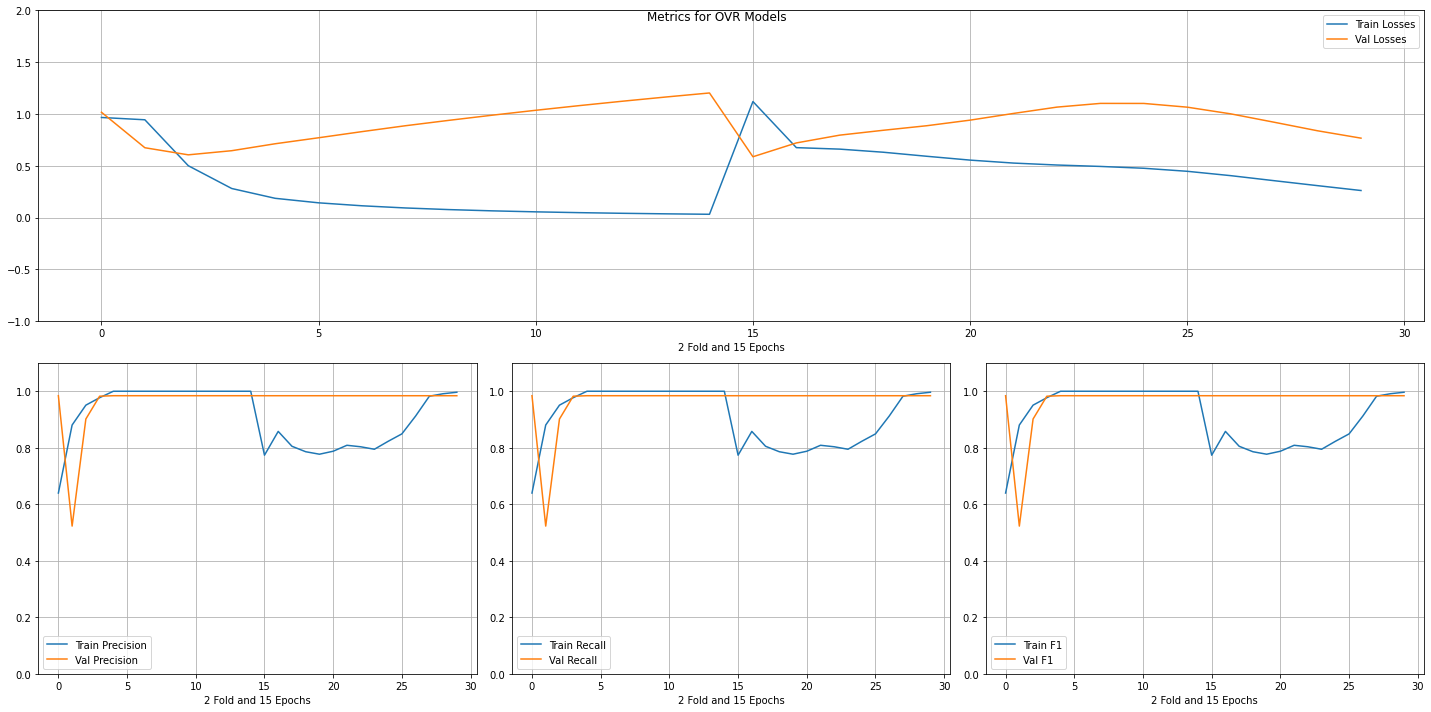

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.639719       0.984211  ...      0.966536           1.017044
8   1.000000       0.984211  ...      0.077287           0.938737
14  1.000000       0.984211  ...      0.032043           1.202981
13  1.000000       0.984211  ...      0.036338           1.164205
12  1.000000       0.984211  ...      0.041503           1.123524
11  1.000000       0.984211  ...      0.047783           1.080806
9   1.000000       0.984211  ...      0.065132           0.988556
10  1.000000       0.984211  ...      0.055508           1.035923
7   1.000000       0.984211  ...      0.092995           0.886740
6   1.000000       0.984211  ...      0.114017           0.829931
5   1.000000       0.984211  ...      0.142604           0.770597
4   1.000000       0.984211  ...      0.186181           0.712748
6   0.808772       0.984183  ...      0.526281           1.005499
12  0.982456       0.984183  ...      0.356315           0.920536
13  0.9912

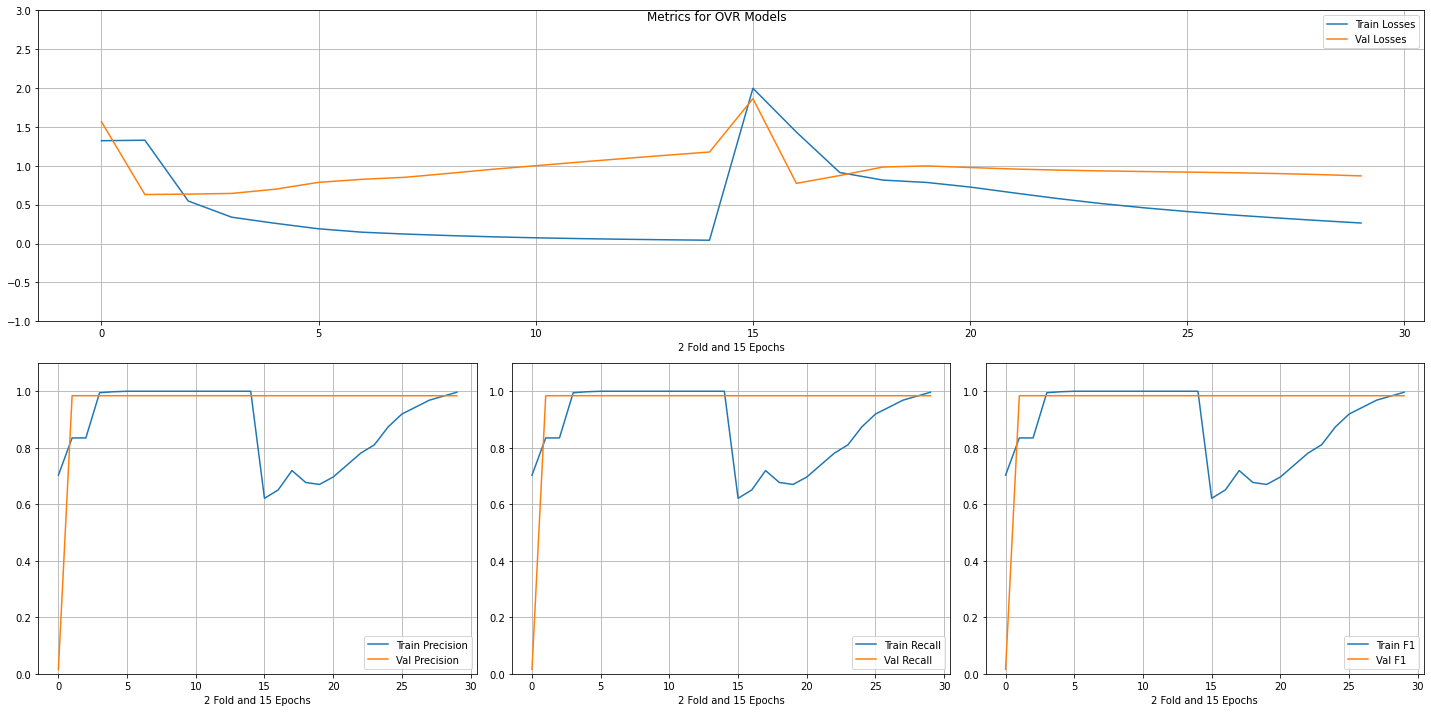

    train_f1  validation_f1  ...  train_losses  validation_losses
11  1.000000       0.984211  ...      0.063118           1.047480
9   1.000000       0.984211  ...      0.086130           0.954825
1   0.834798       0.984211  ...      1.329439           0.630195
14  1.000000       0.984211  ...      0.042224           1.177356
13  1.000000       0.984211  ...      0.047924           1.135575
12  1.000000       0.984211  ...      0.054785           1.092431
10  1.000000       0.984211  ...      0.073289           1.001026
8   1.000000       0.984211  ...      0.102239           0.902558
7   1.000000       0.984211  ...      0.121281           0.852539
6   1.000000       0.984211  ...      0.145408           0.825956
5   1.000000       0.984211  ...      0.189252           0.786997
4   0.998243       0.984211  ...      0.259953           0.698613
3   0.994728       0.984211  ...      0.338256           0.644453
2   0.834798       0.984211  ...      0.546530           0.635633
11  0.9438

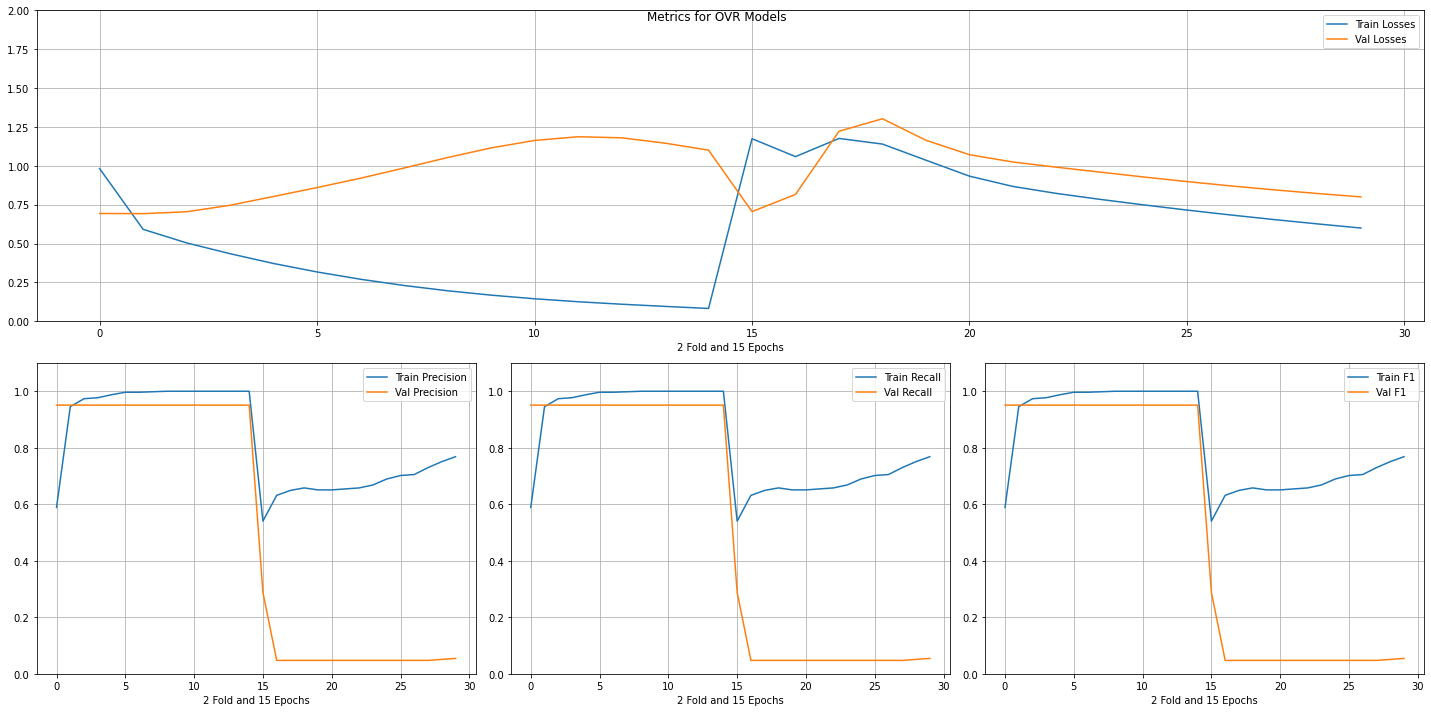

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.588752       0.950877  ...      0.981745           0.693187
1   0.945518       0.950877  ...      0.591196           0.692277
2   0.973638       0.950877  ...      0.503914           0.704163
3   0.977153       0.950877  ...      0.434284           0.745974
4   0.987698       0.950877  ...      0.371259           0.802712
5   0.996485       0.950877  ...      0.316812           0.859926
6   0.996485       0.950877  ...      0.269907           0.920255
7   0.998243       0.950877  ...      0.229774           0.985824
8   1.000000       0.950877  ...      0.195878           1.053092
9   1.000000       0.950877  ...      0.167656           1.115211
10  1.000000       0.950877  ...      0.144391           1.163114
11  1.000000       0.950877  ...      0.125256           1.186948
12  1.000000       0.950877  ...      0.109270           1.180120
13  1.000000       0.950877  ...      0.095230           1.145734
14  1.0000

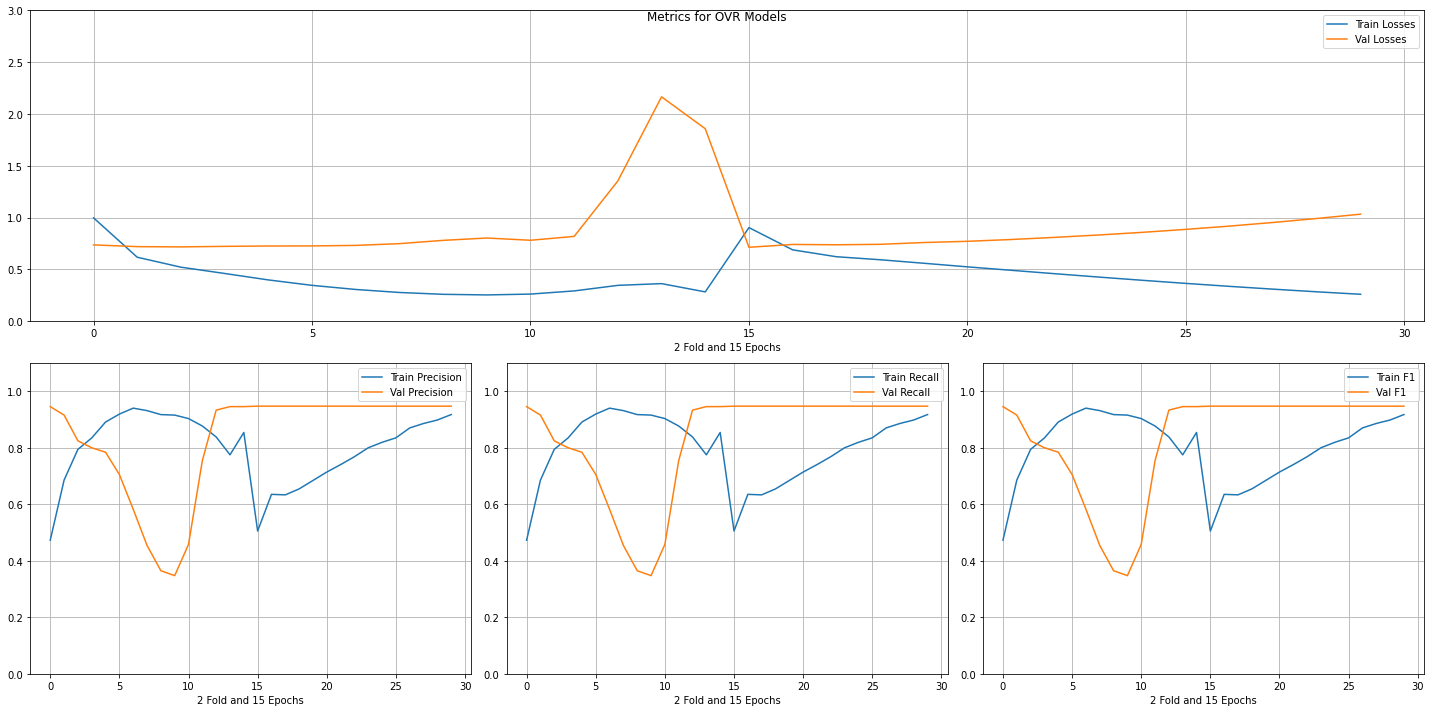

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.505263       0.947276  ...      0.903479           0.713422
1   0.635088       0.947276  ...      0.688806           0.740916
13  0.898246       0.947276  ...      0.283655           0.991527
12  0.885965       0.947276  ...      0.309159           0.953128
11  0.870175       0.947276  ...      0.336280           0.917992
10  0.835088       0.947276  ...      0.364938           0.886261
9   0.819298       0.947276  ...      0.394949           0.857584
8   0.800000       0.947276  ...      0.426155           0.832081
7   0.768421       0.947276  ...      0.458460           0.809173
6   0.740351       0.947276  ...      0.491496           0.788506
5   0.714035       0.947276  ...      0.524590           0.771236
4   0.684211       0.947276  ...      0.559385           0.759331
3   0.654386       0.947276  ...      0.593319           0.742137
2   0.633333       0.947276  ...      0.622422           0.737593
14  0.9175

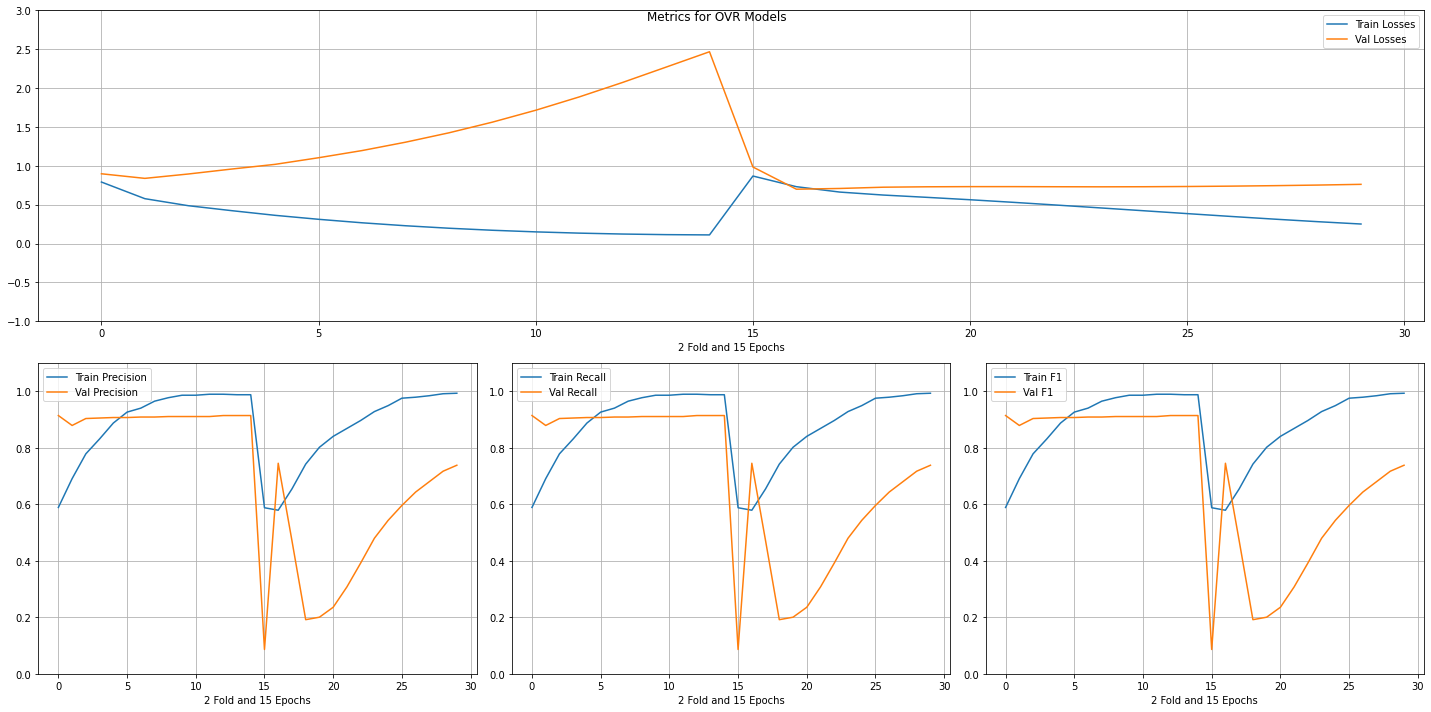

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.588752       0.914035  ...      0.790989           0.897357
12  0.989455       0.914035  ...      0.121738           2.072921
13  0.987698       0.914035  ...      0.114067           2.269911
14  0.987698       0.914035  ...      0.110559           2.467760
8   0.977153       0.910526  ...      0.196550           1.424335
9   0.985940       0.910526  ...      0.170466           1.561579
10  0.985940       0.910526  ...      0.149584           1.715150
11  0.989455       0.910526  ...      0.133494           1.886279
6   0.940246       0.908772  ...      0.266507           1.195998
7   0.964851       0.908772  ...      0.228506           1.303581
4   0.887522       0.907018  ...      0.362466           1.018782
5   0.926186       0.907018  ...      0.311425           1.103840
3   0.831283       0.905263  ...      0.422574           0.958262
2   0.778559       0.903509  ...      0.486501           0.894421
1   0.6906

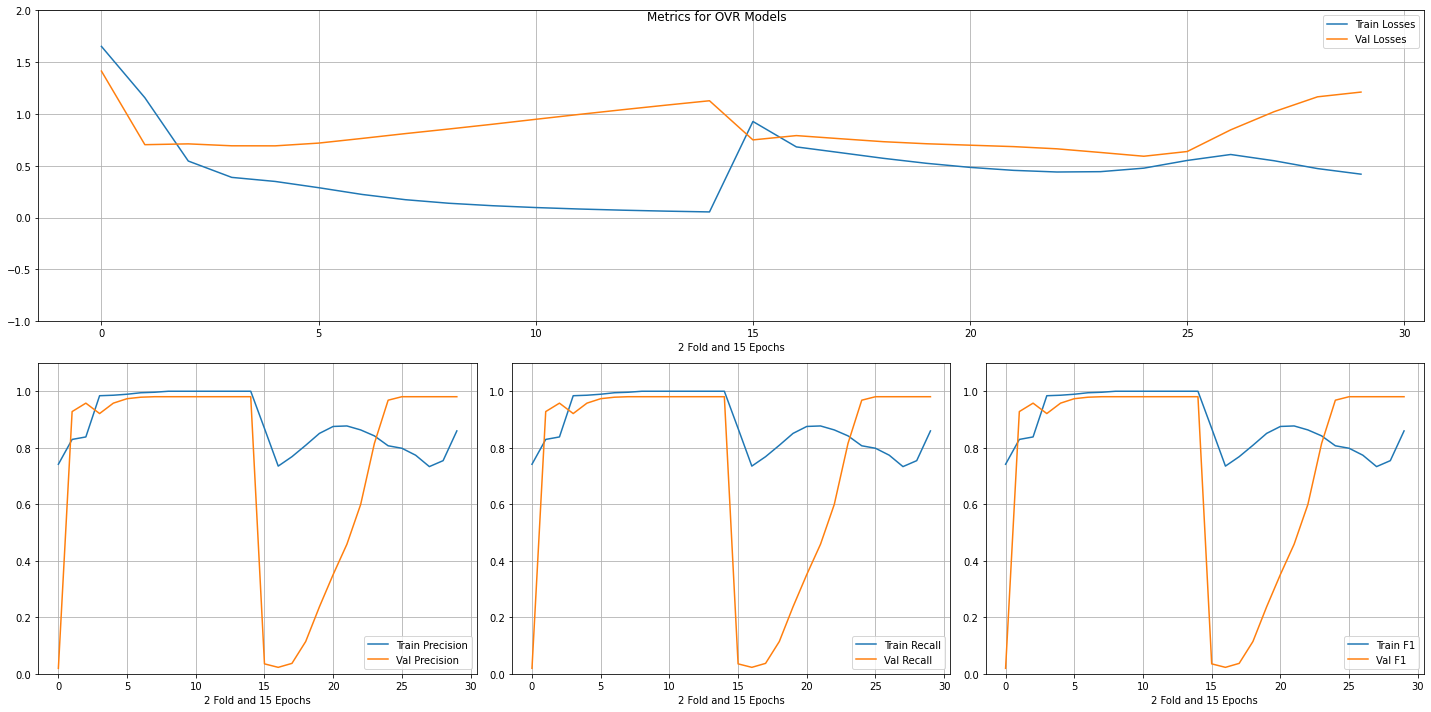

    train_f1  validation_f1  ...  train_losses  validation_losses
13  1.000000       0.980702  ...      0.062366           1.085427
11  1.000000       0.980702  ...      0.082896           0.996000
14  1.000000       0.980702  ...      0.054770           1.127776
12  1.000000       0.980702  ...      0.071568           1.041459
7   0.996485       0.980702  ...      0.172760           0.810864
8   1.000000       0.980702  ...      0.138406           0.855134
9   1.000000       0.980702  ...      0.114816           0.900917
10  1.000000       0.980702  ...      0.097022           0.948867
10  0.798246       0.980668  ...      0.551695           0.637954
13  0.754386       0.980668  ...      0.473117           1.165868
12  0.733333       0.980668  ...      0.548776           1.022412
14  0.859649       0.980668  ...      0.419209           1.211634
11  0.773684       0.980668  ...      0.609063           0.847007
6   0.994728       0.978947  ...      0.223617           0.764190
5   0.9894

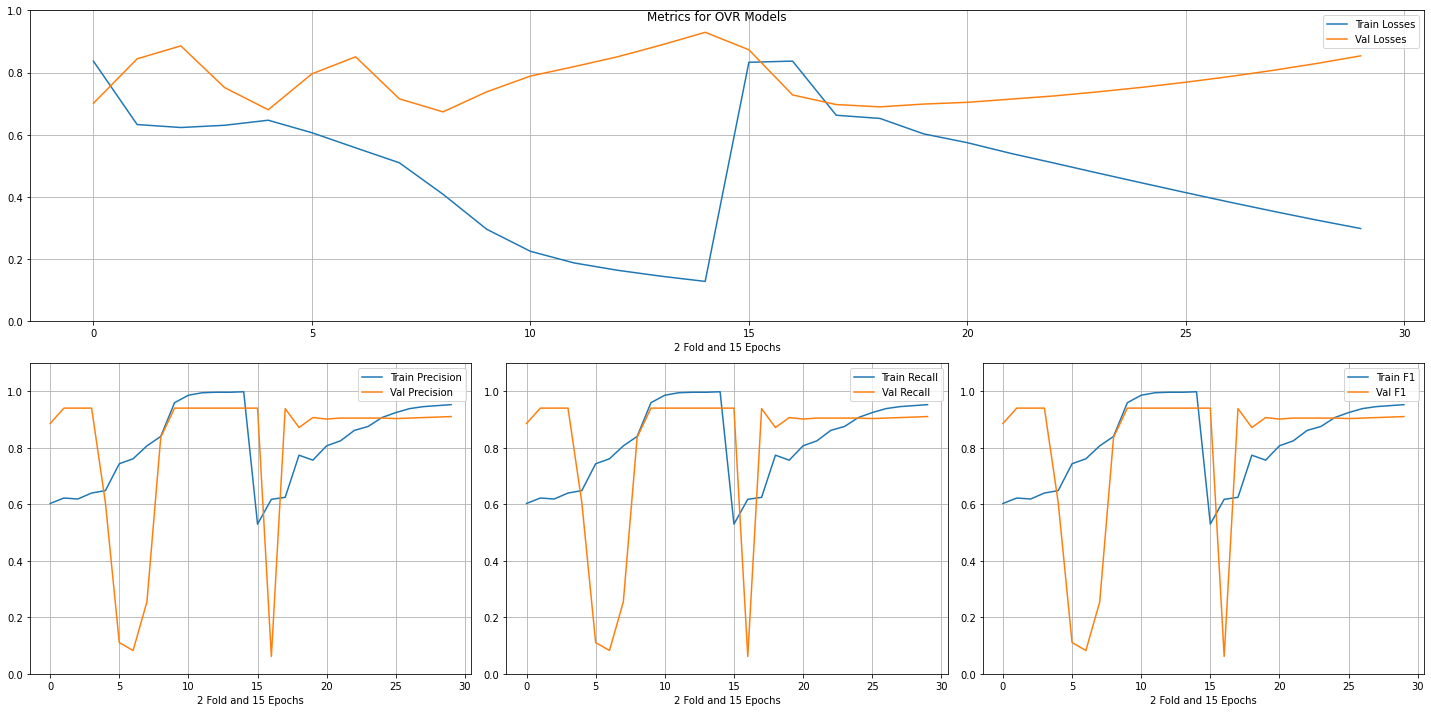

    train_f1  validation_f1  ...  train_losses  validation_losses
11  0.994728       0.940351  ...      0.187475           0.819041
2   0.618629       0.940351  ...      0.623190           0.885861
3   0.639719       0.940351  ...      0.630334           0.751835
1   0.622144       0.940351  ...      0.632759           0.844235
14  0.998243       0.940351  ...      0.128044           0.929467
13  0.996485       0.940351  ...      0.144625           0.888892
12  0.996485       0.940351  ...      0.163734           0.850951
9   0.959578       0.940351  ...      0.295916           0.737975
10  0.985940       0.940351  ...      0.224889           0.788693
0   0.529825       0.940246  ...      0.833074           0.873334
2   0.624561       0.938489  ...      0.662647           0.697004
14  0.952632       0.910369  ...      0.298197           0.853660
13  0.949123       0.908612  ...      0.325232           0.829363
12  0.945614       0.906854  ...      0.353678           0.807164
4   0.7561

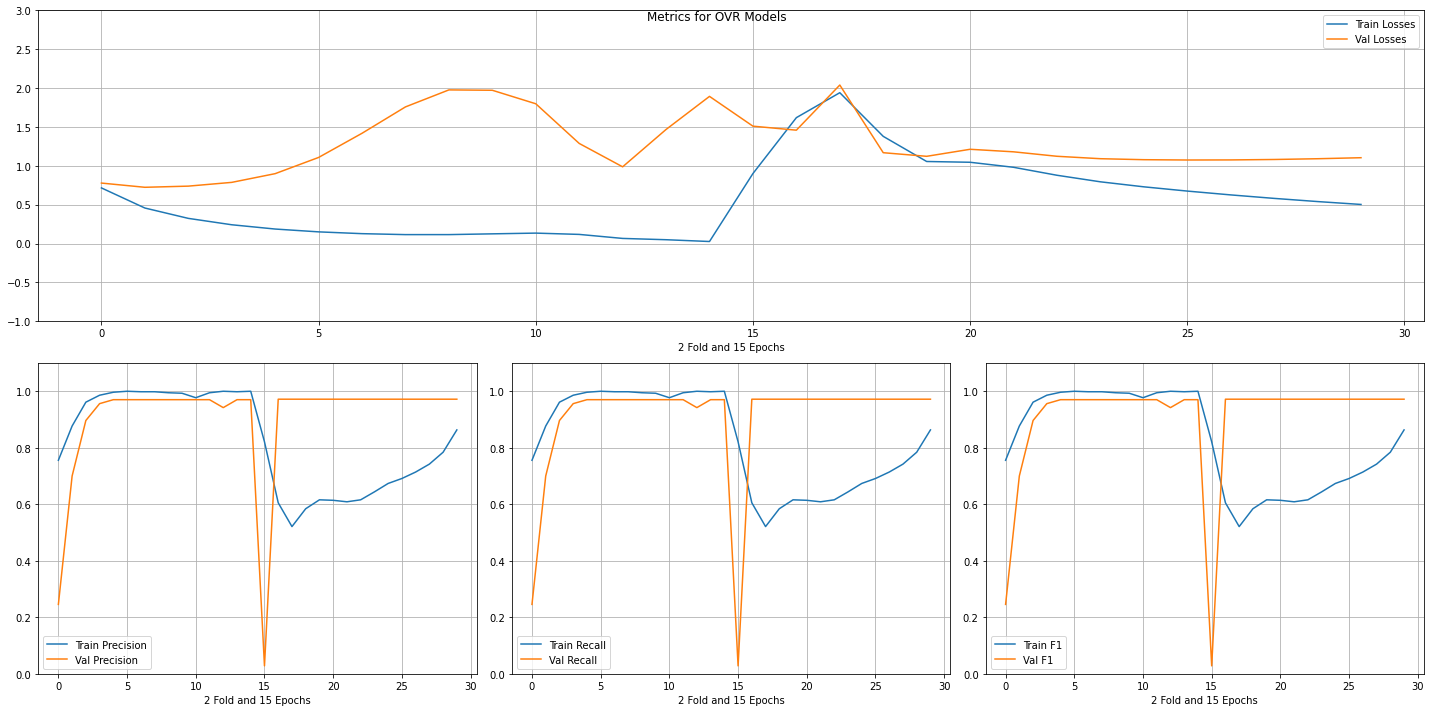

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.863158       0.971880  ...      0.502547           1.104061
13  0.784211       0.971880  ...      0.539780           1.090955
11  0.714035       0.971880  ...      0.625450           1.075674
10  0.691228       0.971880  ...      0.674724           1.074539
9   0.673684       0.971880  ...      0.729417           1.078636
8   0.643860       0.971880  ...      0.793904           1.091343
7   0.615789       0.971880  ...      0.878239           1.122516
6   0.608772       0.971880  ...      0.980796           1.179956
5   0.614035       0.971880  ...      1.045471           1.212558
4   0.615789       0.971880  ...      1.055439           1.122121
3   0.584211       0.971880  ...      1.378879           1.168547
2   0.521053       0.971880  ...      1.940728           2.039340
1   0.605263       0.971880  ...      1.619666           1.458565
12  0.742105       0.971880  ...      0.580598           1.081240
13  0.9982

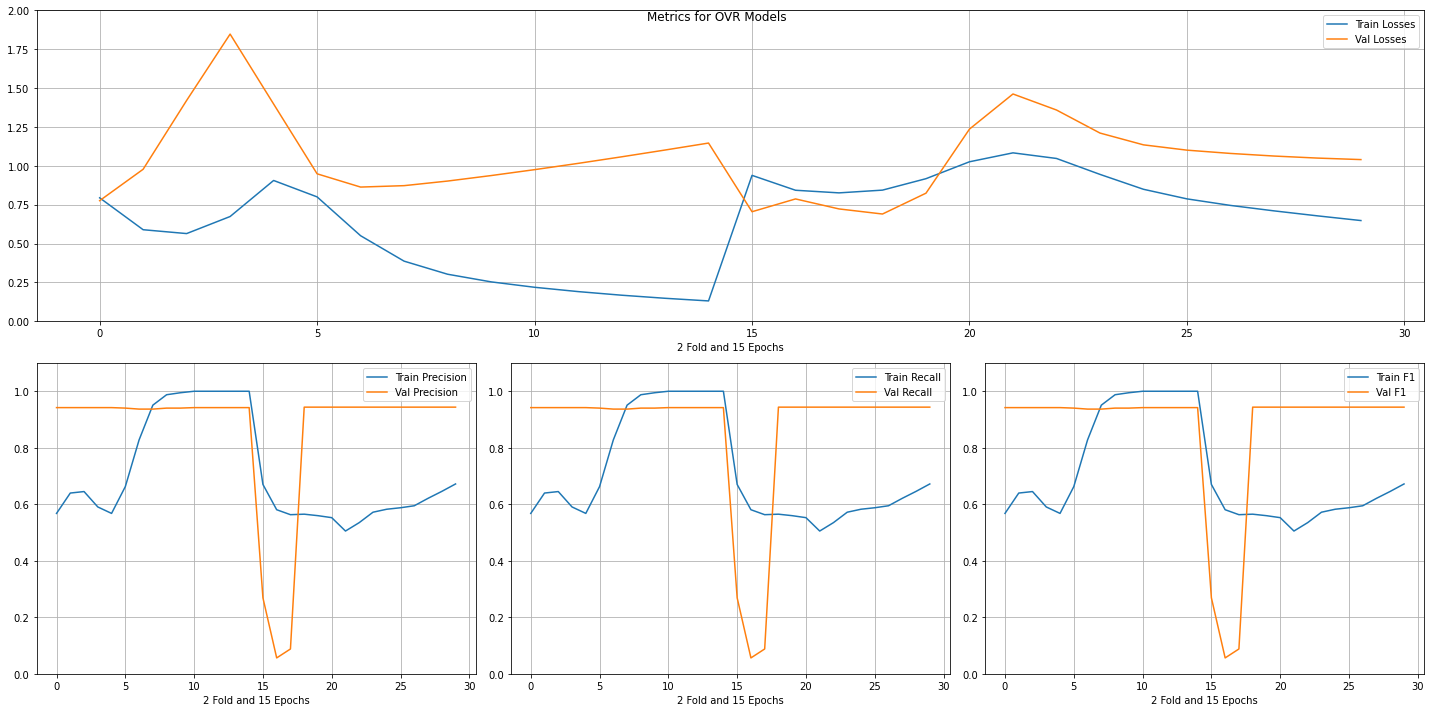

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.671930       0.943761  ...      0.647677           1.039976
13  0.645614       0.943761  ...      0.677912           1.049662
12  0.621053       0.943761  ...      0.710051           1.062828
11  0.594737       0.943761  ...      0.745054           1.079582
10  0.587719       0.943761  ...      0.787155           1.100689
9   0.582456       0.943761  ...      0.848899           1.134825
8   0.571930       0.943761  ...      0.944774           1.210787
7   0.535088       0.943761  ...      1.047241           1.359066
6   0.505263       0.943761  ...      1.083318           1.462125
5   0.552632       0.943761  ...      1.025910           1.236204
4   0.559649       0.943761  ...      0.917107           0.823853
3   0.564912       0.943761  ...      0.843477           0.689699
14  1.000000       0.942105  ...      0.130475           1.146343
1   0.639719       0.942105  ...      0.588670           0.977693
0   0.5676

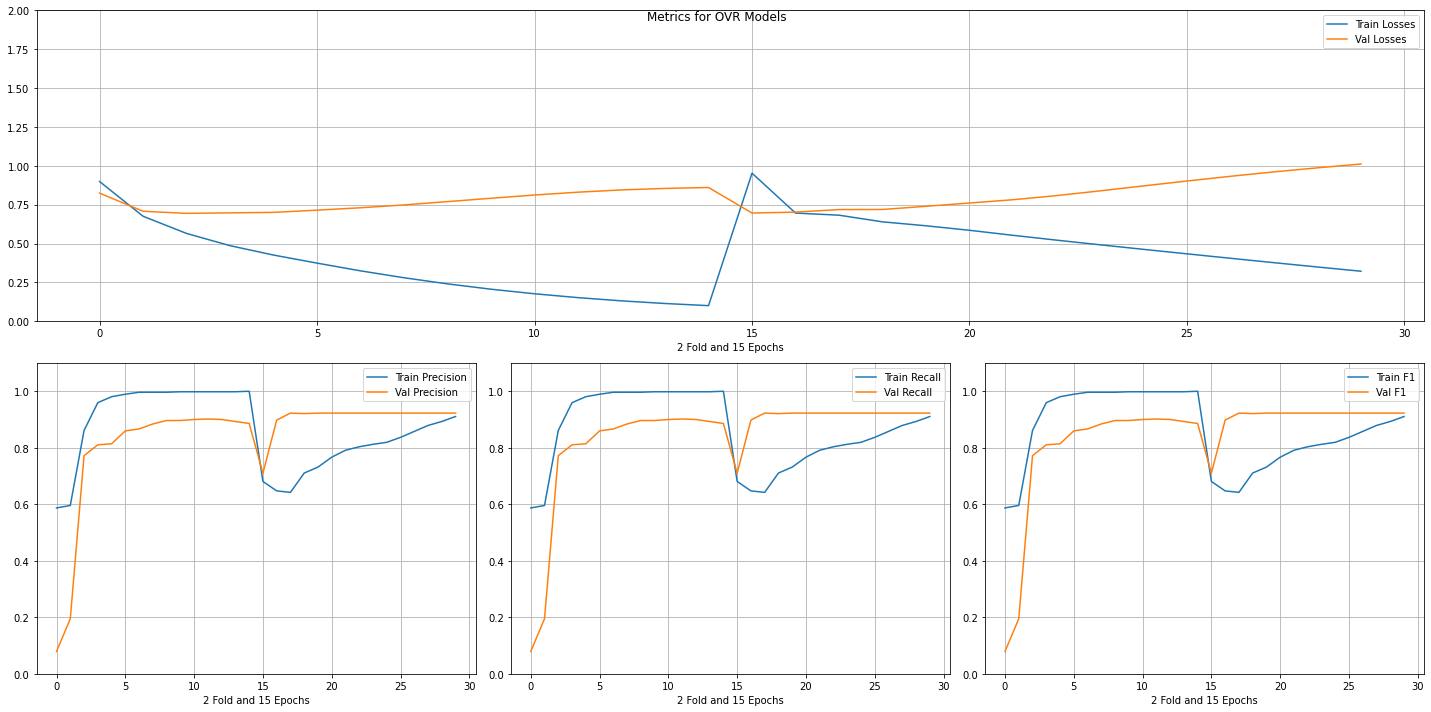

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.910526       0.922671  ...      0.321590           1.011461
12  0.878947       0.922671  ...      0.376664           0.960917
10  0.836842       0.922671  ...      0.433499           0.902009
9   0.819298       0.922671  ...      0.462375           0.870544
8   0.812281       0.922671  ...      0.491715           0.838600
7   0.803509       0.922671  ...      0.521670           0.808082
6   0.791228       0.922671  ...      0.552695           0.781691
5   0.766667       0.922671  ...      0.584971           0.760485
4   0.731579       0.922671  ...      0.614038           0.739448
2   0.642105       0.922671  ...      0.682219           0.718386
13  0.892982       0.922671  ...      0.348829           0.986847
11  0.857895       0.922671  ...      0.404961           0.932442
3   0.710526       0.920914  ...      0.639331           0.718948
11  0.998243       0.901754  ...      0.151630           0.830328
12  0.9982

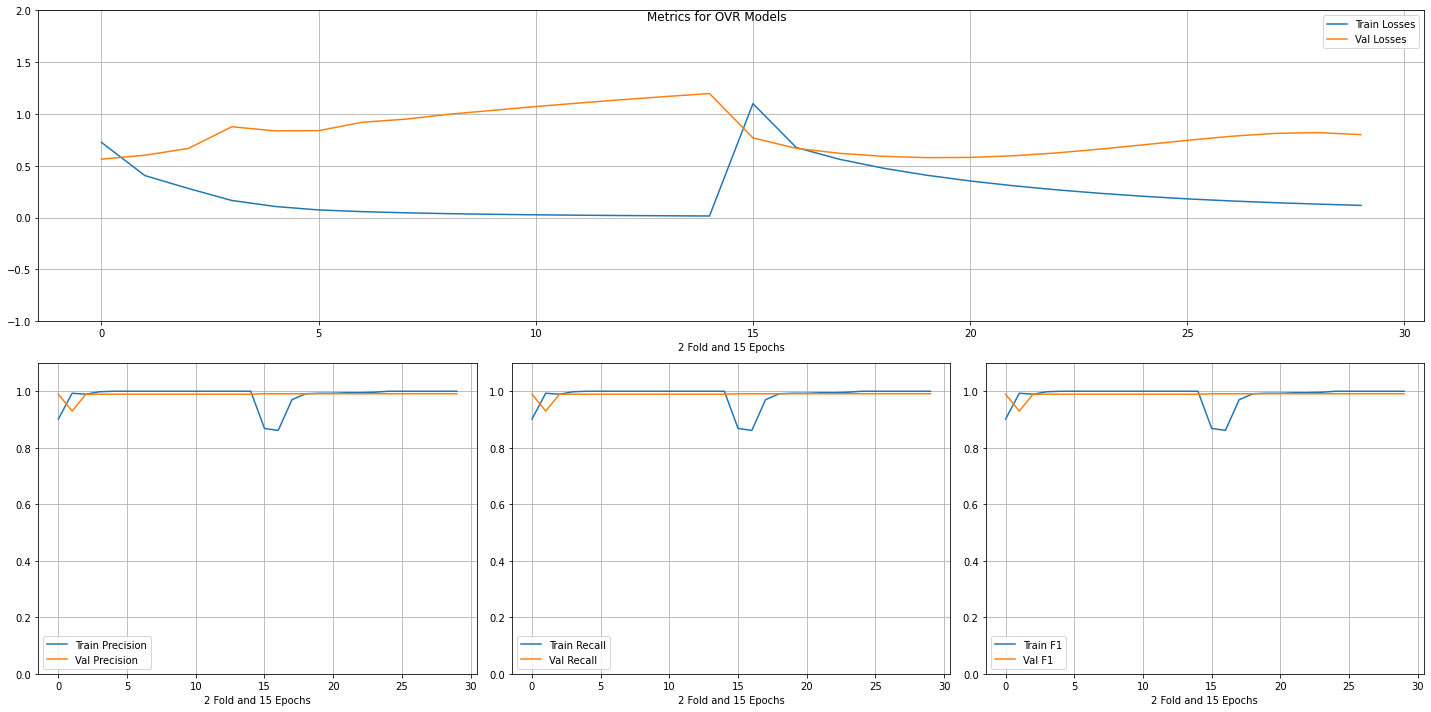

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.868421       0.991213  ...      1.100105           0.768961
1   0.861404       0.991213  ...      0.675728           0.668540
13  1.000000       0.991213  ...      0.130258           0.820430
12  1.000000       0.991213  ...      0.144156           0.812321
11  1.000000       0.991213  ...      0.160719           0.784485
10  1.000000       0.991213  ...      0.180945           0.745629
9   1.000000       0.991213  ...      0.205382           0.702839
8   0.996491       0.991213  ...      0.234123           0.661288
7   0.994737       0.991213  ...      0.267702           0.624619
6   0.994737       0.991213  ...      0.307161           0.596731
5   0.992982       0.991213  ...      0.353626           0.580938
4   0.992982       0.991213  ...      0.408937           0.578733
3   0.991228       0.991213  ...      0.476989           0.591505
2   0.970175       0.991213  ...      0.562438           0.620401
14  1.0000

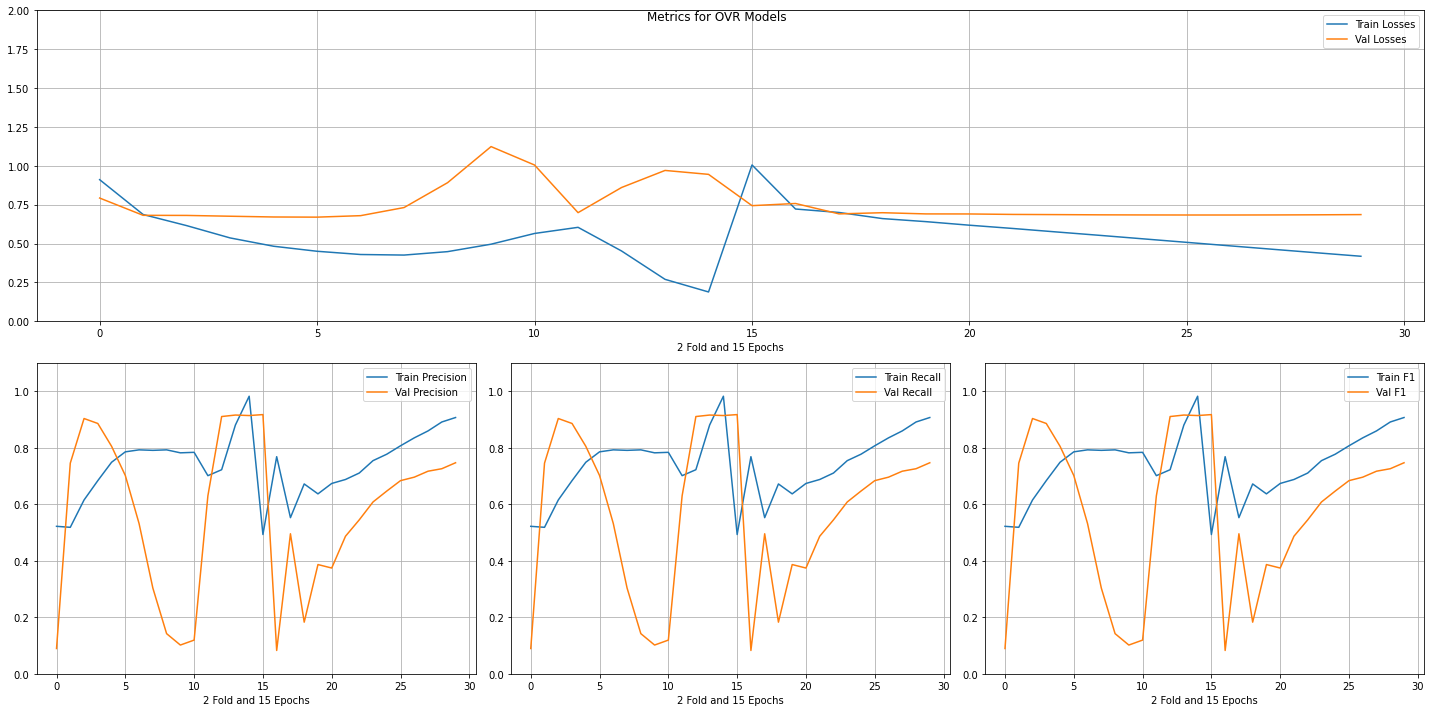

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.492982       0.917399  ...      1.005417           0.743485
13  0.880492       0.915789  ...      0.269335           0.970165
14  0.982425       0.914035  ...      0.188135           0.944929
12  0.722320       0.910526  ...      0.451863           0.860304
2   0.615114       0.903509  ...      0.615087           0.680663
3   0.683656       0.885965  ...      0.535857           0.675475
4   0.748682       0.805263  ...      0.482348           0.670621
14  0.907018       0.746924  ...      0.417905           0.686023
1   0.518453       0.745614  ...      0.686526           0.681311
13  0.891228       0.725835  ...      0.439885           0.684666
12  0.859649       0.717047  ...      0.462177           0.683773
5   0.785589       0.701754  ...      0.449999           0.669588
11  0.835088       0.695958  ...      0.484691           0.683347
10  0.807018       0.683656  ...      0.507285           0.683362
9   0.7771

In [60]:
le = LabelEncoder()
le.fit(data['Ragam'])
labels = le.transform(le.classes_)
ovr_res = ovr_train_model(data, MfccMatrixDataset, MfccRaga, "OVR Models", labels, le.classes_, lbl_encoder=le, lr=1e-4, epochs=15, n_folds=2)

In [62]:
for k in ovr_res:
  print(le.inverse_transform([k]))
  print(results_to_df(ovr_res[k]).head())

['ఆహిరి']
    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.654386       0.961336  ...      0.853774           0.650725
12  1.000000       0.959649  ...      0.081868           1.271512
14  1.000000       0.959649  ...      0.055717           1.548482
13  1.000000       0.959649  ...      0.065874           1.424264
6   0.992970       0.959649  ...      0.222348           1.219988

[5 rows x 8 columns]
['కన్నడగౌళ']
    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.987698  ...      0.197648           0.866642
13  0.998246       0.987698  ...      0.229293           0.824407
12  0.996491       0.987698  ...      0.263764           0.771499
11  0.992982       0.987698  ...      0.300339           0.717608
10  0.984211       0.987698  ...      0.340230           0.671512

[5 rows x 8 columns]
['కాంబోది']
    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.824561       0.984183  ...      0.858972           0.6003

# Mapping each Raga with Janaka Ragam

In [64]:
janaka_raga_map ={'లలిత':'Mayamalavagowla',
'సాళంగనాట':'Mayamalavagowla',
'సామంతం':'Naganandini',
'బౌళి':'Mayamalavagowla',
'శంకరాభరణం':'Shankarabharanam',
'శ్రీరాగం':'Kharaharapriya',
'రామక్రియ':'Mayamalavagowla',
'ముఖారి':'Kharaharapriya',
'పాడి':'Mayamalavagowla',
'ఆహిరి':'Vakulabharanam',
'దేసాళం':'Unknown',
'దేవగాంధారి':'Shankarabharanam',
'శుద్ధవసంతం':'Shankarabharanam',
'భూపాలం':'Shubhapantuvarali',
'దేసాక్షి':'Harikambhoji',
'గుండుక్రియ':'Mayamalavagowla',
'భైరవి':'Natabhairavi',
'నాట':'Chalanata',
'వరాళి':'Jhalavarali',
'ధన్నాసి':'Hanumatodi',
'మలహరి':'Mayamalavagowla',
'కాంబోది':'Harikambhoji',
'మాళవిగౌళ':'Mayamalavagowla',
'మాళవి':'Harikambhoji',
'గుజ్జరి':'Unknown',
'కన్నడగౌళ':'Kharaharapriya',
'గౌళ':'Mayamalavagowla',
'బౌళిరామక్రియ':'Mayamalavagowla',
'నాదరామక్రియ':'Unknown',
'సాళంగం':'Kalyani'}

In [65]:
data['janaka_ragam'] = data.apply(lambda x:janaka_raga_map[x['Ragam']],axis=1)

In [66]:
jle = LabelEncoder()
jle.fit(data['janaka_ragam'])
data['JanakaRagamCode'] = data.apply(lambda x:jle.transform([x.janaka_ragam])[0],axis=1)
n_labels = len(data['RagamCode'].unique())

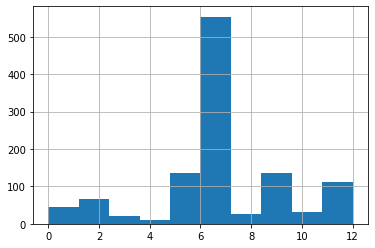

In [67]:
data['JanakaRagamCode'].hist()

In [68]:
class MfccMatrixJanakaRagaDataset(AbsDataset):
    def __init__(self, labels, mfcc_vals):
        super().__init__()
        self.labels = labels
        self.mfcc_vals = mfcc_vals

    def __get__(self,index):
      if self.mfcc_vals[index].shape[1] < 9601:
        self.mfcc_vals[index] = torch.hstack((self.mfcc_vals[index],torch.zeros(40,9601-self.mfcc_vals[index].shape[1])))
      return self.mfcc_vals[index].reshape((1,)+self.mfcc_vals[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['JanakaRagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['JanakaRagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['mfcc'].iloc[x] for x in train_ids]
      test_vals = [data['mfcc'].iloc[x] for x in test_ids]
      train_data = MfccMatrixDataset(train_lbls, train_vals)
      test_data = MfccMatrixDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

Training for ['Chalanata'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 569/570
Class Weights : [ 0.51122083 22.78      ]
Epoch 1/15 : Training Loss: 1.299 / Validation Loss : 0.815 [Time Taken : 1.895236 seconds]
Epoch 2/15 : Training Loss: 0.598 / Validation Loss : 0.710 [Time Taken : 1.887367 seconds]
Epoch 3/15 : Training Loss: 0.407 / Validation Loss : 0.737 [Time Taken : 1.897241 seconds]
Epoch 4/15 : Training Loss: 0.317 / Validation Loss : 0.766 [Time Taken : 1.904018 seconds]
Epoch 5/15 : Training Loss: 0.256 / Validation Loss : 0.816 [Time Taken : 1.895023 seconds]
Epoch 6/15 : Training Loss: 0.207 / Validation Loss : 0.894 [Time Taken : 1.896555 seconds]
Epoch 7/15 : Training Loss: 0.168 / Validation Loss : 0.983 [Time Taken : 1.905125 seconds]
Epoch 8/15 : Training Loss: 0.137 / Validation Loss : 1.052 [Time Taken : 1.900385 seconds]
Epoch 9/15 : Training Loss: 0.114 / Validation Loss : 1.096 [Time Taken : 1.904832 seconds]
Epoch 10/15 : Training Loss: 0.096 

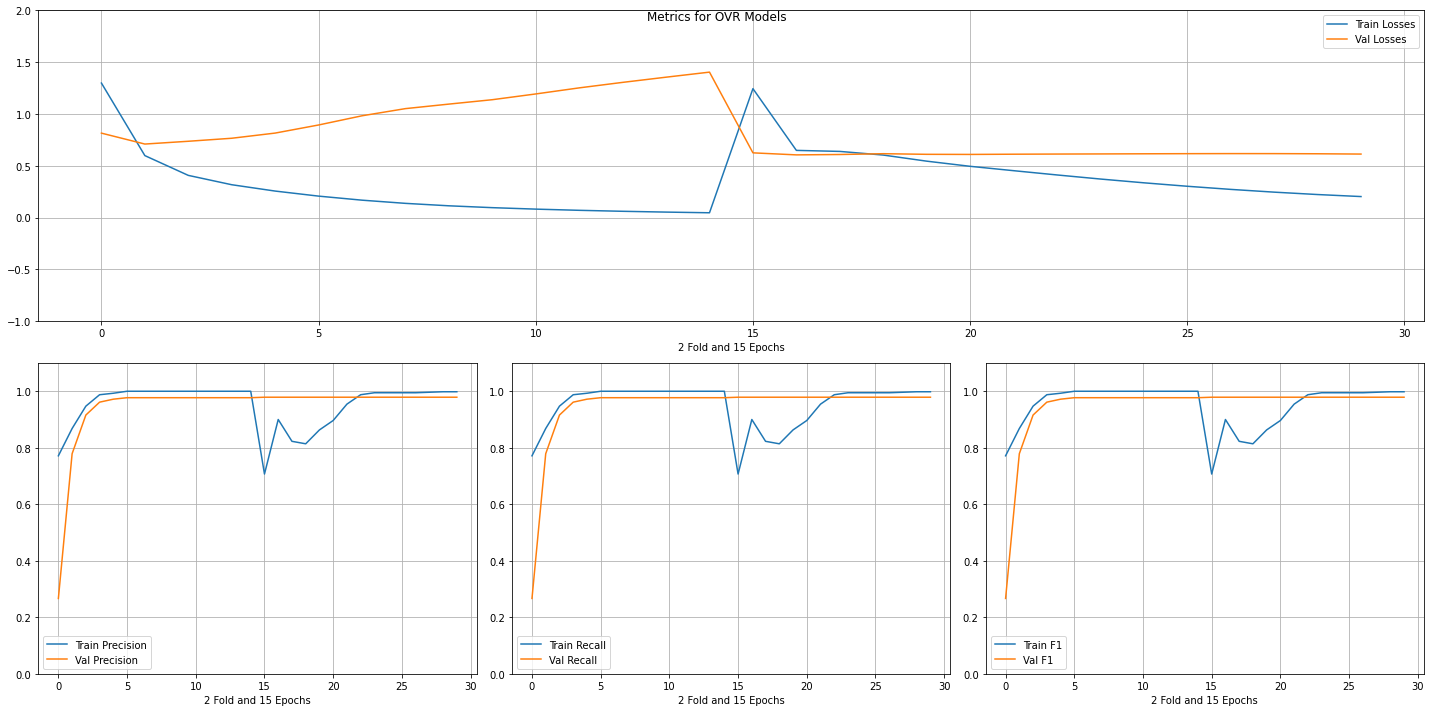

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.707018       0.978910  ...      1.244575           0.625052
1   0.900000       0.978910  ...      0.648820           0.605420
13  0.998246       0.978910  ...      0.222608           0.616178
12  0.996491       0.978910  ...      0.245691           0.617566
11  0.994737       0.978910  ...      0.272354           0.617746
10  0.994737       0.978910  ...      0.302469           0.617095
9   0.994737       0.978910  ...      0.335841           0.615938
8   0.994737       0.978910  ...      0.372287           0.614536
7   0.987719       0.978910  ...      0.411709           0.613370
6   0.954386       0.978910  ...      0.452899           0.611902
5   0.896491       0.978910  ...      0.495044           0.609781
4   0.863158       0.978910  ...      0.544817           0.610814
3   0.814035       0.978910  ...      0.603744           0.616773
2   0.822807       0.978910  ...      0.638877           0.609020
14  0.9982

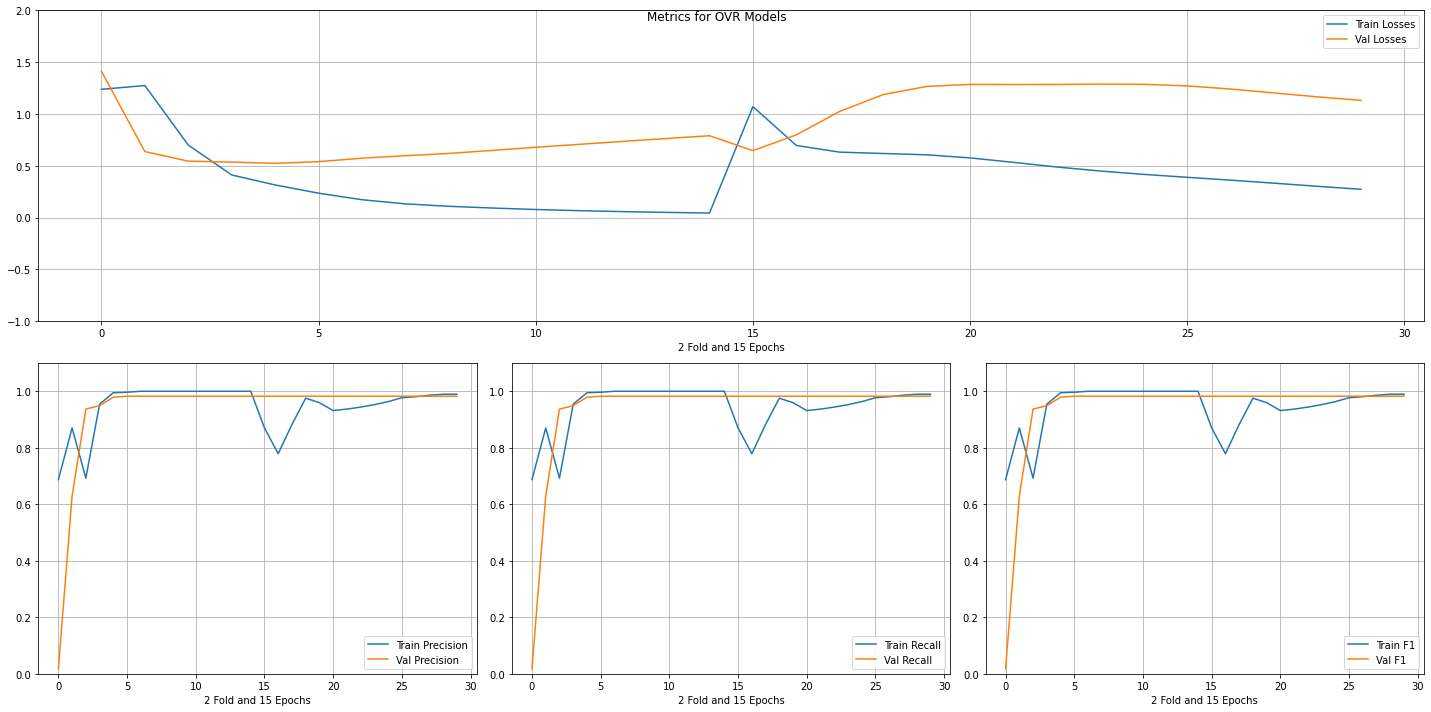

    train_f1  validation_f1  ...  train_losses  validation_losses
10  1.000000       0.982456  ...      0.078192           0.678802
14  1.000000       0.982456  ...      0.044129           0.790169
5   0.996485       0.982456  ...      0.235719           0.539921
6   1.000000       0.982456  ...      0.172513           0.573567
7   1.000000       0.982456  ...      0.132458           0.597366
8   1.000000       0.982456  ...      0.109174           0.619320
9   1.000000       0.982456  ...      0.092339           0.648895
11  1.000000       0.982456  ...      0.066841           0.707065
12  1.000000       0.982456  ...      0.057769           0.735537
13  1.000000       0.982456  ...      0.050301           0.763207
7   0.943860       0.982425  ...      0.488296           1.285264
8   0.952632       0.982425  ...      0.449329           1.288682
9   0.963158       0.982425  ...      0.417055           1.286433
10  0.977193       0.982425  ...      0.388888           1.270859
0   0.8701

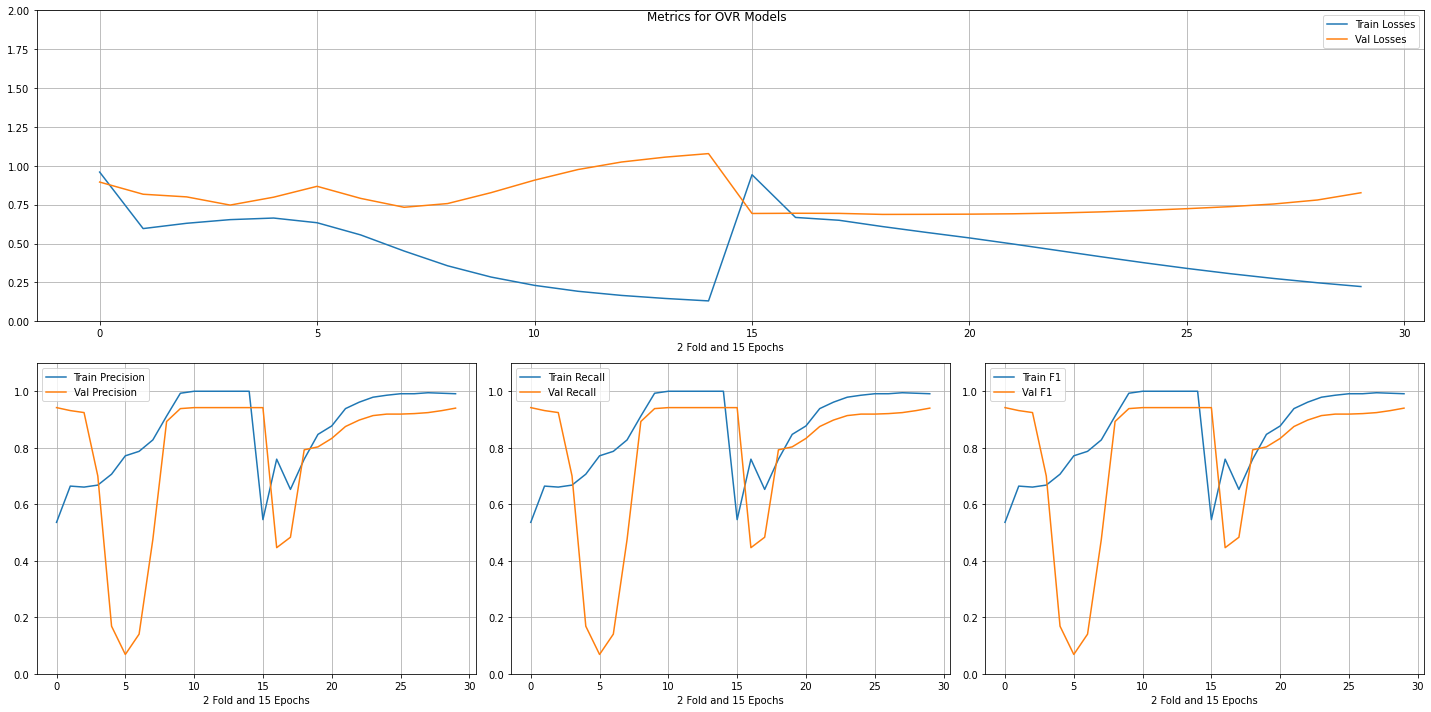

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.536028       0.942105  ...      0.959643           0.895379
10  1.000000       0.942105  ...      0.230598           0.907602
14  1.000000       0.942105  ...      0.130595           1.078456
13  1.000000       0.942105  ...      0.146435           1.055660
12  1.000000       0.942105  ...      0.165903           1.024389
11  1.000000       0.942105  ...      0.192500           0.976004
0   0.545614       0.942004  ...      0.942554           0.693179
14  0.991228       0.940246  ...      0.222970           0.826521
9   0.992970       0.938596  ...      0.284083           0.827213
1   0.664323       0.931579  ...      0.595993           0.817016
13  0.992982       0.931459  ...      0.247404           0.779987
2   0.660808       0.924561  ...      0.630079           0.799989
12  0.994737       0.924429  ...      0.274837           0.754261
11  0.991228       0.920914  ...      0.305639           0.737316
10  0.9912

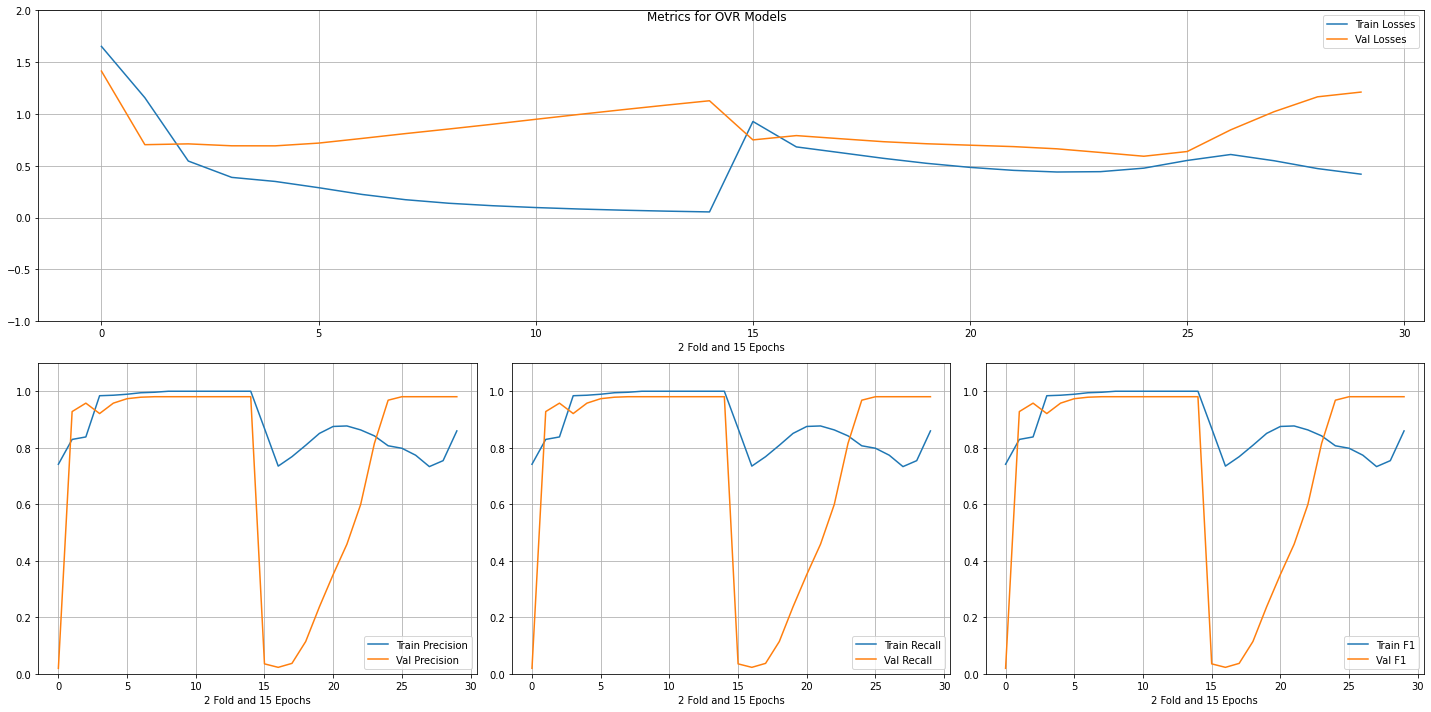

    train_f1  validation_f1  ...  train_losses  validation_losses
13  1.000000       0.980702  ...      0.062366           1.085426
11  1.000000       0.980702  ...      0.082896           0.996000
14  1.000000       0.980702  ...      0.054770           1.127776
12  1.000000       0.980702  ...      0.071568           1.041459
7   0.996485       0.980702  ...      0.172760           0.810864
8   1.000000       0.980702  ...      0.138406           0.855134
9   1.000000       0.980702  ...      0.114816           0.900917
10  1.000000       0.980702  ...      0.097022           0.948867
10  0.798246       0.980668  ...      0.551696           0.637954
13  0.754386       0.980668  ...      0.473117           1.165867
12  0.733333       0.980668  ...      0.548776           1.022412
14  0.859649       0.980668  ...      0.419209           1.211634
11  0.773684       0.980668  ...      0.609063           0.847008
6   0.994728       0.978947  ...      0.223617           0.764190
5   0.9894

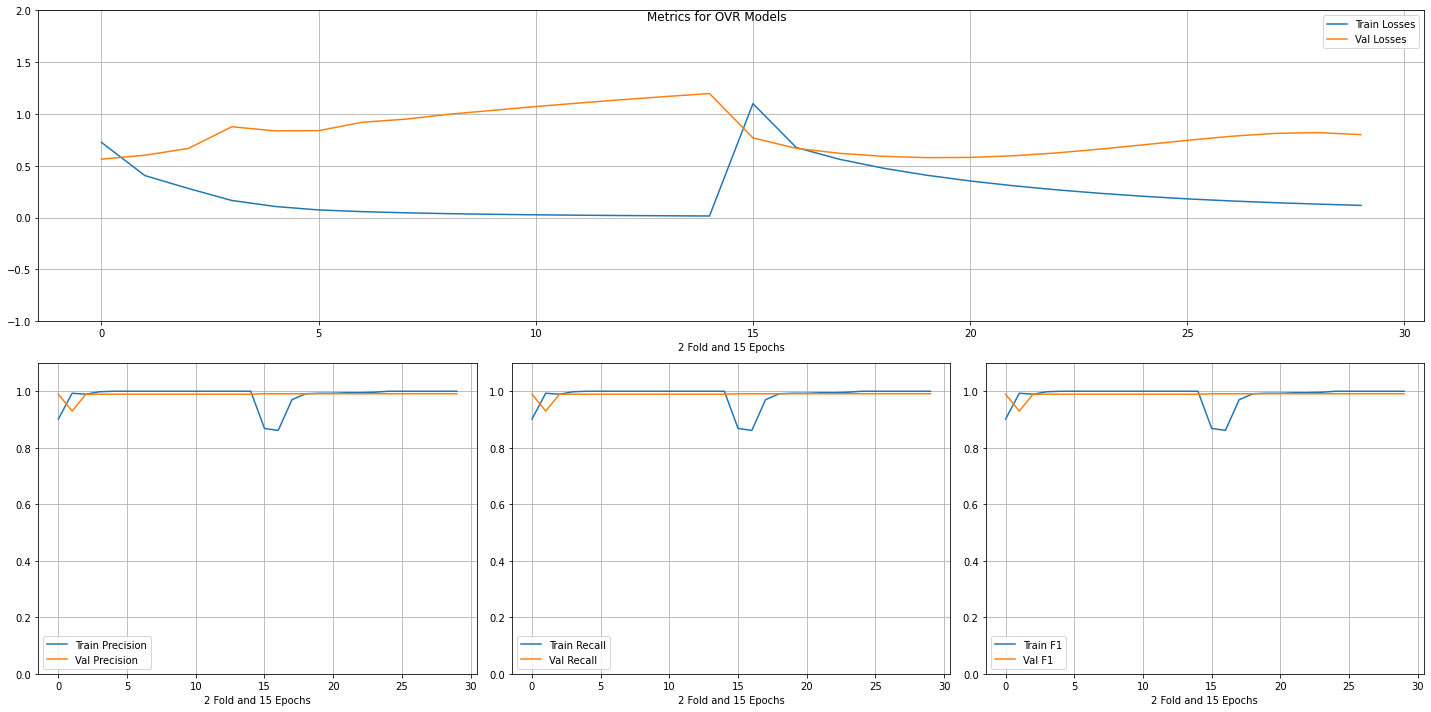

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.868421       0.991213  ...      1.100105           0.768961
1   0.861404       0.991213  ...      0.675728           0.668540
13  1.000000       0.991213  ...      0.130258           0.820430
12  1.000000       0.991213  ...      0.144156           0.812321
11  1.000000       0.991213  ...      0.160719           0.784485
10  1.000000       0.991213  ...      0.180945           0.745629
9   1.000000       0.991213  ...      0.205382           0.702839
8   0.996491       0.991213  ...      0.234123           0.661288
7   0.994737       0.991213  ...      0.267702           0.624619
6   0.994737       0.991213  ...      0.307161           0.596731
5   0.992982       0.991213  ...      0.353626           0.580938
4   0.992982       0.991213  ...      0.408937           0.578733
3   0.991228       0.991213  ...      0.476989           0.591505
2   0.970175       0.991213  ...      0.562438           0.620401
14  1.0000

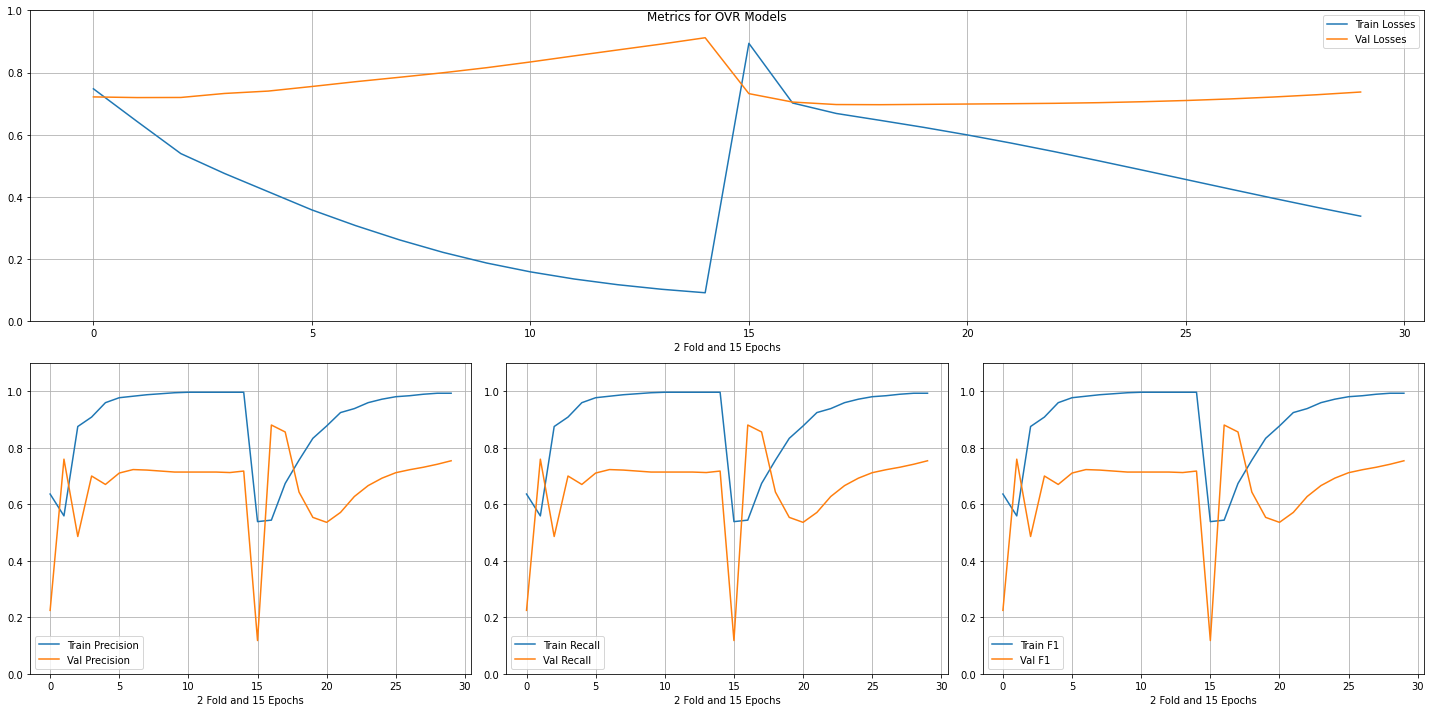

    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.543860       0.880492  ...      0.702053           0.705107
2   0.673684       0.855888  ...      0.668425           0.697080
1   0.558875       0.759649  ...      0.642530           0.719511
14  0.992982       0.753954  ...      0.337963           0.737395
13  0.992982       0.741652  ...      0.366262           0.728687
12  0.989474       0.731107  ...      0.395562           0.721302
6   0.982425       0.722807  ...      0.307547           0.770587
11  0.984211       0.722320  ...      0.425587           0.715074
7   0.987698       0.721053  ...      0.261844           0.784746
14  0.996485       0.717544  ...      0.091502           0.912053
8   0.991213       0.717544  ...      0.221497           0.799380
10  0.996485       0.714035  ...      0.158761           0.834099
12  0.996485       0.714035  ...      0.117389           0.872762
9   0.994728       0.714035  ...      0.187149           0.815678
11  0.9964

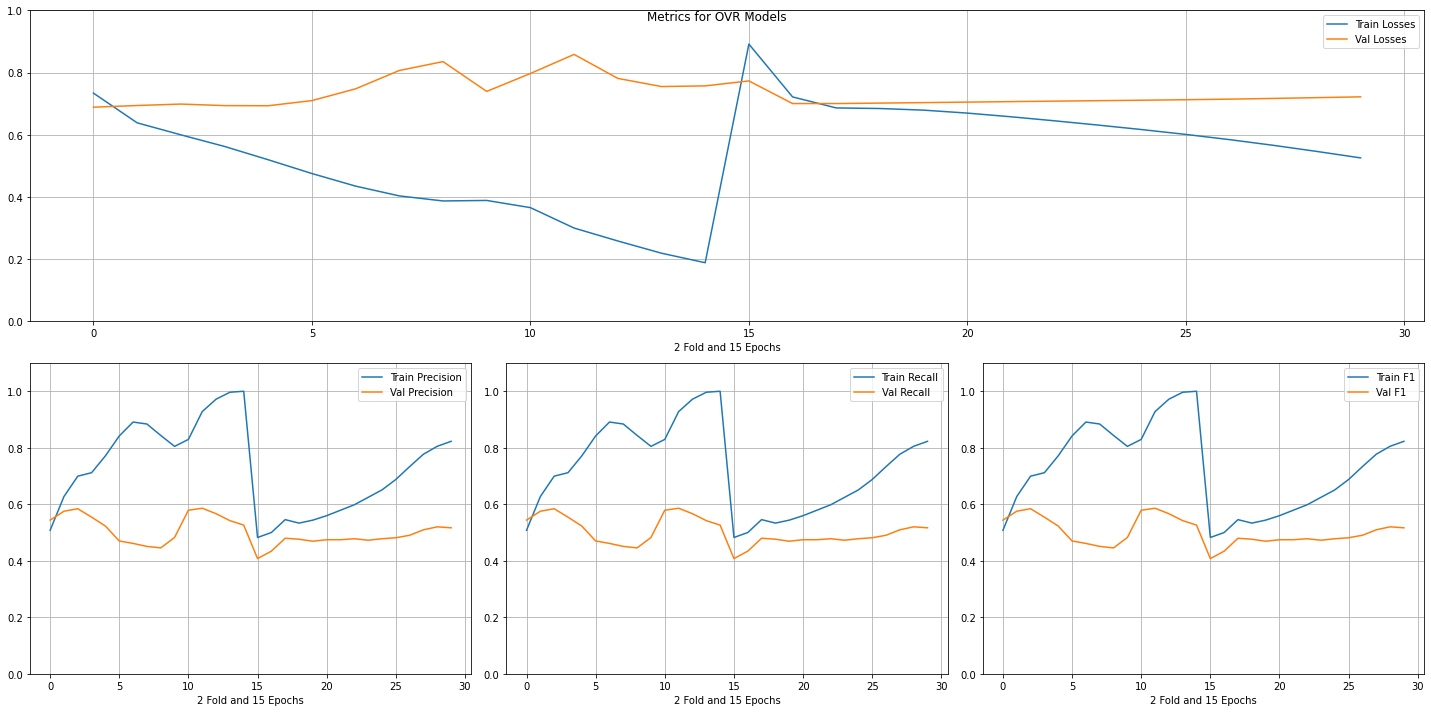

    train_f1  validation_f1  ...  train_losses  validation_losses
11  0.927944       0.585965  ...      0.299709           0.858416
2   0.699473       0.584211  ...      0.599676           0.698619
10  0.829525       0.578947  ...      0.365428           0.797011
1   0.627417       0.575439  ...      0.638266           0.693969
12  0.971880       0.566667  ...      0.258122           0.781235
3   0.711775       0.554386  ...      0.562257           0.693669
0   0.507909       0.543860  ...      0.733866           0.688620
13  0.996485       0.542105  ...      0.218785           0.755018
14  1.000000       0.526316  ...      0.188180           0.757147
4   0.771529       0.522807  ...      0.519471           0.693227
13  0.805263       0.520211  ...      0.546178           0.719309
14  0.822807       0.516696  ...      0.525448           0.721867
12  0.777193       0.509666  ...      0.565921           0.716771
11  0.733333       0.490334  ...      0.584205           0.714462
9   0.8049

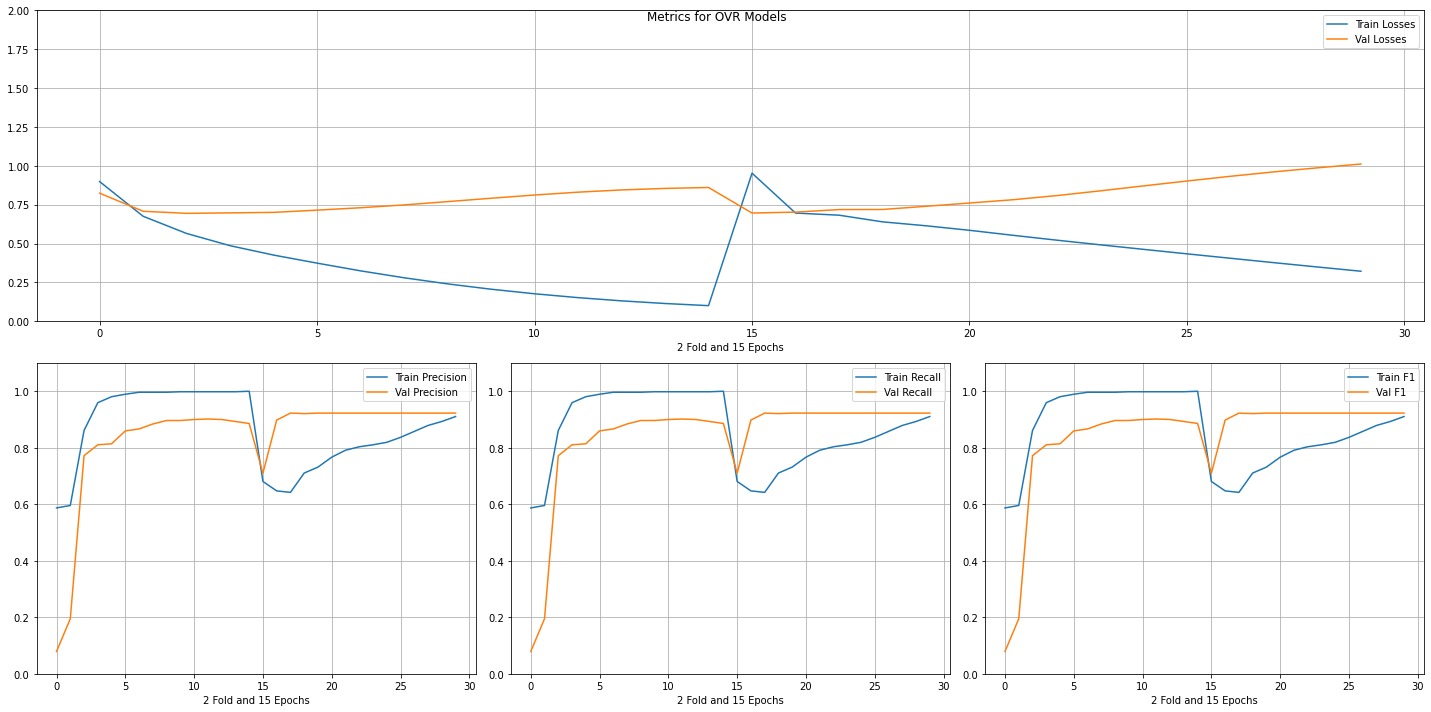

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.910526       0.922671  ...      0.321591           1.011461
12  0.878947       0.922671  ...      0.376665           0.960918
10  0.836842       0.922671  ...      0.433500           0.902011
9   0.819298       0.922671  ...      0.462376           0.870544
8   0.810526       0.922671  ...      0.491716           0.838599
7   0.803509       0.922671  ...      0.521670           0.808081
6   0.791228       0.922671  ...      0.552695           0.781691
5   0.766667       0.922671  ...      0.584971           0.760485
4   0.731579       0.922671  ...      0.614038           0.739448
2   0.642105       0.922671  ...      0.682219           0.718386
13  0.892982       0.922671  ...      0.348829           0.986849
11  0.857895       0.922671  ...      0.404962           0.932443
3   0.710526       0.920914  ...      0.639331           0.718948
11  0.998243       0.901754  ...      0.151629           0.830329
12  0.9982

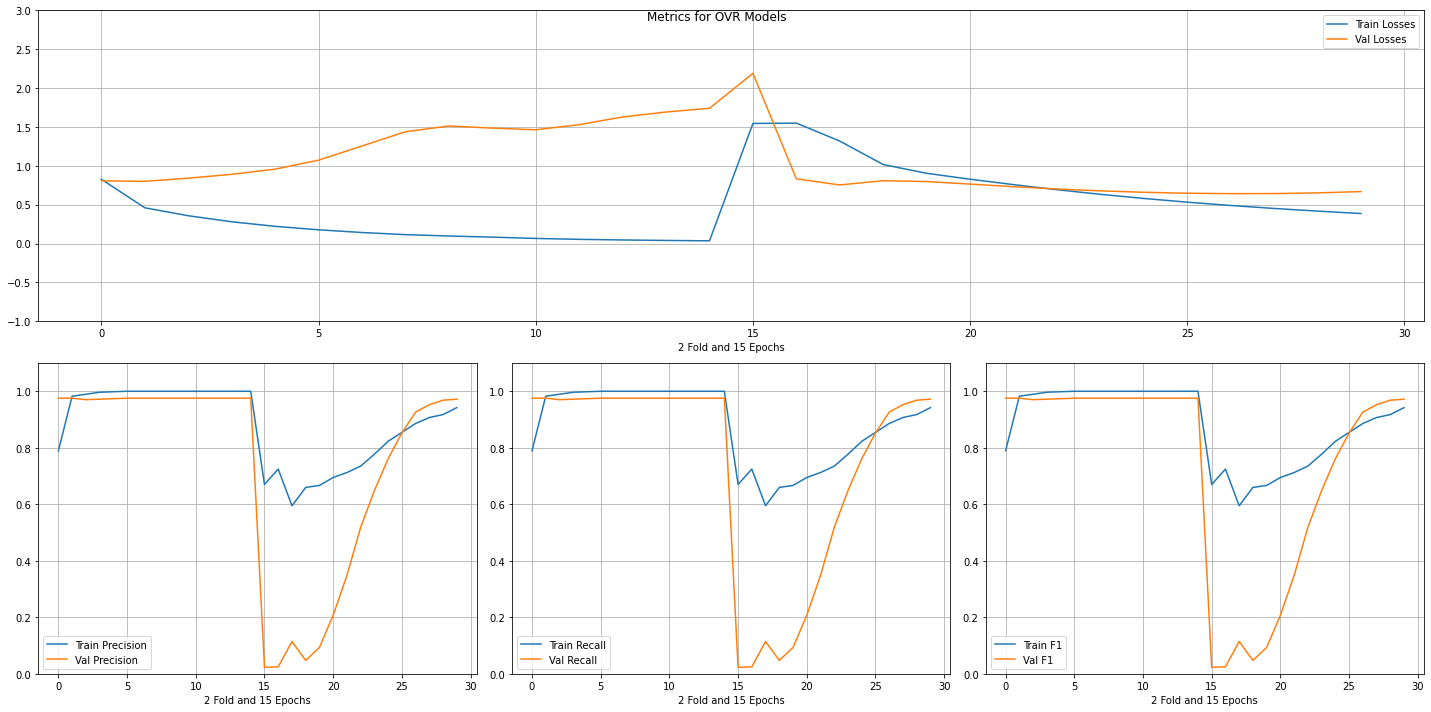

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.789104       0.975439  ...      0.825974           0.806451
14  1.000000       0.975439  ...      0.034437           1.740003
1   0.982425       0.975439  ...      0.459471           0.800165
5   1.000000       0.975439  ...      0.176385           1.072836
6   1.000000       0.975439  ...      0.141360           1.255079
7   1.000000       0.975439  ...      0.113998           1.438395
8   1.000000       0.975439  ...      0.096464           1.512368
9   1.000000       0.975439  ...      0.081841           1.484936
10  1.000000       0.975439  ...      0.065176           1.463874
11  1.000000       0.975439  ...      0.053494           1.529656
12  1.000000       0.975439  ...      0.045591           1.628474
13  1.000000       0.975439  ...      0.039369           1.692078
4   0.998243       0.973684  ...      0.220822           0.957192
3   0.996485       0.971930  ...      0.279583           0.890371
14  0.9421

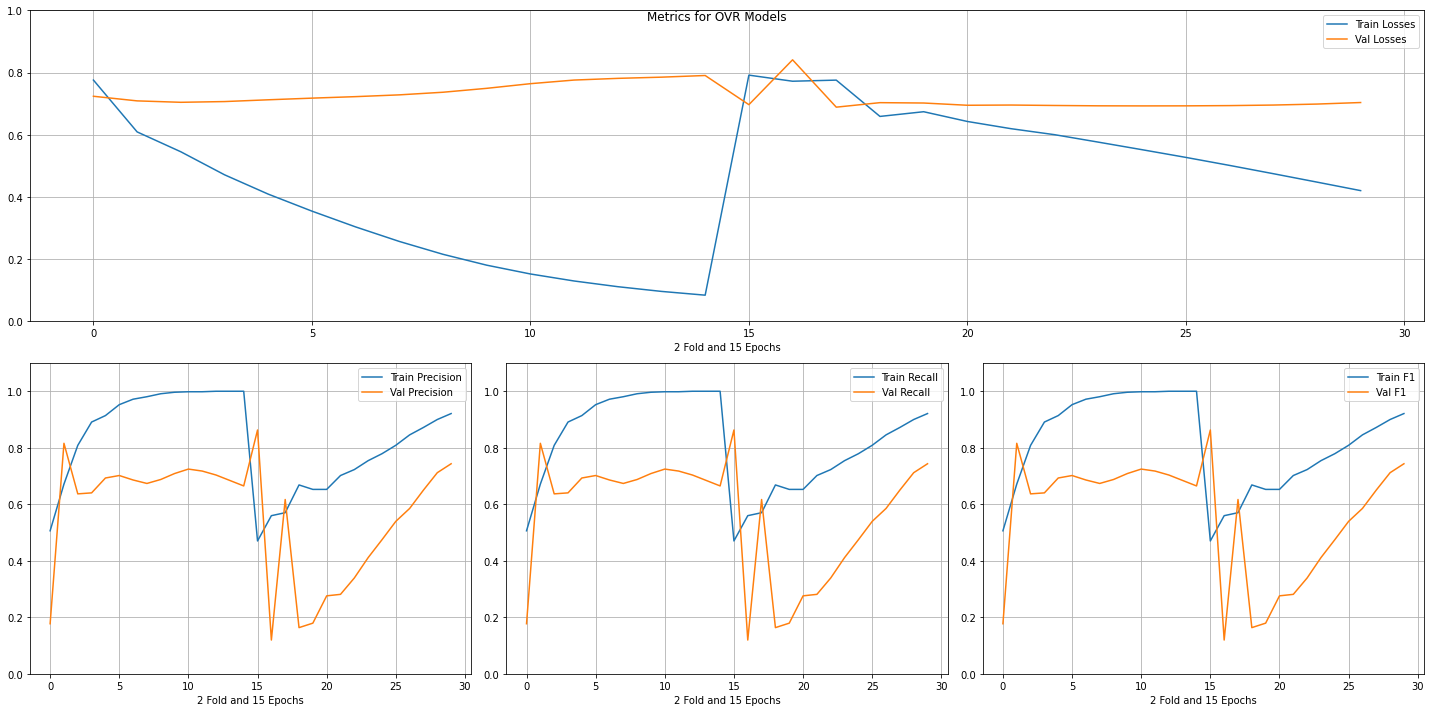

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.470175       0.862917  ...      0.791737           0.696713
1   0.671353       0.815789  ...      0.609041           0.708883
14  0.921053       0.743409  ...      0.420149           0.703576
10  0.998243       0.724561  ...      0.151958           0.764225
11  0.998243       0.717544  ...      0.129386           0.775873
13  0.900000       0.711775  ...      0.447551           0.698614
9   0.996485       0.708772  ...      0.180254           0.749258
12  1.000000       0.703509  ...      0.111042           0.781329
5   0.952548       0.701754  ...      0.354172           0.717688
4   0.913884       0.692982  ...      0.408881           0.712378
8   0.991213       0.687719  ...      0.215222           0.736674
6   0.971880       0.685965  ...      0.303384           0.722519
13  1.000000       0.684211  ...      0.095860           0.785184
7   0.980668       0.673684  ...      0.256634           0.728236
14  1.0000

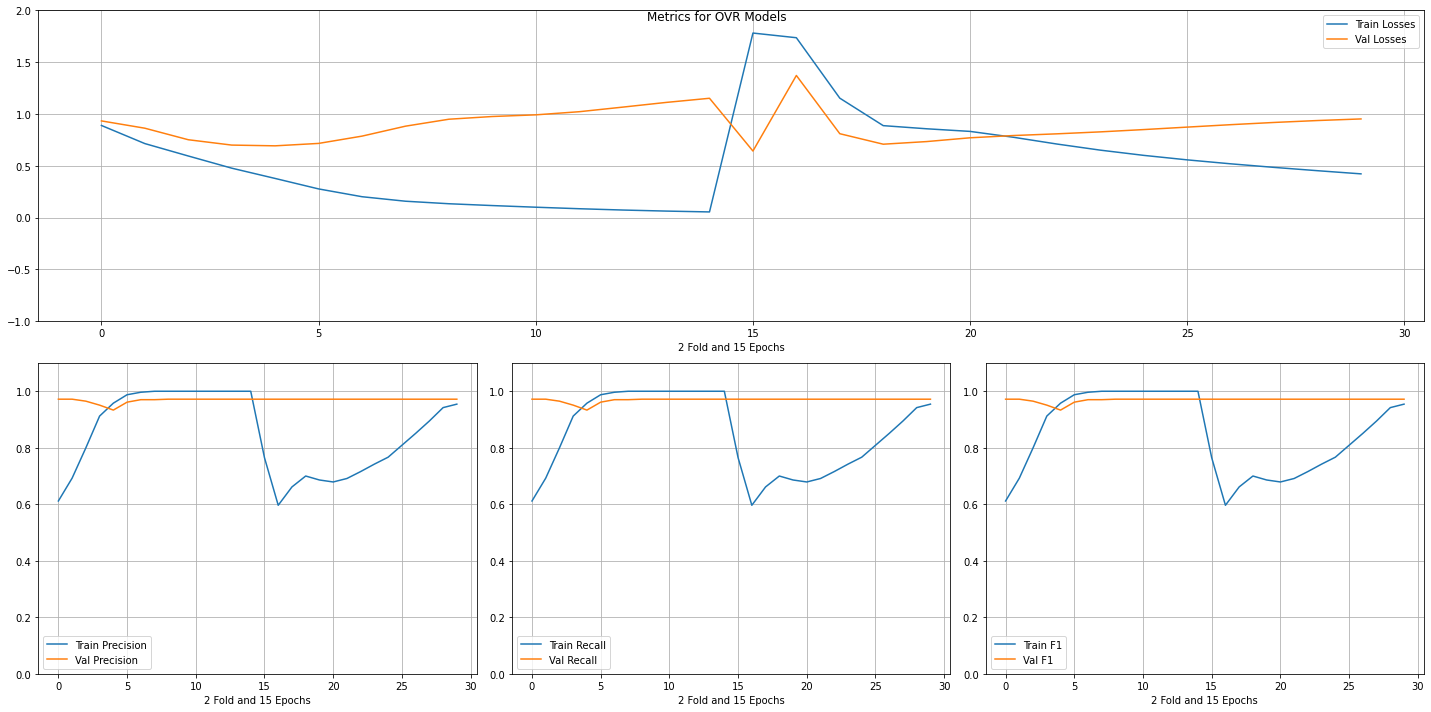

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.611599       0.971930  ...      0.889381           0.933347
8   1.000000       0.971930  ...      0.133790           0.949581
1   0.692443       0.971930  ...      0.714385           0.862811
14  1.000000       0.971930  ...      0.054750           1.151834
13  1.000000       0.971930  ...      0.062920           1.111640
12  1.000000       0.971930  ...      0.073077           1.066293
11  1.000000       0.971930  ...      0.085663           1.022040
10  1.000000       0.971930  ...      0.100273           0.991812
9   1.000000       0.971930  ...      0.116173           0.975823
4   0.685965       0.971880  ...      0.857357           0.733866
8   0.742105       0.971880  ...      0.651007           0.827523
9   0.766667       0.971880  ...      0.600566           0.849685
10  0.808772       0.971880  ...      0.557223           0.873487
11  0.850877       0.971880  ...      0.519126           0.896909
12  0.8947

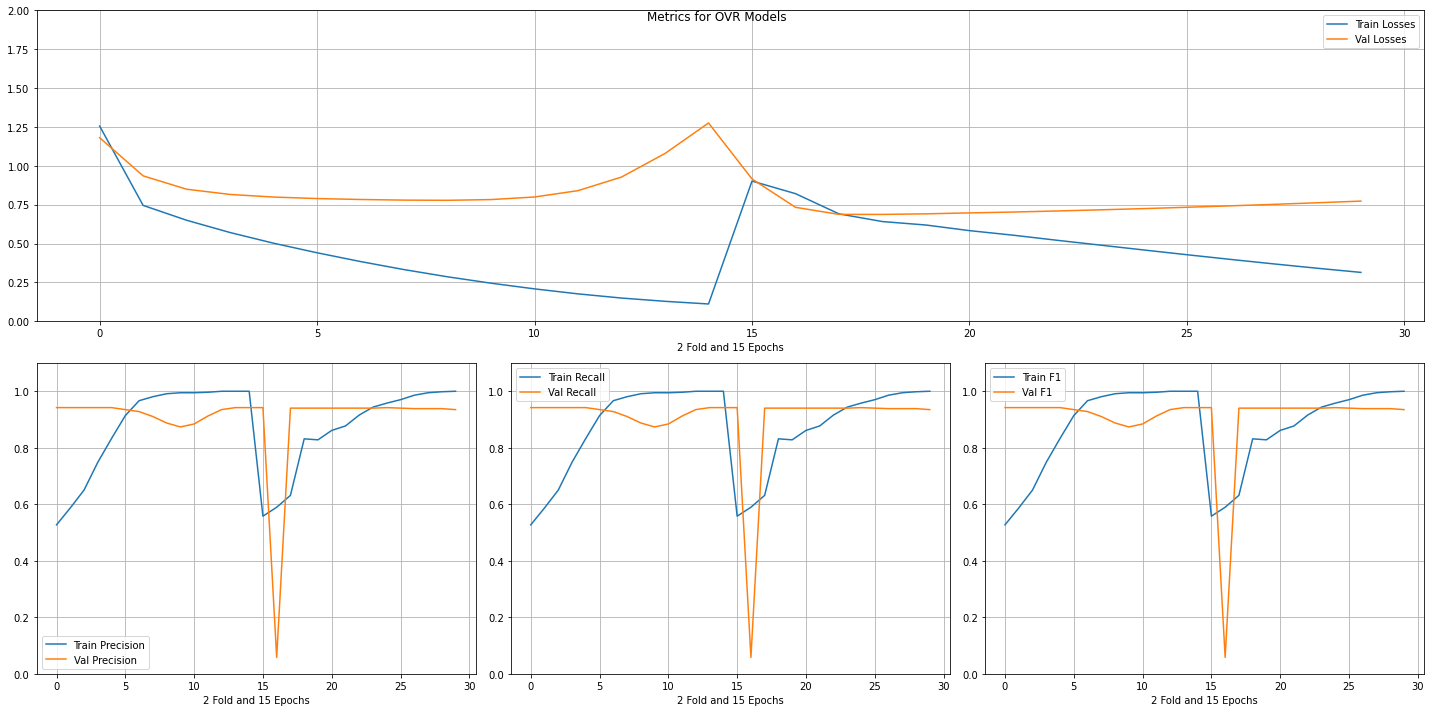

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.527241       0.942105  ...      1.255654           1.180914
13  1.000000       0.942105  ...      0.127965           1.079442
2   0.650264       0.942105  ...      0.649554           0.849263
3   0.748682       0.942105  ...      0.570510           0.815658
4   0.833040       0.942105  ...      0.501807           0.798833
1   0.586995       0.942105  ...      0.745225           0.935218
14  1.000000       0.942105  ...      0.110799           1.275481
9   0.957895       0.942004  ...      0.458543           0.724484
0   0.557895       0.942004  ...      0.901816           0.915231
4   0.828070       0.940246  ...      0.618868           0.690868
7   0.915789       0.940246  ...      0.521152           0.709196
10  0.970175       0.940246  ...      0.427763           0.733177
2   0.631579       0.940246  ...      0.690634           0.687369
3   0.831579       0.940246  ...      0.641113           0.687159
8   0.9438

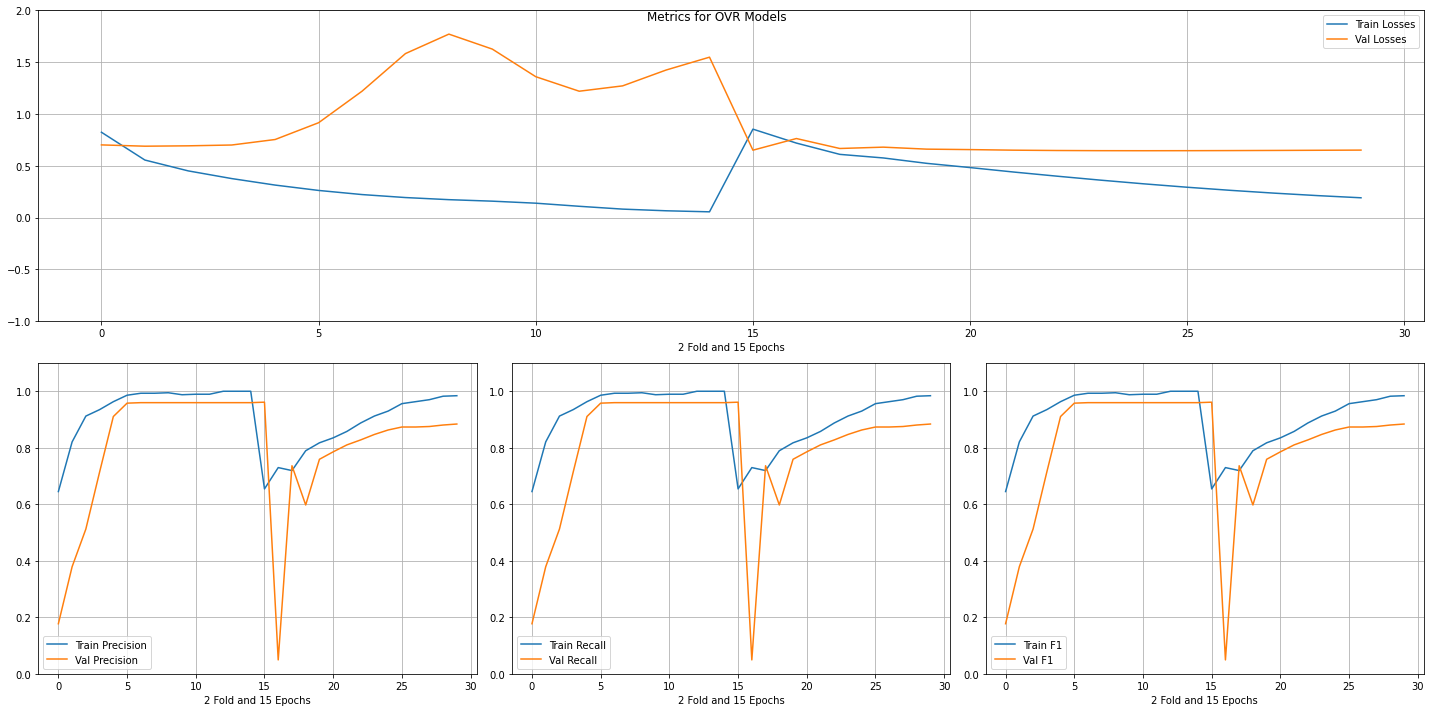

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.654386       0.961336  ...      0.853774           0.650725
12  1.000000       0.959649  ...      0.081868           1.271514
14  1.000000       0.959649  ...      0.055717           1.548482
13  1.000000       0.959649  ...      0.065874           1.424265
6   0.992970       0.959649  ...      0.222348           1.219989
7   0.992970       0.959649  ...      0.193522           1.583240
8   0.994728       0.959649  ...      0.173122           1.771080
9   0.987698       0.959649  ...      0.158594           1.626387
10  0.989455       0.959649  ...      0.139107           1.360019
11  0.989455       0.959649  ...      0.109208           1.219955
5   0.985940       0.957895  ...      0.262181           0.915757
4   0.963093       0.910526  ...      0.313863           0.753835
14  0.984211       0.884007  ...      0.191254           0.651484
13  0.982456       0.880492  ...      0.212257           0.649852
12  0.9701

In [71]:
jlabels = jle.transform(jle.classes_)
jovr_res = ovr_train_model(data, MfccMatrixJanakaRagaDataset, MfccRaga, "OVR Models", jlabels, jle.classes_, lbl_encoder=jle, target='JanakaRagamCode', lr=1e-4, epochs=15, n_folds=2)

# OVR Experiment without Mayamalavagowla Raga

In [72]:
cl = jle.classes_
mc = jle.transform(['Mayamalavagowla','Unknown'])
rdata = data[data['JanakaRagamCode']!=mc[0]]
rdata = rdata[rdata['JanakaRagamCode']!=mc[1]]
cl = [x for x in cl if not x in ['Mayamalavagowla','Unknown'] ]
jlabels1 = jle.transform(cl)

Training for ['Chalanata'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 304/304
Class Weights : [ 0.52144082 12.16      ]
Epoch 1/15 : Training Loss: 0.822 / Validation Loss : 0.810 [Time Taken : 1.057576 seconds]
Epoch 2/15 : Training Loss: 0.683 / Validation Loss : 0.704 [Time Taken : 1.018333 seconds]
Epoch 3/15 : Training Loss: 0.452 / Validation Loss : 0.763 [Time Taken : 1.021856 seconds]
Epoch 4/15 : Training Loss: 0.349 / Validation Loss : 0.717 [Time Taken : 1.015627 seconds]
Epoch 5/15 : Training Loss: 0.311 / Validation Loss : 0.821 [Time Taken : 1.015375 seconds]
Epoch 6/15 : Training Loss: 0.243 / Validation Loss : 0.812 [Time Taken : 1.025324 seconds]
Epoch 7/15 : Training Loss: 0.212 / Validation Loss : 0.884 [Time Taken : 1.020899 seconds]
Epoch 8/15 : Training Loss: 0.177 / Validation Loss : 0.928 [Time Taken : 1.043225 seconds]
Epoch 9/15 : Training Loss: 0.151 / Validation Loss : 0.978 [Time Taken : 1.016266 seconds]
Epoch 10/15 : Training Loss: 0.129 

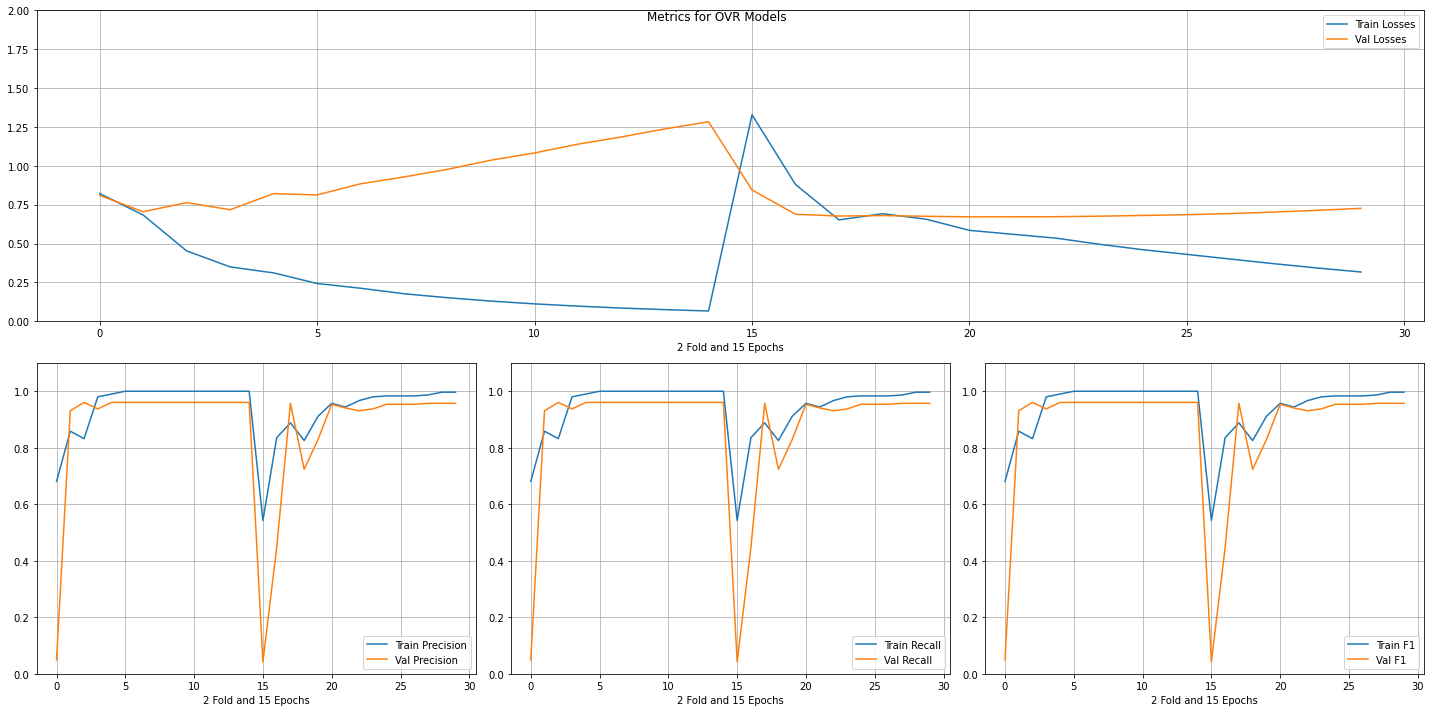

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.960526  ...      0.065729           1.283339
2   0.832237       0.960526  ...      0.452467           0.763044
4   0.990132       0.960526  ...      0.310873           0.821099
5   1.000000       0.960526  ...      0.242648           0.812426
6   1.000000       0.960526  ...      0.212080           0.884113
7   1.000000       0.960526  ...      0.176510           0.928178
8   1.000000       0.960526  ...      0.151061           0.977552
9   1.000000       0.960526  ...      0.129458           1.036256
10  1.000000       0.960526  ...      0.111423           1.082553
11  1.000000       0.960526  ...      0.096887           1.139223
12  1.000000       0.960526  ...      0.084520           1.185914
13  1.000000       0.960526  ...      0.074367           1.237474
13  0.996711       0.957237  ...      0.342298           0.713609
2   0.888158       0.957237  ...      0.652041           0.676767
14  0.9967

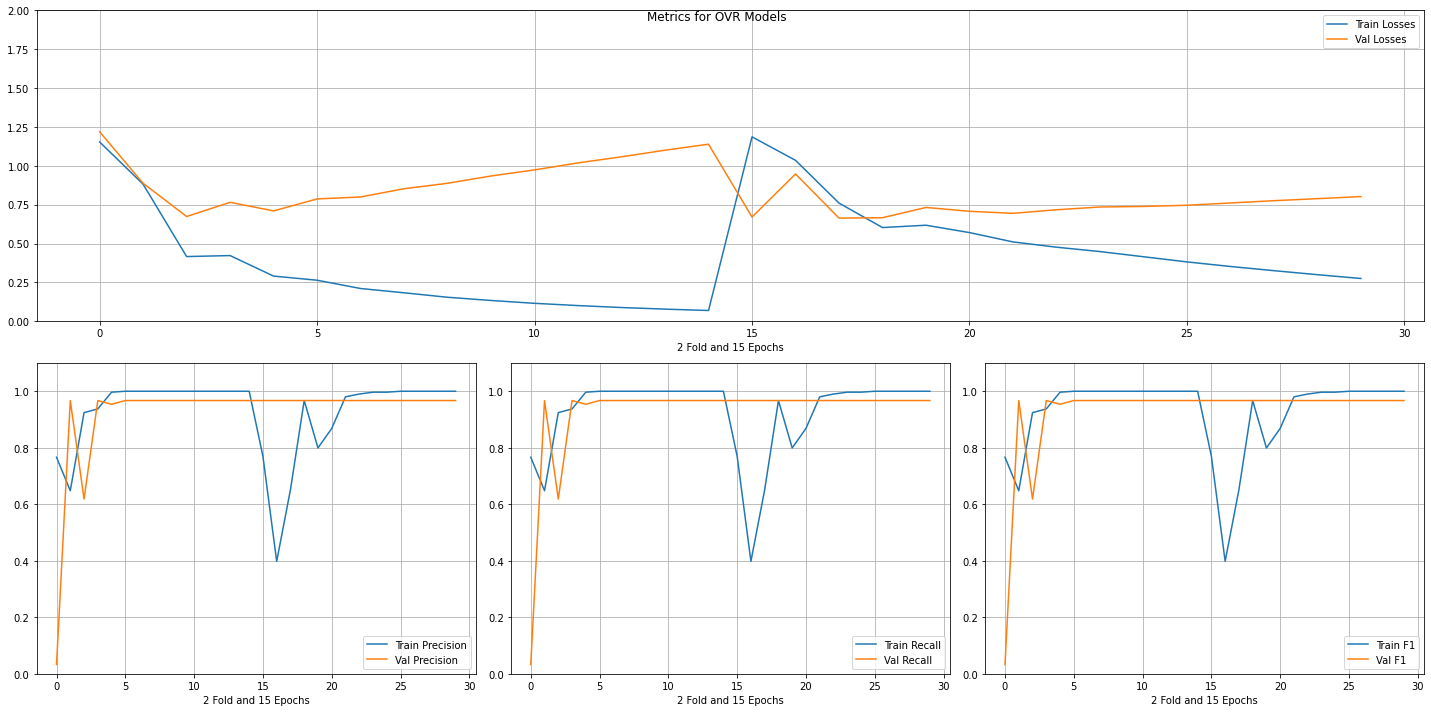

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.769737       0.967105  ...      1.186286           0.670336
1   0.648026       0.967105  ...      0.881208           0.887355
13  1.000000       0.967105  ...      0.299350           0.788480
12  1.000000       0.967105  ...      0.325148           0.775529
11  1.000000       0.967105  ...      0.352108           0.760709
10  1.000000       0.967105  ...      0.381578           0.746150
9   0.996711       0.967105  ...      0.414794           0.738508
8   0.996711       0.967105  ...      0.448092           0.734866
7   0.990132       0.967105  ...      0.476216           0.717064
6   0.980263       0.967105  ...      0.510209           0.694190
5   0.868421       0.967105  ...      0.570196           0.707147
4   0.799342       0.967105  ...      0.617624           0.731881
3   0.967105       0.967105  ...      0.602580           0.665905
2   0.651316       0.967105  ...      0.760093           0.663271
1   0.3980

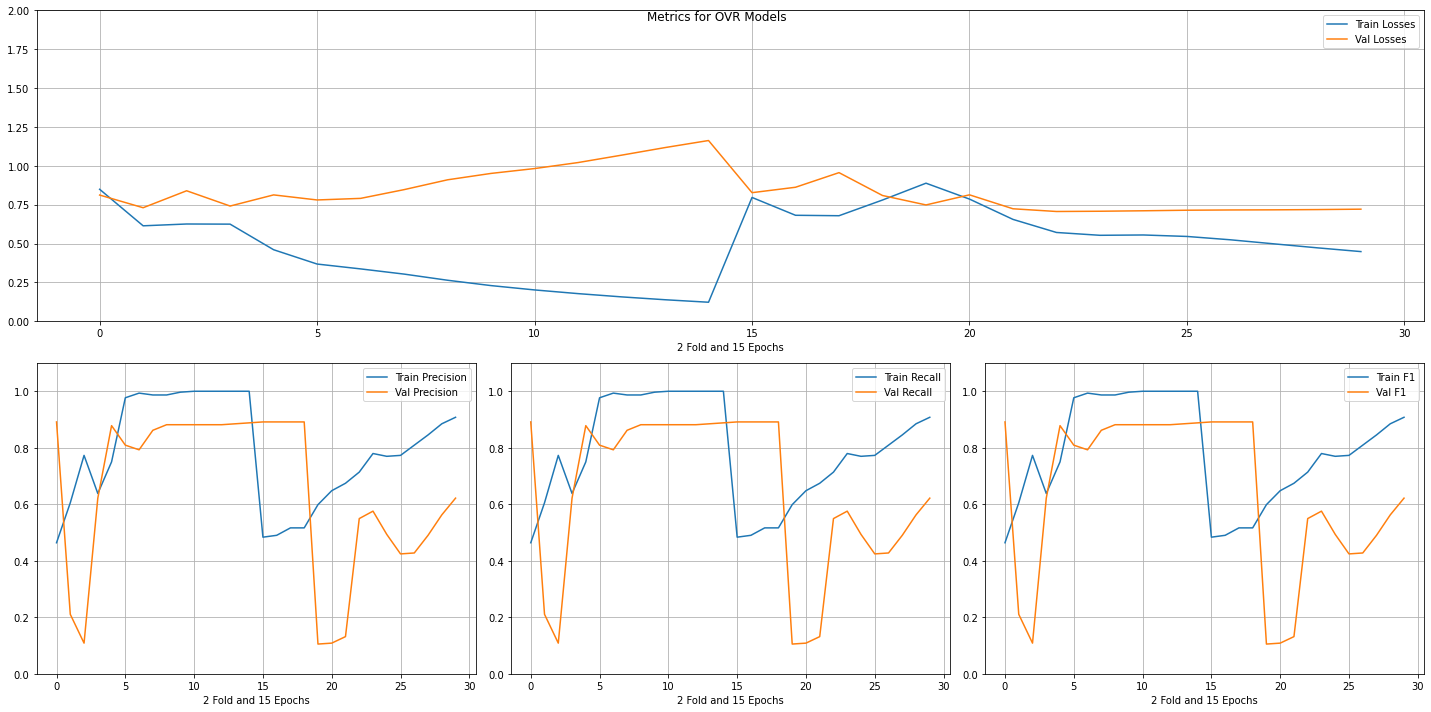

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.463816       0.891447  ...      0.848860           0.811796
1   0.490132       0.891447  ...      0.681578           0.861929
3   0.516447       0.891447  ...      0.779738           0.808869
2   0.516447       0.891447  ...      0.678730           0.955986
0   0.483553       0.891447  ...      0.796346           0.827104
14  1.000000       0.888158  ...      0.122036           1.162665
13  1.000000       0.884868  ...      0.138098           1.117274
8   0.986842       0.881579  ...      0.263512           0.909902
9   0.996711       0.881579  ...      0.229081           0.951008
10  1.000000       0.881579  ...      0.201218           0.982268
11  1.000000       0.881579  ...      0.177462           1.020866
12  1.000000       0.881579  ...      0.156538           1.068405
4   0.750000       0.878289  ...      0.459938           0.812735
7   0.986842       0.861842  ...      0.303108           0.846627
5   0.9769

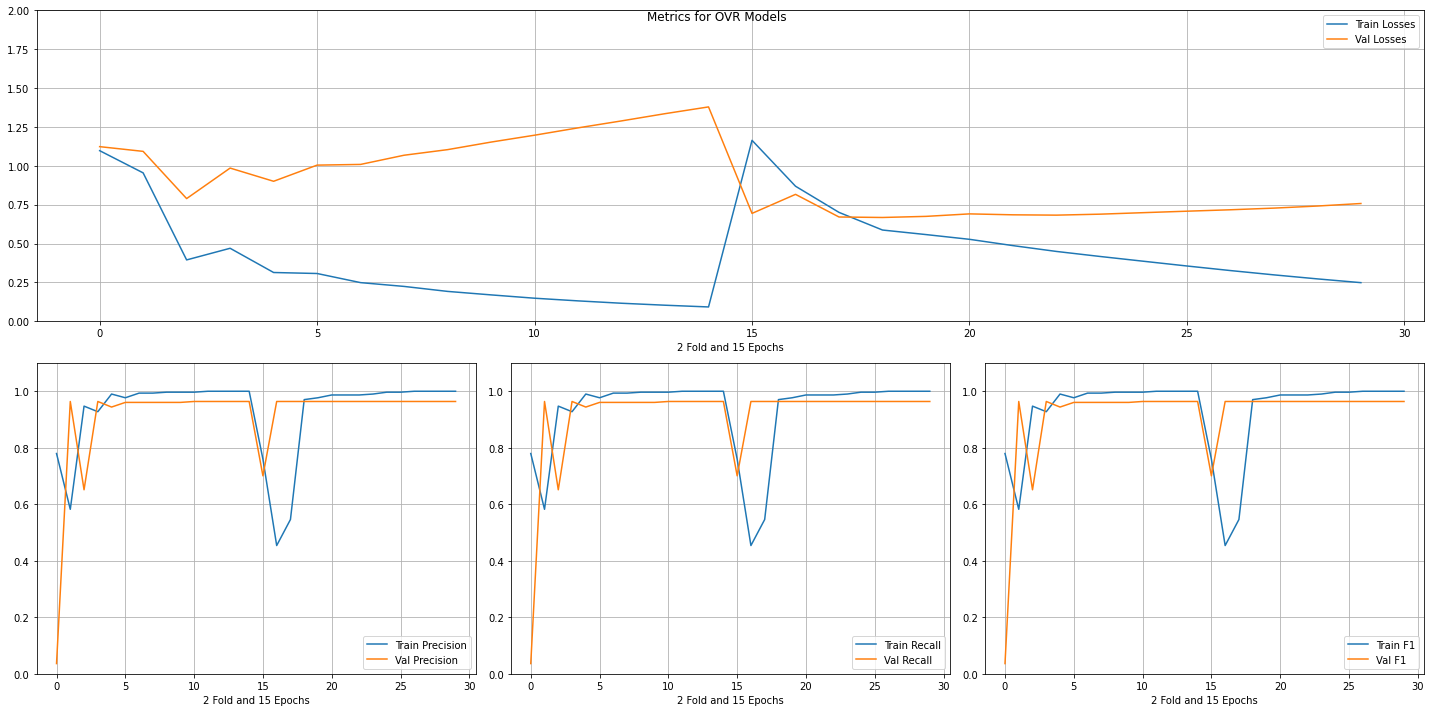

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.963816  ...      0.248073           0.757384
14  1.000000       0.963816  ...      0.091709           1.378948
10  0.996711       0.963816  ...      0.355263           0.707888
9   0.996711       0.963816  ...      0.385826           0.698454
8   0.990132       0.963816  ...      0.416611           0.688719
7   0.986842       0.963816  ...      0.448855           0.682488
6   0.986842       0.963816  ...      0.486348           0.684589
5   0.986842       0.963816  ...      0.526906           0.690583
4   0.976974       0.963816  ...      0.557438           0.674534
3   0.970395       0.963816  ...      0.586704           0.667434
2   0.546053       0.963816  ...      0.700202           0.670581
1   0.453947       0.963816  ...      0.868569           0.816195
1   0.582237       0.963816  ...      0.954447           1.092875
13  1.000000       0.963816  ...      0.102860           1.335447
12  1.0000

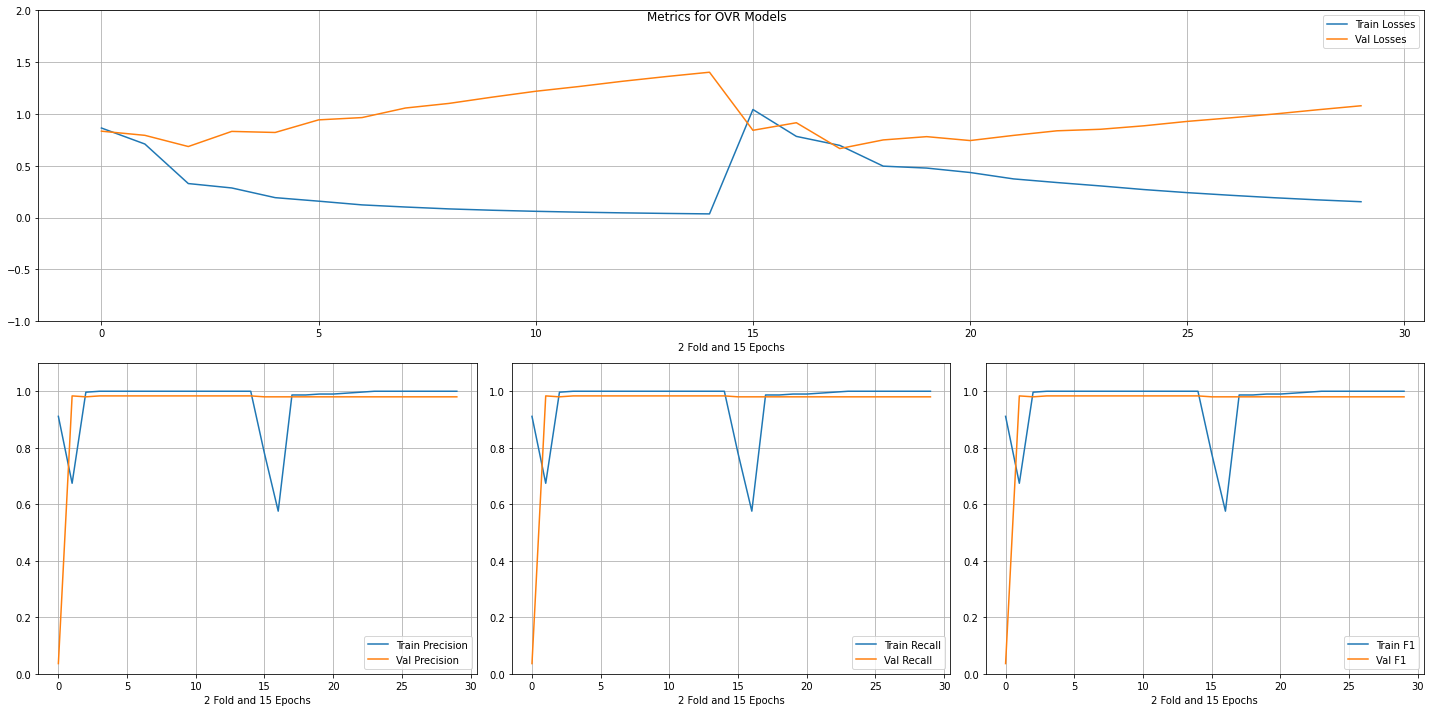

    train_f1  validation_f1  ...  train_losses  validation_losses
10  1.000000       0.983553  ...      0.060681           1.219530
3   1.000000       0.983553  ...      0.286167           0.831976
4   1.000000       0.983553  ...      0.192576           0.821694
5   1.000000       0.983553  ...      0.158684           0.943343
6   1.000000       0.983553  ...      0.122674           0.965474
7   1.000000       0.983553  ...      0.102125           1.057775
8   1.000000       0.983553  ...      0.083959           1.102042
9   1.000000       0.983553  ...      0.071022           1.162835
11  1.000000       0.983553  ...      0.052347           1.265509
12  1.000000       0.983553  ...      0.045762           1.316032
13  1.000000       0.983553  ...      0.040280           1.361220
14  1.000000       0.983553  ...      0.035741           1.403269
1   0.674342       0.983553  ...      0.710289           0.794072
11  1.000000       0.980263  ...      0.215310           0.962973
9   1.0000

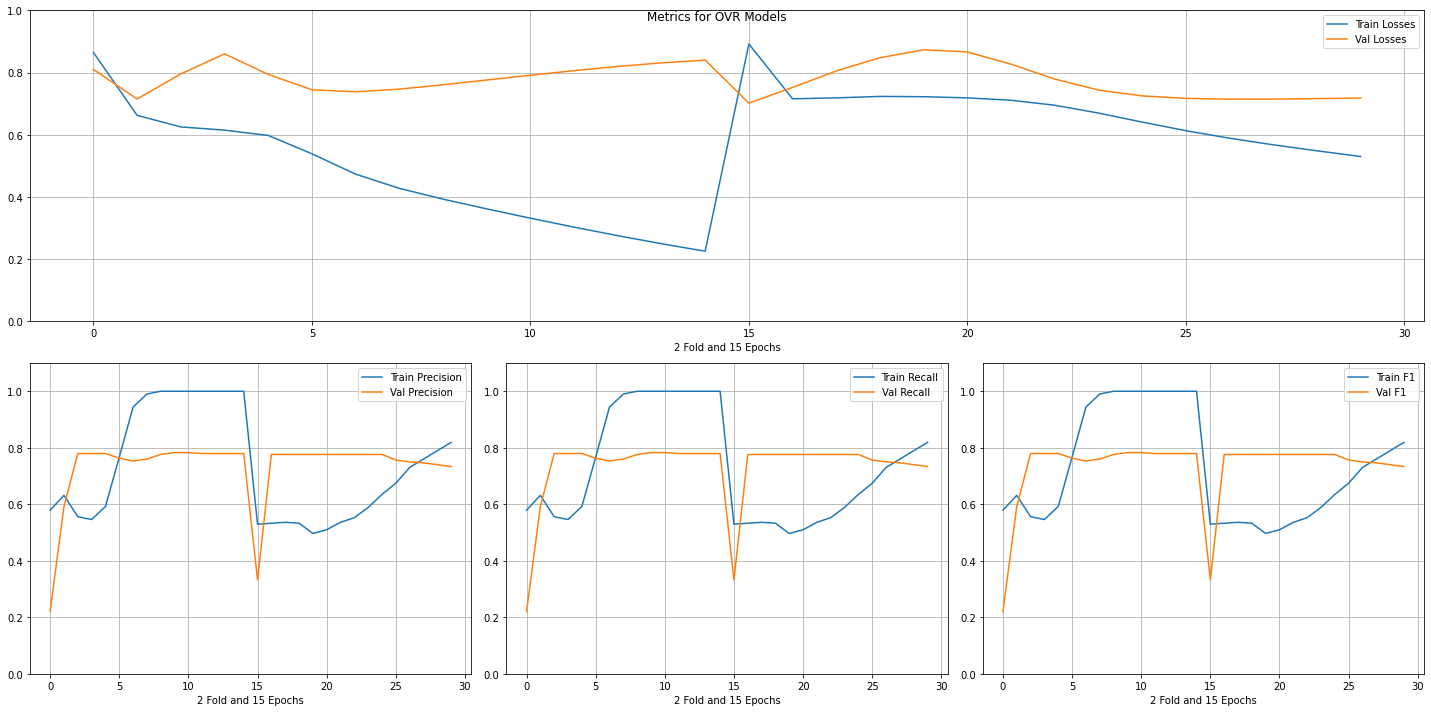

    train_f1  validation_f1  ...  train_losses  validation_losses
9   1.000000       0.782895  ...      0.361421           0.776032
10  1.000000       0.782895  ...      0.331442           0.791331
14  1.000000       0.779605  ...      0.225129           0.840079
13  1.000000       0.779605  ...      0.249315           0.831176
11  1.000000       0.779605  ...      0.302626           0.806113
12  1.000000       0.779605  ...      0.275185           0.819640
4   0.592105       0.779605  ...      0.597676           0.794146
3   0.546053       0.779605  ...      0.614703           0.860063
2   0.555921       0.779605  ...      0.625101           0.795584
8   0.588816       0.776316  ...      0.669690           0.743716
6   0.536184       0.776316  ...      0.710948           0.827014
8   1.000000       0.776316  ...      0.392744           0.760733
9   0.634868       0.776316  ...      0.640672           0.724926
7   0.552632       0.776316  ...      0.694839           0.778976
1   0.5328

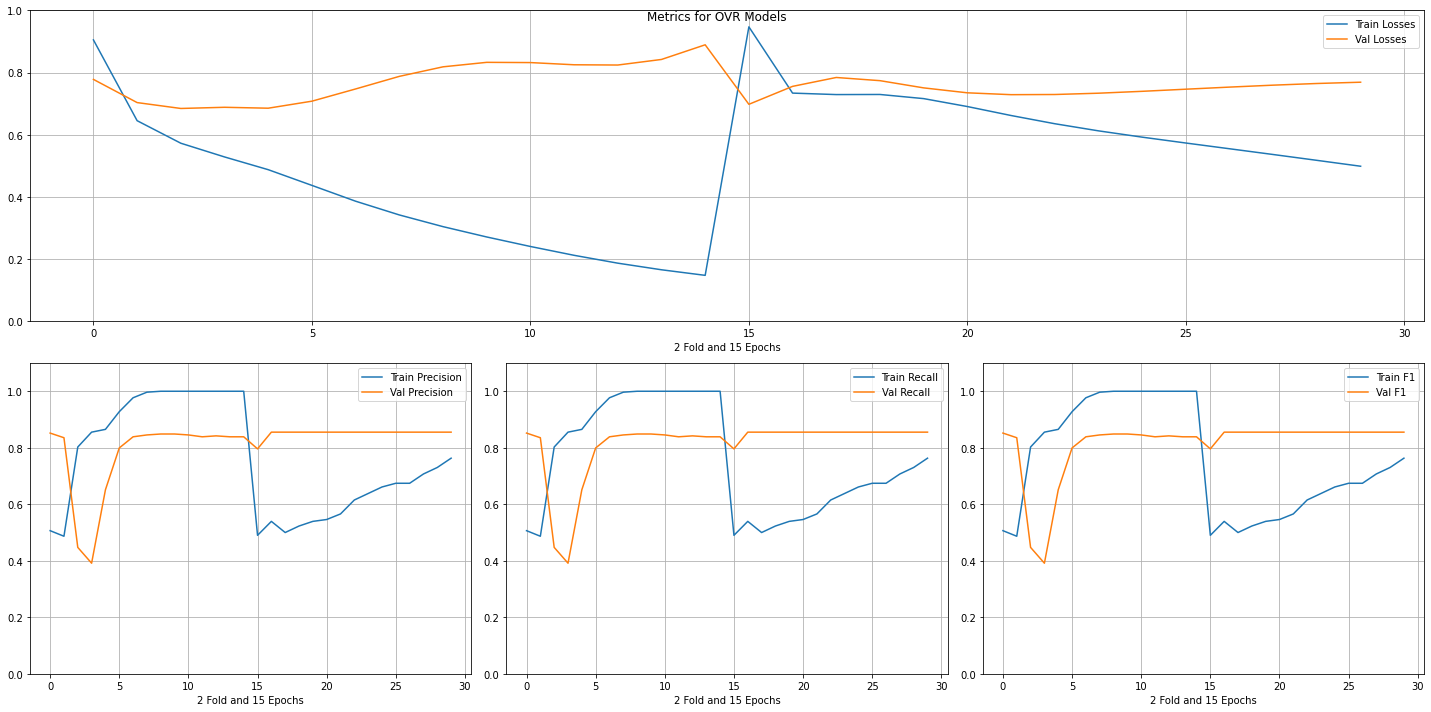

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.763158       0.855263  ...      0.498597           0.768960
1   0.539474       0.855263  ...      0.733885           0.755560
13  0.730263       0.855263  ...      0.517540           0.764824
12  0.707237       0.855263  ...      0.536304           0.759472
11  0.674342       0.855263  ...      0.554828           0.753219
10  0.674342       0.855263  ...      0.573296           0.746451
9   0.661184       0.855263  ...      0.592194           0.739639
8   0.638158       0.855263  ...      0.612474           0.733581
7   0.615132       0.855263  ...      0.635390           0.729395
6   0.565789       0.855263  ...      0.661820           0.728857
5   0.546053       0.855263  ...      0.690659           0.734827
4   0.539474       0.855263  ...      0.716171           0.750711
3   0.523026       0.855263  ...      0.729499           0.773931
2   0.500000       0.855263  ...      0.729166           0.784167
0   0.5065

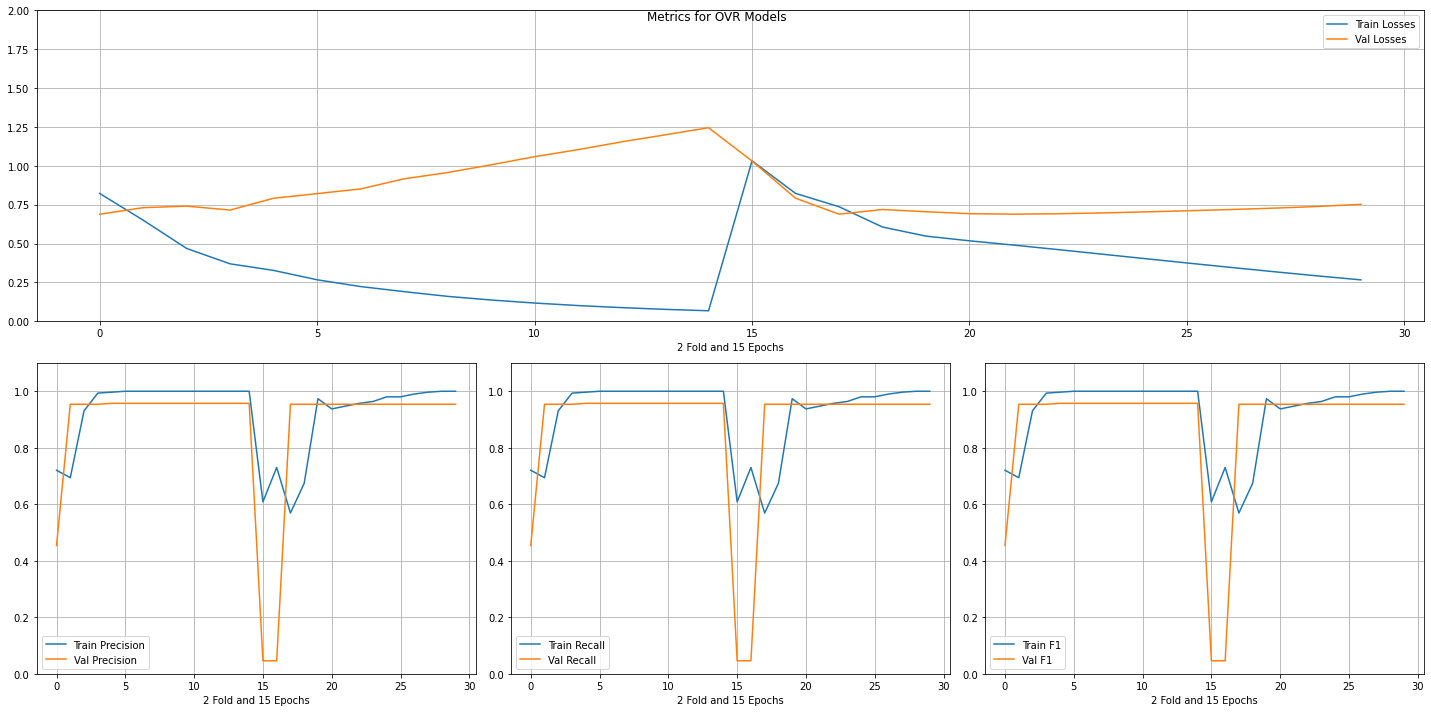

    train_f1  validation_f1  ...  train_losses  validation_losses
13  1.000000       0.957237  ...      0.076273           1.199193
7   1.000000       0.957237  ...      0.190200           0.916258
14  1.000000       0.957237  ...      0.067068           1.245094
12  1.000000       0.957237  ...      0.087386           1.154028
11  1.000000       0.957237  ...      0.100607           1.103920
10  1.000000       0.957237  ...      0.116891           1.058728
8   1.000000       0.957237  ...      0.159866           0.956568
9   1.000000       0.957237  ...      0.136318           1.006317
6   1.000000       0.957237  ...      0.222955           0.851069
5   1.000000       0.957237  ...      0.266569           0.820993
4   0.996711       0.957237  ...      0.326753           0.791337
4   0.973684       0.953947  ...      0.547484           0.704384
9   0.980263       0.953947  ...      0.403659           0.703157
8   0.963816       0.953947  ...      0.432731           0.696492
10  0.9802

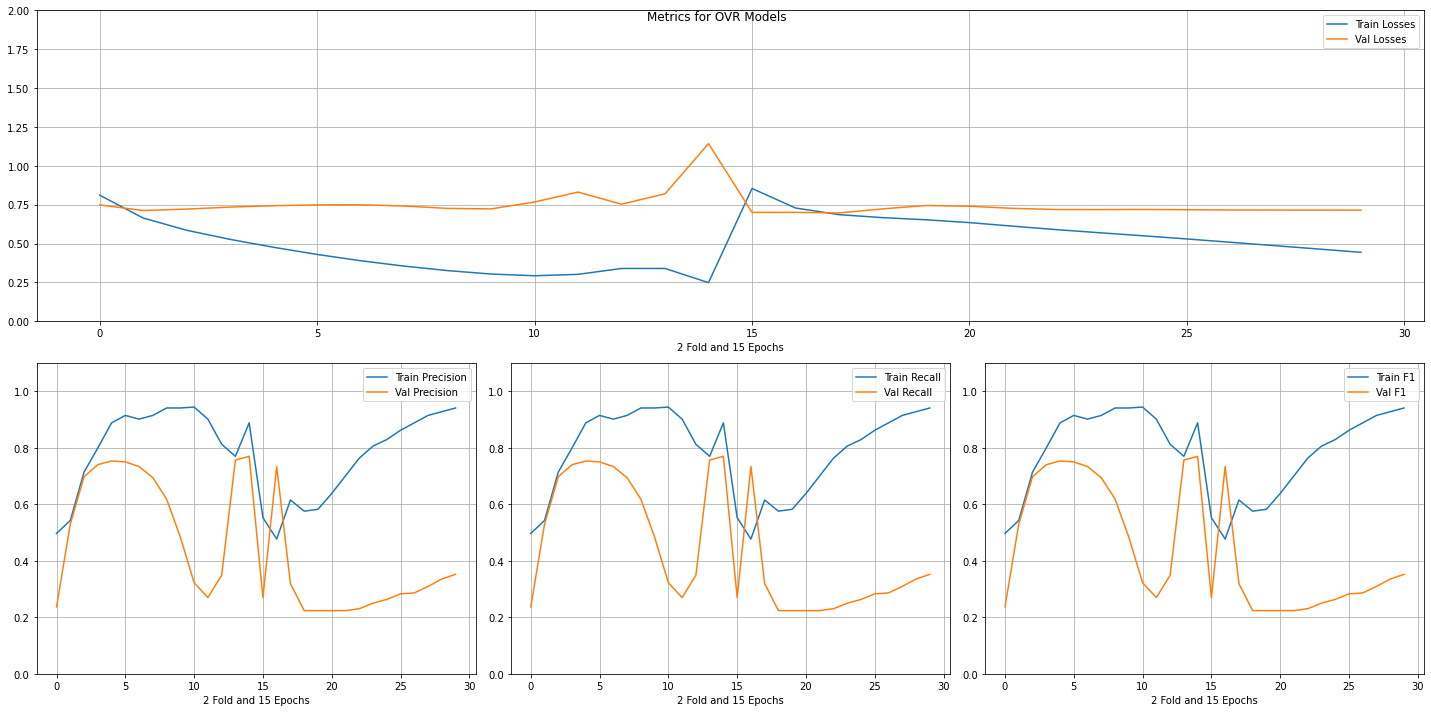

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.888158       0.769737  ...      0.248046           1.142556
13  0.769737       0.756579  ...      0.339395           0.819830
4   0.888158       0.753289  ...      0.475685           0.743060
5   0.914474       0.750000  ...      0.429631           0.748590
3   0.799342       0.740132  ...      0.526506           0.734307
6   0.901316       0.733553  ...      0.389151           0.749139
1   0.476974       0.733553  ...      0.728461           0.700294
2   0.713816       0.697368  ...      0.585211           0.721417
7   0.914474       0.694079  ...      0.354527           0.741091
8   0.940789       0.618421  ...      0.325595           0.725889
1   0.542763       0.529605  ...      0.664140           0.712367
9   0.940789       0.483553  ...      0.303497           0.722647
14  0.940789       0.351974  ...      0.443216           0.714560
12  0.812500       0.348684  ...      0.339296           0.752857
13  0.9276

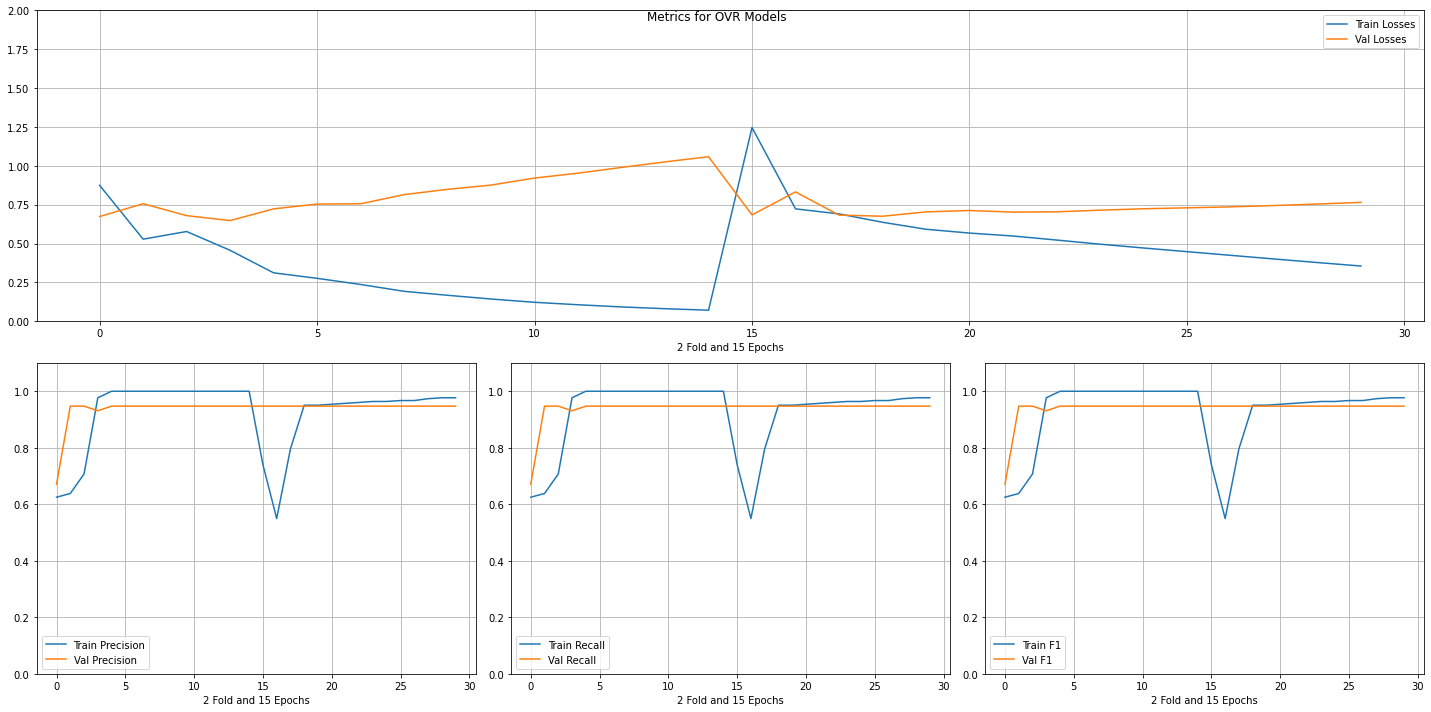

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.740132       0.947368  ...      1.246196           0.684080
1   0.638158       0.947368  ...      0.527871           0.755961
13  0.976974       0.947368  ...      0.377460           0.754077
12  0.973684       0.947368  ...      0.400479           0.744212
11  0.967105       0.947368  ...      0.423986           0.735847
10  0.967105       0.947368  ...      0.447565           0.729510
9   0.963816       0.947368  ...      0.471120           0.723465
8   0.963816       0.947368  ...      0.495660           0.714380
7   0.960526       0.947368  ...      0.522277           0.703924
6   0.957237       0.947368  ...      0.548208           0.701936
5   0.953947       0.947368  ...      0.567181           0.712268
4   0.950658       0.947368  ...      0.591693           0.703409
3   0.950658       0.947368  ...      0.636603           0.675433
2   0.796053       0.947368  ...      0.690591           0.682890
1   0.5493

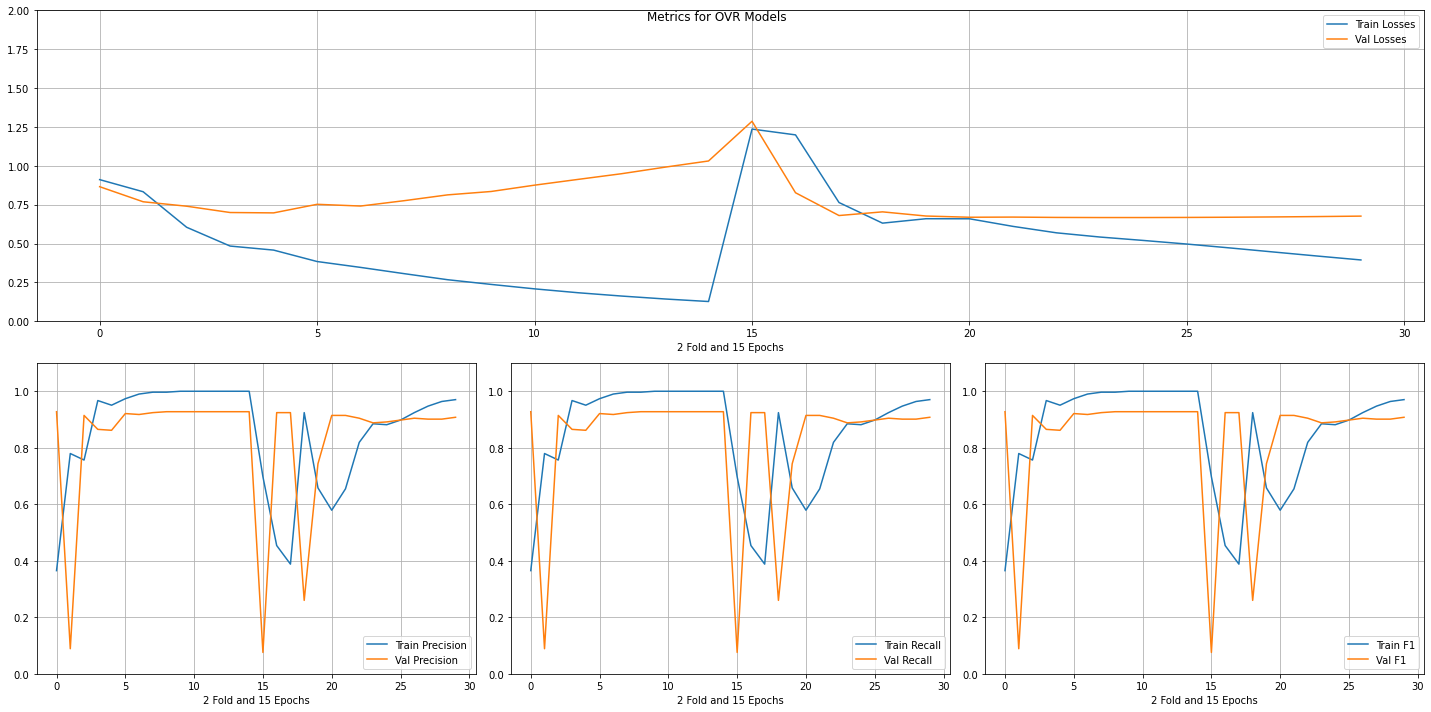

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.365132       0.927632  ...      0.911062           0.865586
8   0.996711       0.927632  ...      0.266982           0.812907
9   1.000000       0.927632  ...      0.236757           0.834660
10  1.000000       0.927632  ...      0.208128           0.875424
11  1.000000       0.927632  ...      0.183166           0.912519
12  1.000000       0.927632  ...      0.161839           0.949044
13  1.000000       0.927632  ...      0.142954           0.991309
14  1.000000       0.927632  ...      0.126697           1.031028
1   0.453947       0.924342  ...      1.198972           0.826625
7   0.996711       0.924342  ...      0.306010           0.775428
2   0.388158       0.924342  ...      0.763646           0.679976
5   0.973684       0.921053  ...      0.384017           0.752236
6   0.990132       0.917763  ...      0.346202           0.741019
2   0.756579       0.914474  ...      0.604528           0.739990
6   0.6546

In [73]:
jovr_res_reduced = ovr_train_model(rdata, MfccMatrixJanakaRagaDataset, MfccRaga, "OVR Models", jlabels1, cl, lbl_encoder=jle, target='JanakaRagamCode', lr=1e-4, epochs=15, n_folds=2)

# OVR Experiment 2 - LSTM Model

In [74]:
class MfccLstmModel(nn.Module):
    def __init__(self, n_labels, dropout=0.25, n_layers=2):
        super().__init__()
        self.input_dim = 40
        self.hidden_dim = self.input_dim
        self.n_layers = n_layers
        self.seq_len = 9601
        self.n_labels = n_labels
        self.rnn = nn.LSTM(self.input_dim, self.hidden_dim, self.n_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Sequential(nn.Linear(2*self.hidden_dim,160),
                                nn.GELU(),
                                nn.Linear(160,self.n_labels))

    def forward(self,x,h):
        x = x.reshape((x.shape[0],x.shape[2],x.shape[3]))
        out, (hn, cn) = self.rnn(x.permute(0, 2, 1), h)
        x_forward = out[range(len(out)), self.seq_len - 1, :self.hidden_dim]
        x_reverse = out[:, 0, self.hidden_dim:]
        x = torch.cat((x_forward, x_reverse), 1)
        x = self.fc(x)
        return x
    
    def init_hidden(self, batch_size, target_device):
        weight = next(self.parameters()).data
        # Bi directional LSTM
        hidden = (weight.new(2 * self.n_layers, batch_size, self.hidden_dim).zero_().to(target_device),
                  weight.new(2 * self.n_layers, batch_size, self.hidden_dim).zero_().to(target_device))
        return hidden

In [75]:
def ovr_train_model_lstm(data, dataset, mdl, title, labels, label_classes, lbl_encoder=None, target='RagamCode', feature='mfcc'):
  results = {}
  for i in labels:
    # Create new data    
    nsamples = data[data[target]==i].shape[0]
    if lbl_encoder: print(f'Training for {lbl_encoder.inverse_transform([i])} with {nsamples} positive samples')
    ndata = pd.DataFrame()
    ndata[target] = data.apply(lambda x:1 if x[target] == i else 0, axis=1)
    ndata[feature] = data[feature]
    results[i] = train_model(ndata, dataset.prepare_data, gpu, 
                                  **{'n_labels' : 2,
                                   'report' : 50,
                                   'lstm' : True,
                                   'lr' : 1e-4,
                                   'clip_at' : None,
                                   'k_folds' : 2,
                                   'balance_classes' : True,
                                   'dropout' : 0.1,
                                   'title' : title,
                                   'plot' : True,
                                   'epochs' : 10,
                                   'model' : mdl,
                                   'feature' : feature,
                                   'target' : target})
    print(results_to_df(results[i]))
  return results

Training for ['Chalanata'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 304/304
Class Weights : [ 0.52144082 12.16      ]
Epoch 1/10 : Training Loss: 0.694 / Validation Loss : 0.688 [Time Taken : 19.079905 seconds]
Epoch 2/10 : Training Loss: 0.688 / Validation Loss : 0.687 [Time Taken : 19.144528 seconds]
Epoch 3/10 : Training Loss: 0.686 / Validation Loss : 0.686 [Time Taken : 19.080568 seconds]
Epoch 4/10 : Training Loss: 0.684 / Validation Loss : 0.685 [Time Taken : 19.159729 seconds]
Epoch 5/10 : Training Loss: 0.680 / Validation Loss : 0.684 [Time Taken : 19.116423 seconds]
Epoch 6/10 : Training Loss: 0.677 / Validation Loss : 0.683 [Time Taken : 19.119477 seconds]
Epoch 7/10 : Training Loss: 0.675 / Validation Loss : 0.682 [Time Taken : 19.102275 seconds]
Epoch 8/10 : Training Loss: 0.671 / Validation Loss : 0.681 [Time Taken : 19.198968 seconds]
Epoch 9/10 : Training Loss: 0.666 / Validation Loss : 0.680 [Time Taken : 19.183158 seconds]
Epoch 10/10 : Training Los

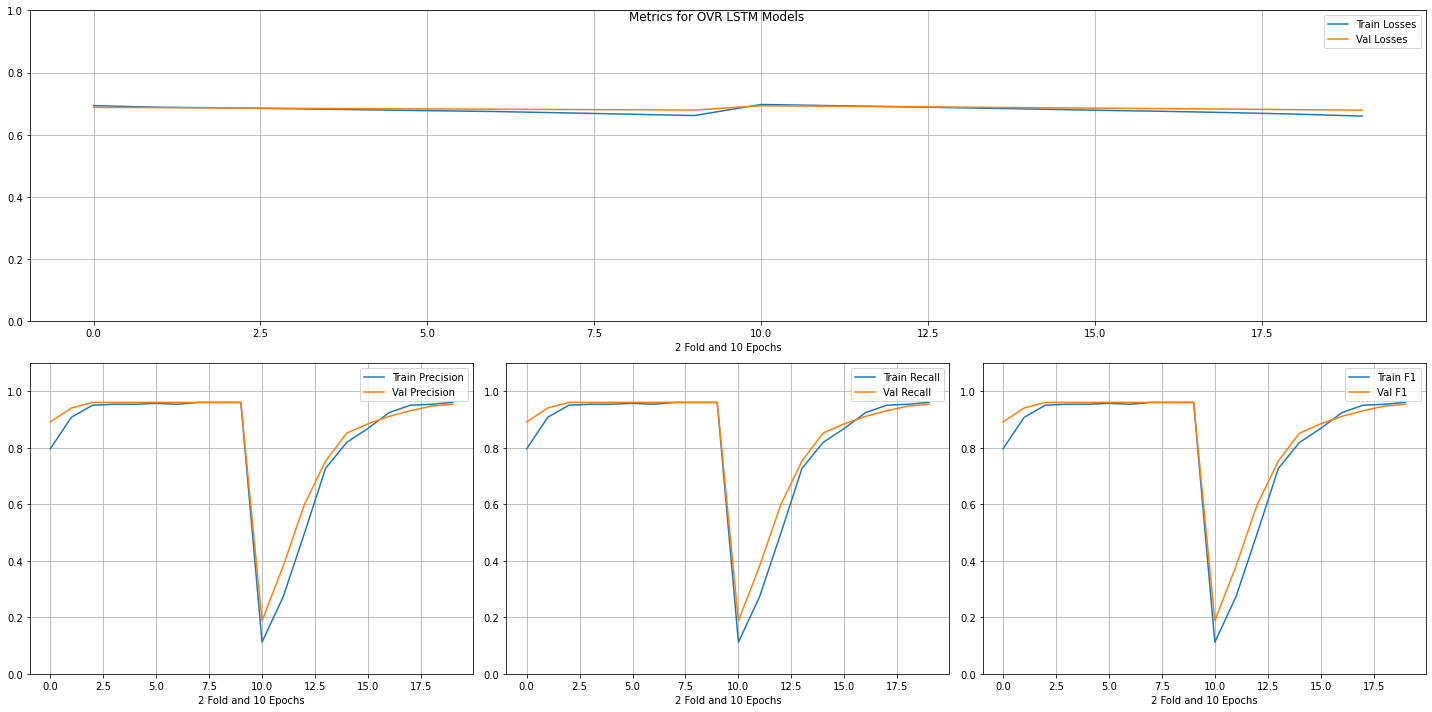

   train_f1  validation_f1  ...  train_losses  validation_losses
2  0.950658       0.960526  ...      0.686350           0.686059
3  0.953947       0.960526  ...      0.683601           0.684904
4  0.953947       0.960526  ...      0.680440           0.683938
5  0.957237       0.960526  ...      0.677439           0.683004
6  0.953947       0.960526  ...      0.674729           0.682059
7  0.960526       0.960526  ...      0.670502           0.681151
8  0.960526       0.960526  ...      0.666150           0.680286
9  0.960526       0.960526  ...      0.661705           0.679373
9  0.960526       0.953947  ...      0.659825           0.679021
8  0.953947       0.947368  ...      0.666398           0.680685
1  0.907895       0.940789  ...      0.688349           0.687067
7  0.950658       0.930921  ...      0.671223           0.682381
6  0.924342       0.911184  ...      0.675441           0.683938
0  0.796053       0.891447  ...      0.693589           0.687998
5  0.868421       0.88486

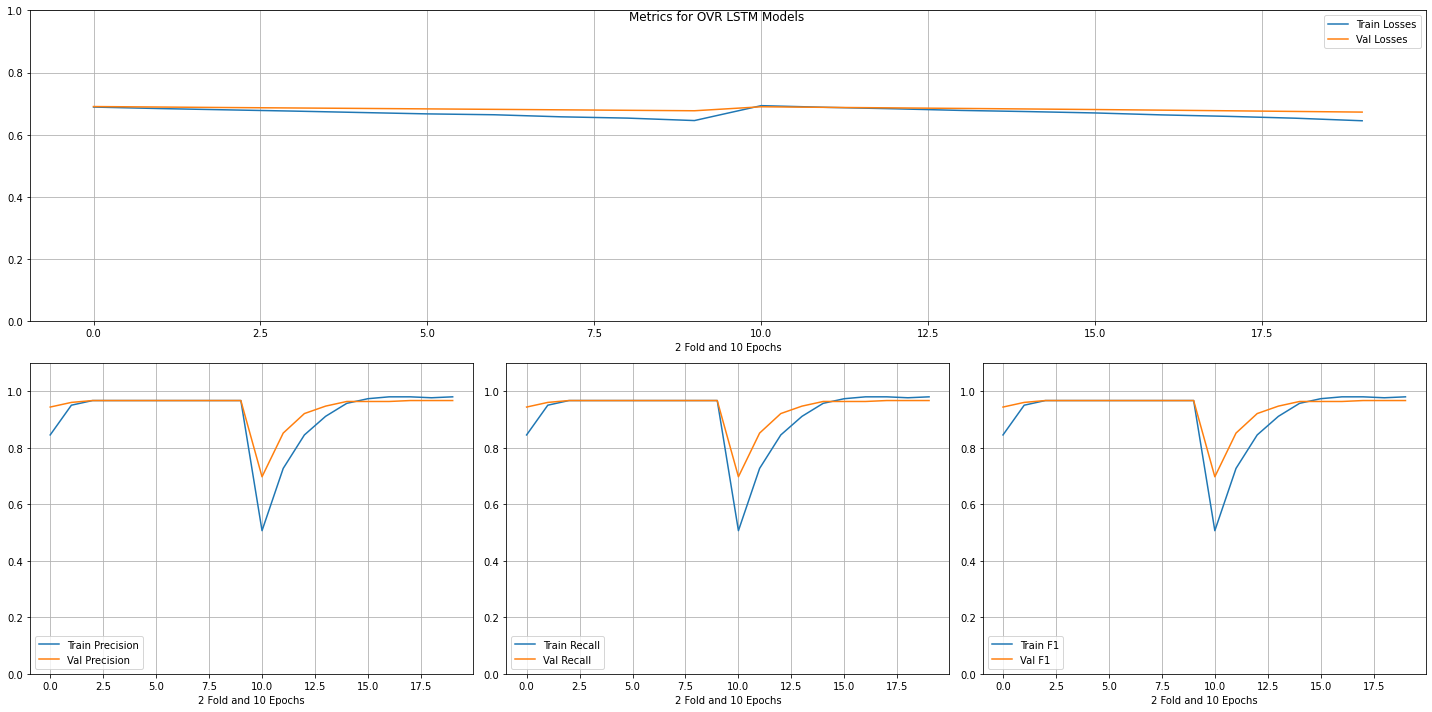

   train_f1  validation_f1  ...  train_losses  validation_losses
9  0.980263       0.967105  ...      0.644917           0.672789
2  0.967105       0.967105  ...      0.680032           0.687471
3  0.967105       0.967105  ...      0.675979           0.686052
4  0.967105       0.967105  ...      0.671462           0.684642
5  0.967105       0.967105  ...      0.667025           0.683107
6  0.967105       0.967105  ...      0.664242           0.681614
7  0.967105       0.967105  ...      0.657605           0.680089
8  0.967105       0.967105  ...      0.653421           0.678575
9  0.967105       0.967105  ...      0.645567           0.677093
8  0.976974       0.967105  ...      0.653126           0.674892
7  0.980263       0.967105  ...      0.659023           0.677008
6  0.980263       0.963816  ...      0.663777           0.679062
4  0.957237       0.963816  ...      0.674421           0.682821
5  0.973684       0.963816  ...      0.670041           0.681022
1  0.950658       0.96052

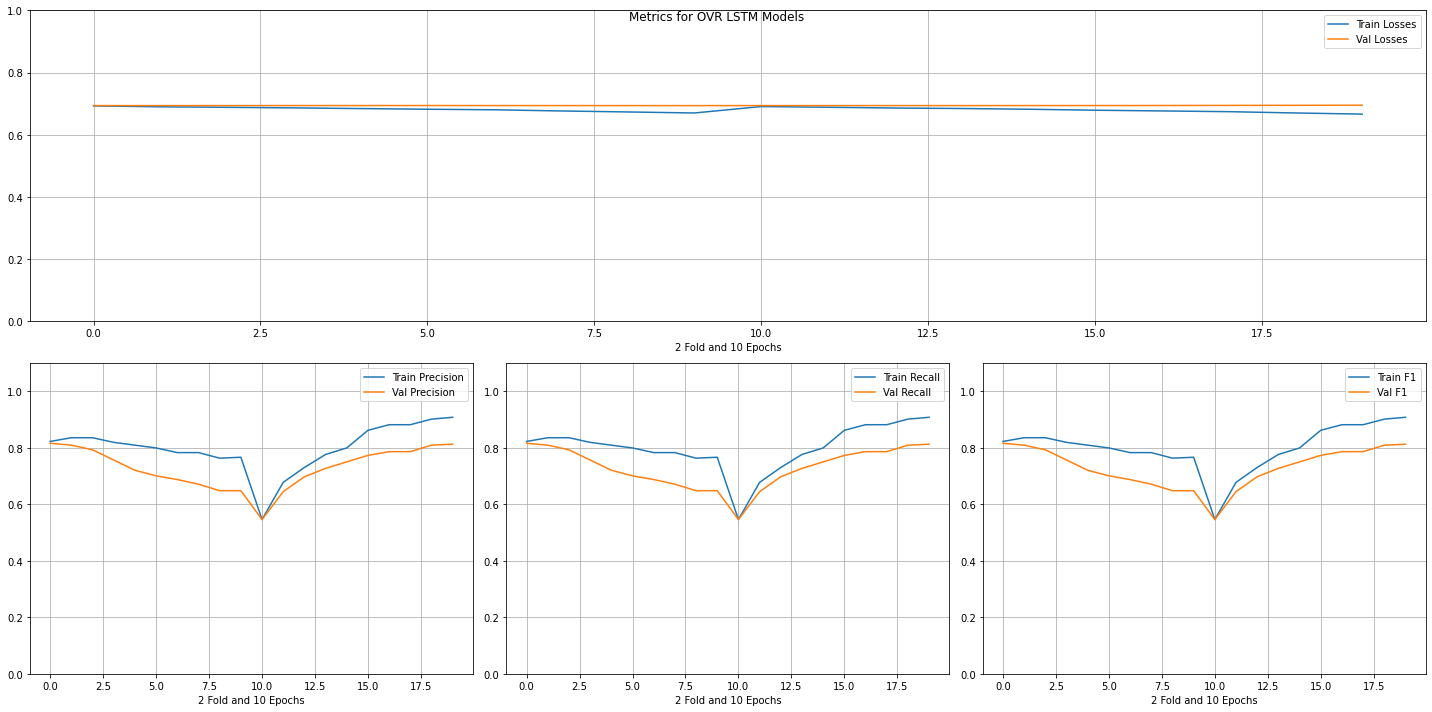

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.822368       0.815789  ...      0.692691           0.693677
9  0.907895       0.812500  ...      0.666302           0.694981
8  0.901316       0.809211  ...      0.669999           0.694614
1  0.835526       0.809211  ...      0.689822           0.693717
2  0.835526       0.792763  ...      0.688179           0.693770
6  0.881579       0.786184  ...      0.676519           0.694023
7  0.881579       0.786184  ...      0.674166           0.694316
5  0.861842       0.773026  ...      0.678823           0.693864
3  0.819079       0.756579  ...      0.686319           0.693838
4  0.799342       0.750000  ...      0.682008           0.693791
3  0.776316       0.726974  ...      0.684322           0.693762
4  0.809211       0.720395  ...      0.684135           0.693862
5  0.799342       0.700658  ...      0.681969           0.693893
2  0.730263       0.697368  ...      0.685832           0.693754
6  0.782895       0.68750

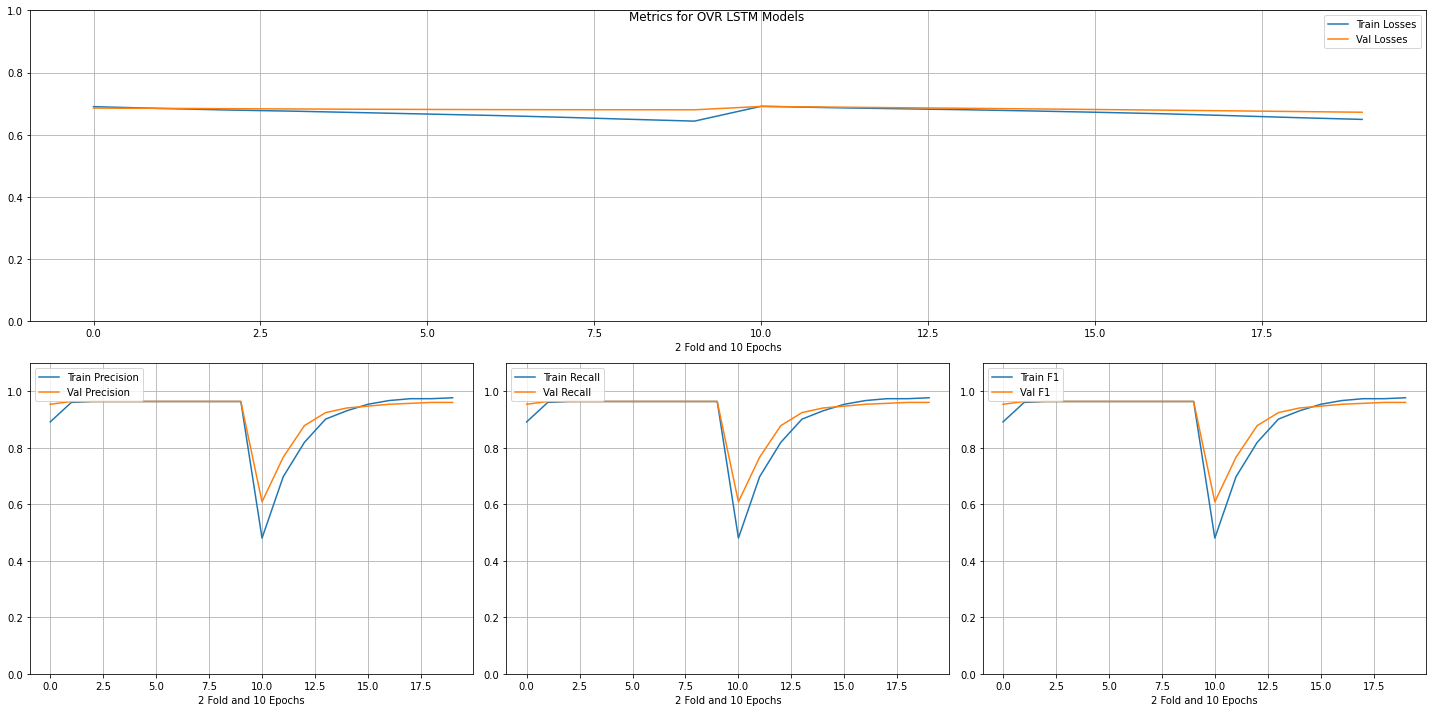

   train_f1  validation_f1  ...  train_losses  validation_losses
2  0.963816       0.963816  ...      0.679522           0.683807
3  0.963816       0.963816  ...      0.675742           0.682871
4  0.963816       0.963816  ...      0.671105           0.681988
5  0.963816       0.963816  ...      0.666478           0.681363
6  0.963816       0.963816  ...      0.661898           0.680766
7  0.963816       0.963816  ...      0.656244           0.680506
8  0.963816       0.963816  ...      0.649861           0.680321
9  0.963816       0.963816  ...      0.643731           0.680211
1  0.960526       0.963816  ...      0.684565           0.684737
9  0.976974       0.960526  ...      0.649249           0.672329
8  0.973684       0.960526  ...      0.655067           0.674636
7  0.973684       0.957237  ...      0.661542           0.676949
6  0.967105       0.953947  ...      0.667562           0.679123
0  0.891447       0.953947  ...      0.690306           0.685719
5  0.953947       0.94736

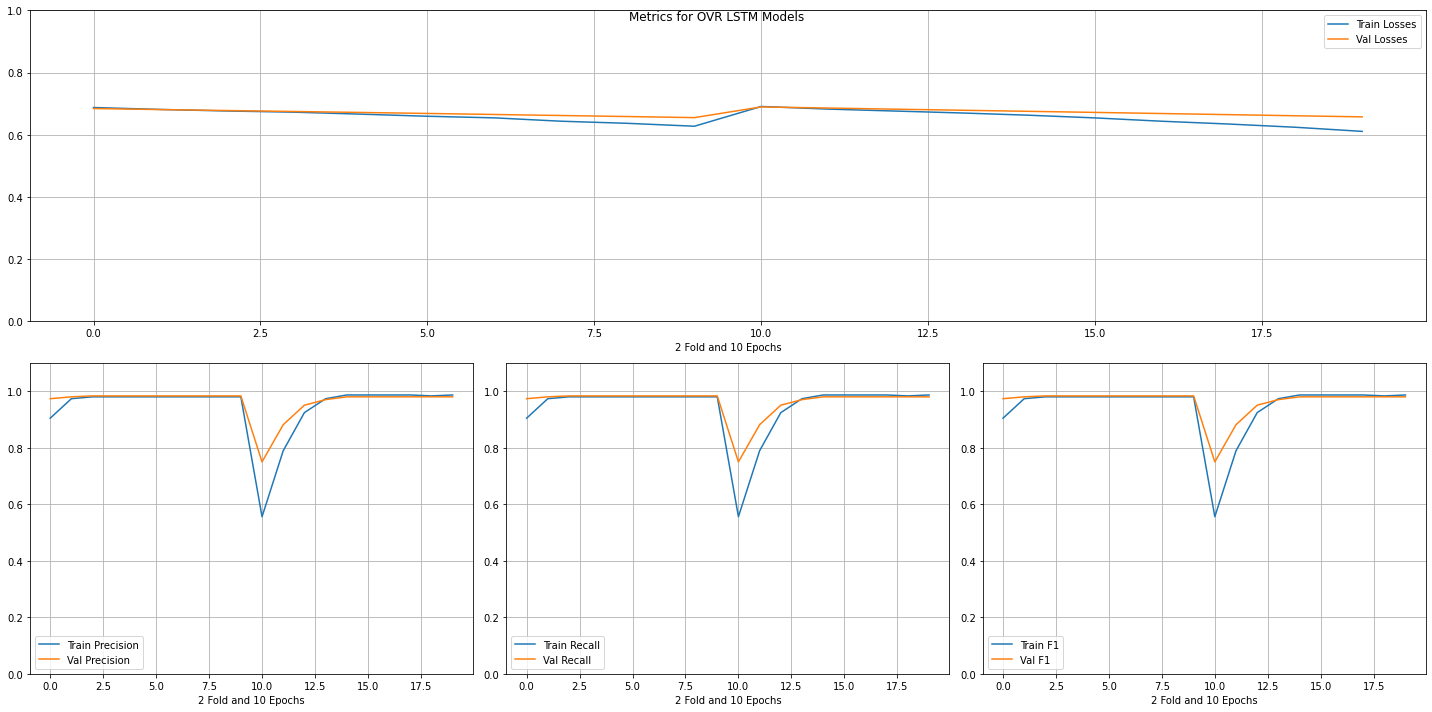

   train_f1  validation_f1  ...  train_losses  validation_losses
2  0.980263       0.983553  ...      0.676359           0.677805
3  0.980263       0.983553  ...      0.672591           0.674753
4  0.980263       0.983553  ...      0.666198           0.671626
5  0.980263       0.983553  ...      0.659405           0.668421
6  0.980263       0.983553  ...      0.654280           0.665128
7  0.980263       0.983553  ...      0.643471           0.661838
8  0.980263       0.983553  ...      0.636653           0.658511
9  0.980263       0.983553  ...      0.627332           0.655038
9  0.986842       0.980263  ...      0.610761           0.657445
5  0.986842       0.980263  ...      0.654092           0.671788
1  0.973684       0.980263  ...      0.681307           0.680930
8  0.983553       0.980263  ...      0.624023           0.660992
7  0.986842       0.980263  ...      0.634383           0.664594
6  0.986842       0.980263  ...      0.643357           0.668187
4  0.986842       0.98026

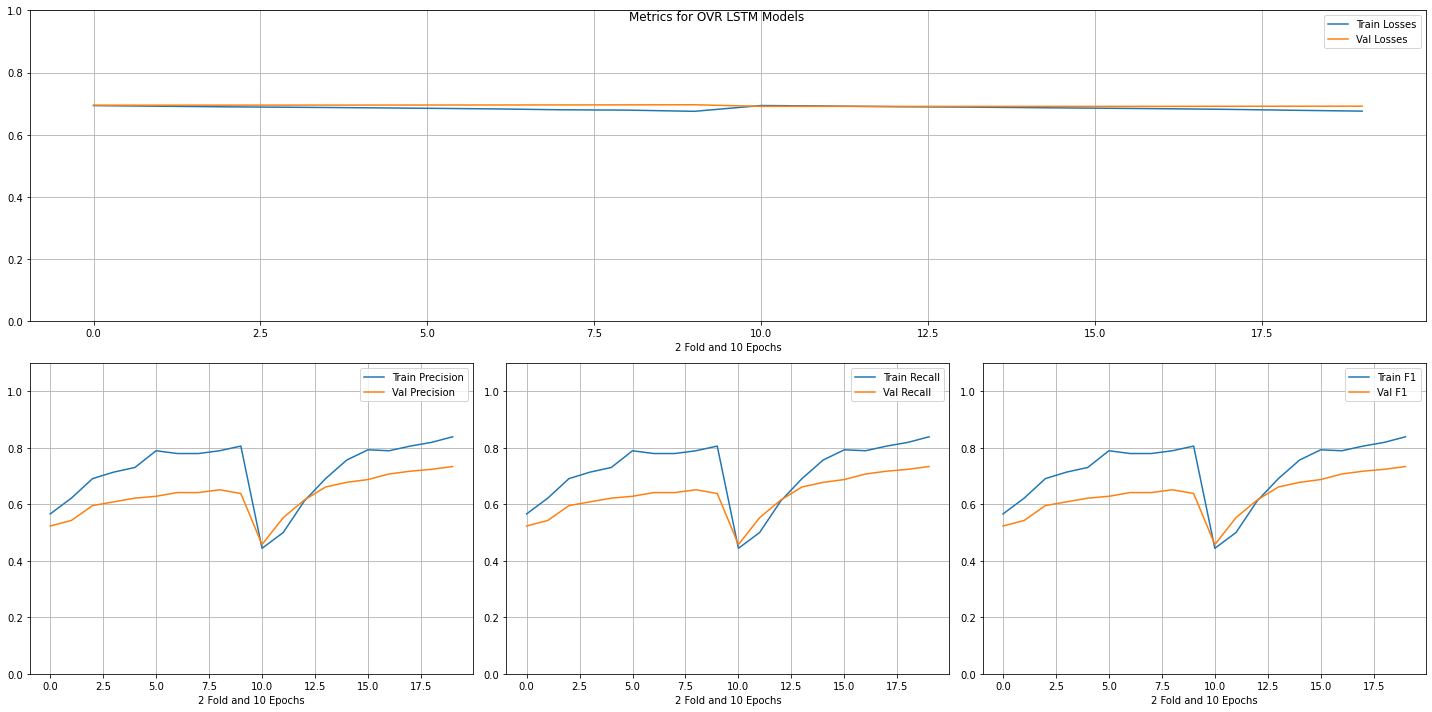

   train_f1  validation_f1  ...  train_losses  validation_losses
9  0.838816       0.733553  ...      0.675910           0.691874
8  0.819079       0.723684  ...      0.678596           0.691671
7  0.805921       0.717105  ...      0.681552           0.691493
6  0.789474       0.707237  ...      0.683740           0.691303
5  0.792763       0.687500  ...      0.685433           0.691183
4  0.756579       0.677632  ...      0.687189           0.691155
3  0.690789       0.661184  ...      0.688973           0.691147
8  0.789474       0.651316  ...      0.679104           0.696118
6  0.779605       0.641447  ...      0.683105           0.695689
7  0.779605       0.641447  ...      0.680257           0.695846
9  0.805921       0.638158  ...      0.675303           0.696435
5  0.789474       0.628289  ...      0.685007           0.695536
4  0.730263       0.621711  ...      0.686792           0.695382
2  0.611842       0.615132  ...      0.690160           0.691199
3  0.713816       0.60855

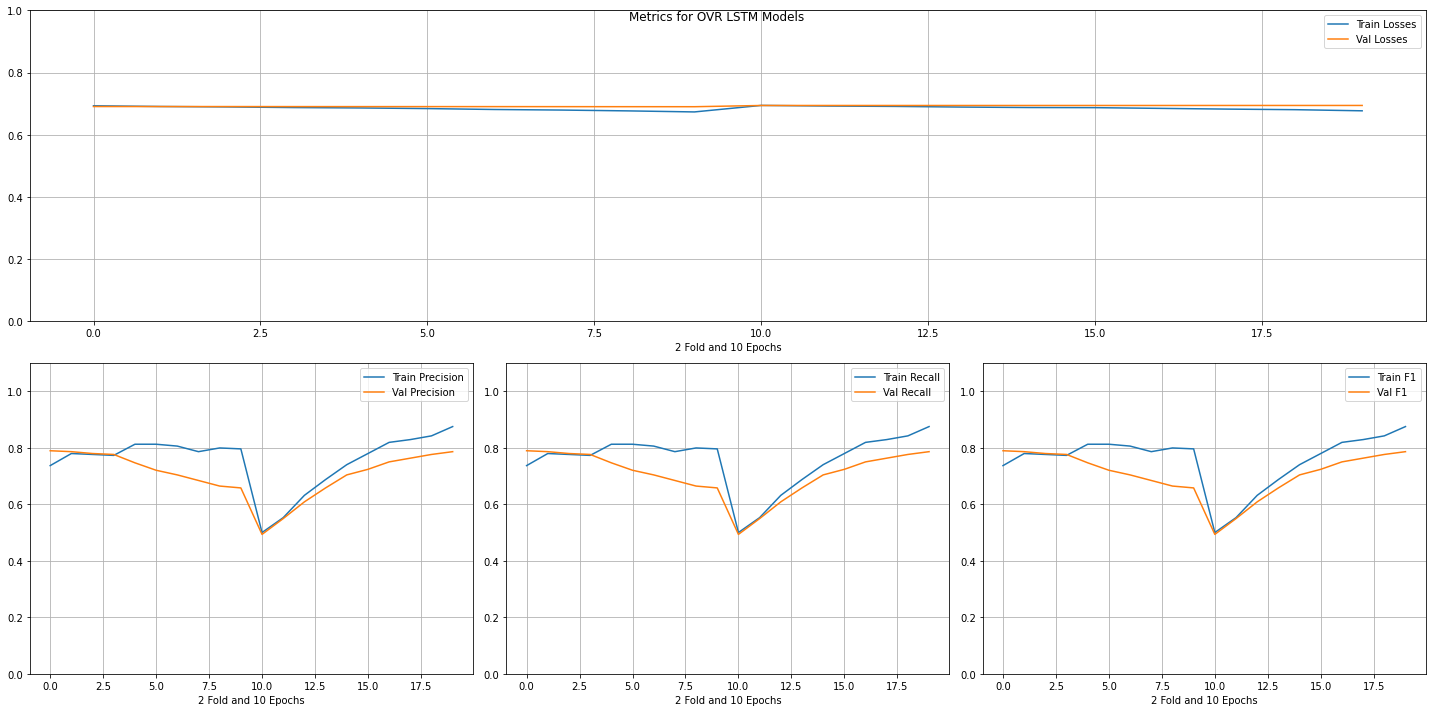

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.736842       0.789474  ...      0.693127           0.690675
1  0.779605       0.786184  ...      0.690809           0.690652
9  0.875000       0.786184  ...      0.676929           0.694158
2  0.776316       0.779605  ...      0.689479           0.690591
3  0.773026       0.776316  ...      0.687384           0.690492
8  0.842105       0.776316  ...      0.680571           0.694168
7  0.828947       0.763158  ...      0.682361           0.694128
6  0.819079       0.750000  ...      0.684711           0.694095
4  0.812500       0.746711  ...      0.686117           0.690464
5  0.779605       0.723684  ...      0.687073           0.694085
5  0.812500       0.720395  ...      0.684108           0.690470
6  0.805921       0.703947  ...      0.681172           0.690428
4  0.740132       0.703947  ...      0.687500           0.694078
7  0.786184       0.684211  ...      0.679367           0.690328
8  0.799342       0.66447

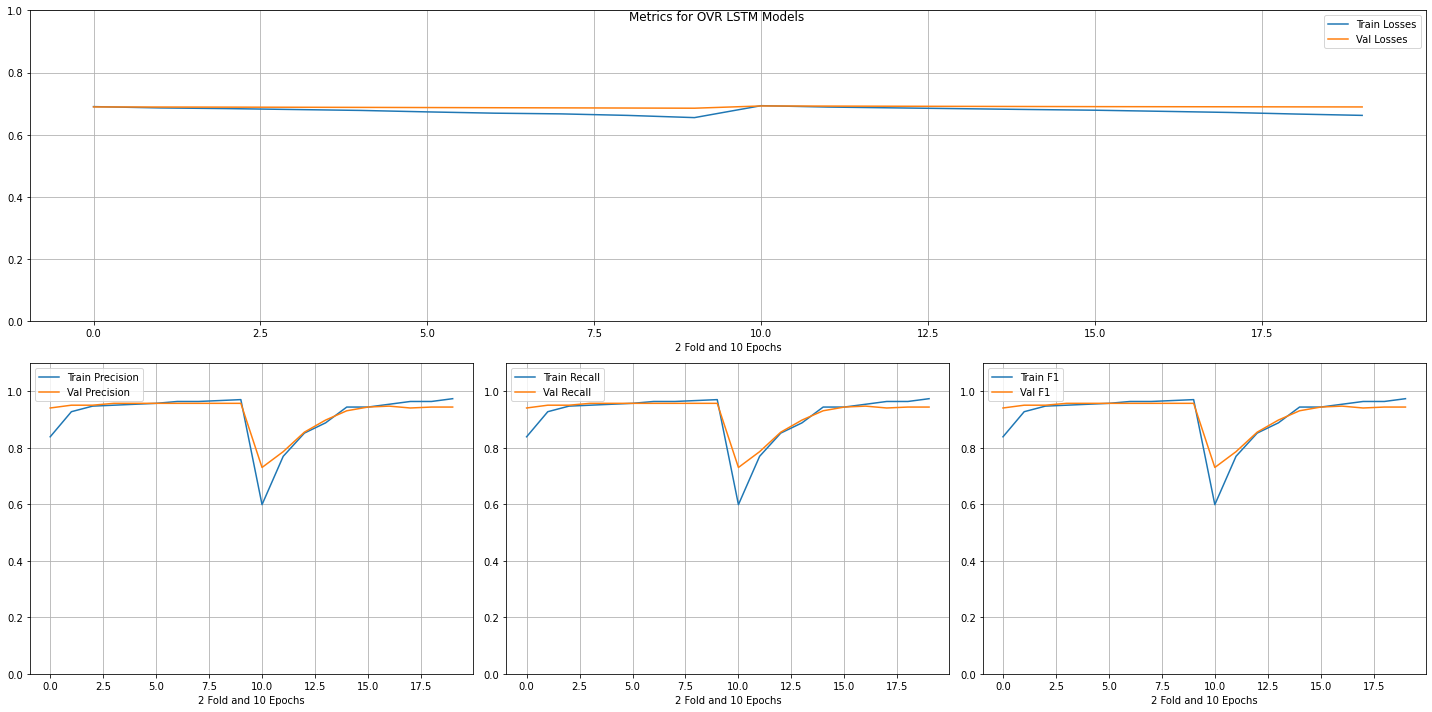

   train_f1  validation_f1  ...  train_losses  validation_losses
3  0.950658       0.957237  ...      0.681107           0.688391
4  0.953947       0.957237  ...      0.678177           0.687954
5  0.957237       0.957237  ...      0.673452           0.687415
6  0.963816       0.957237  ...      0.669329           0.686881
7  0.963816       0.957237  ...      0.667058           0.686391
8  0.967105       0.957237  ...      0.662166           0.685882
9  0.970395       0.957237  ...      0.655033           0.685309
2  0.947368       0.950658  ...      0.684075           0.688752
1  0.927632       0.950658  ...      0.686230           0.689094
6  0.953947       0.947368  ...      0.675286           0.690105
9  0.973684       0.944079  ...      0.662225           0.689369
5  0.944079       0.944079  ...      0.678845           0.690382
8  0.963816       0.944079  ...      0.666590           0.689604
7  0.963816       0.940789  ...      0.671678           0.689897
0  0.838816       0.94078

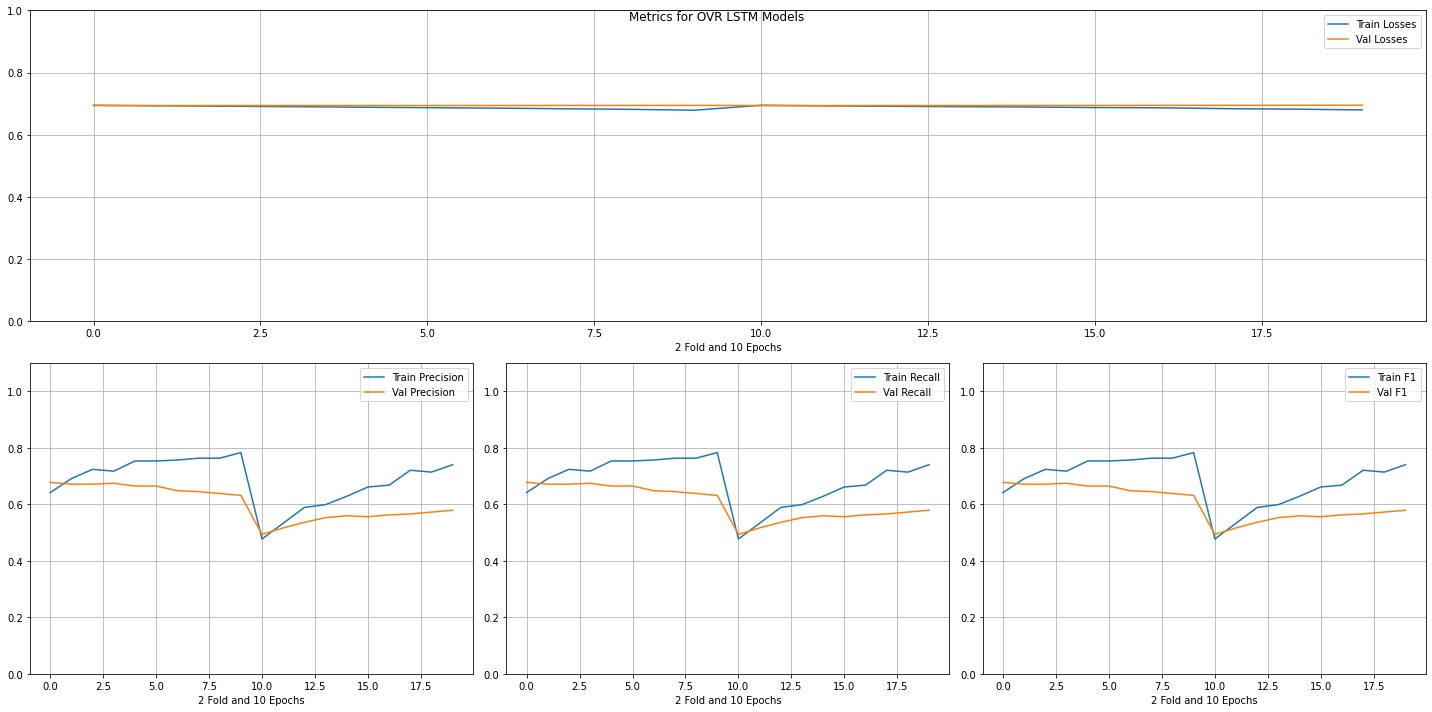

   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.641447       0.677632  ...      0.694781           0.693747
3  0.717105       0.674342  ...      0.690251           0.693850
1  0.690789       0.671053  ...      0.692915           0.693797
2  0.723684       0.671053  ...      0.691575           0.693838
4  0.753289       0.664474  ...      0.688558           0.693866
5  0.753289       0.664474  ...      0.687058           0.693896
6  0.756579       0.648026  ...      0.685559           0.693971
7  0.763158       0.644737  ...      0.683604           0.694044
8  0.763158       0.638158  ...      0.681809           0.694187
9  0.782895       0.631579  ...      0.678819           0.694375
9  0.740132       0.578947  ...      0.679779           0.695022
8  0.713816       0.572368  ...      0.682238           0.694733
7  0.720395       0.565789  ...      0.683784           0.694517
6  0.667763       0.562500  ...      0.686545           0.694324
4  0.628289       0.55921

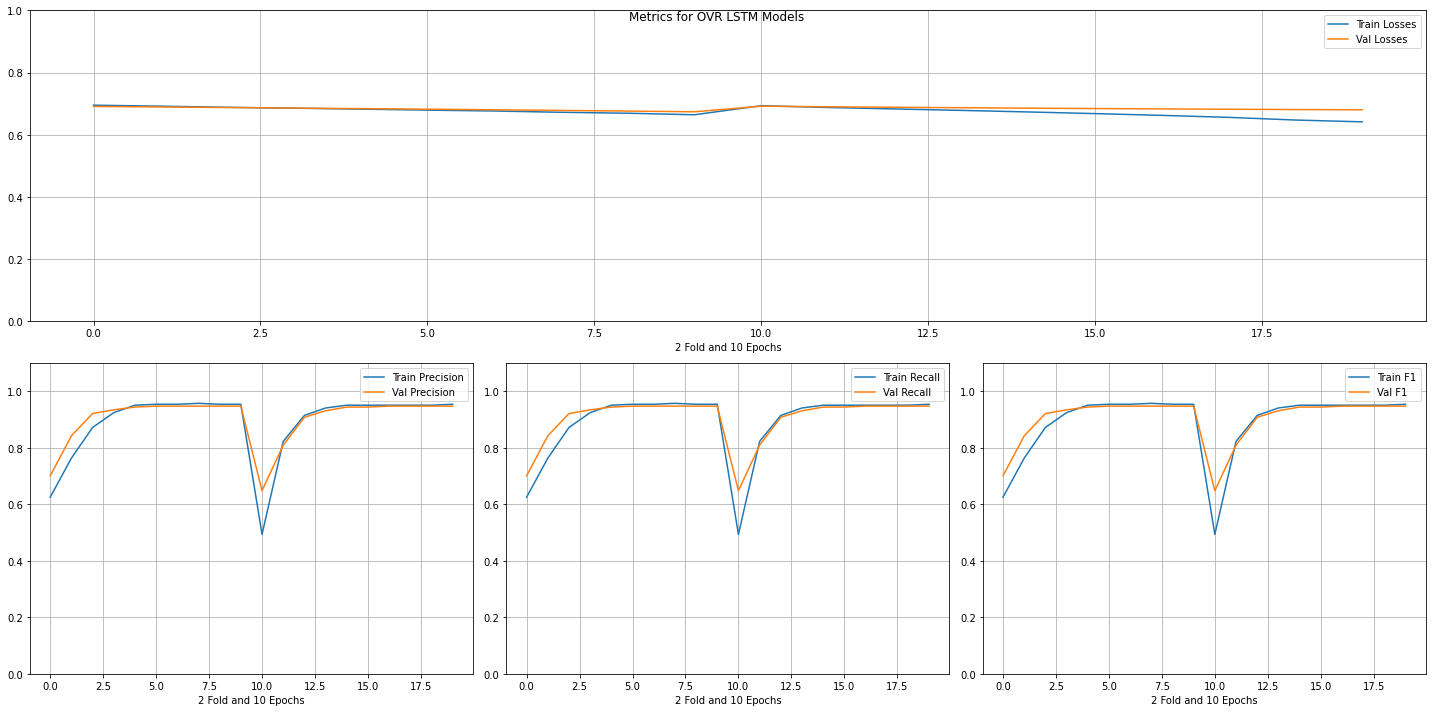

   train_f1  validation_f1  ...  train_losses  validation_losses
9  0.953947       0.947368  ...      0.641453           0.680205
6  0.953947       0.947368  ...      0.676328           0.680245
6  0.950658       0.947368  ...      0.662283           0.683030
8  0.950658       0.947368  ...      0.647248           0.681006
8  0.953947       0.947368  ...      0.669167           0.676050
7  0.957237       0.947368  ...      0.672175           0.678194
9  0.953947       0.947368  ...      0.664266           0.673872
5  0.953947       0.947368  ...      0.679125           0.682145
7  0.950658       0.947368  ...      0.655838           0.681984
4  0.950658       0.944079  ...      0.682351           0.683927
4  0.950658       0.944079  ...      0.673238           0.685469
5  0.950658       0.944079  ...      0.667911           0.684182
3  0.924342       0.934211  ...      0.685369           0.685739
3  0.940789       0.930921  ...      0.678243           0.686870
2  0.871711       0.92105

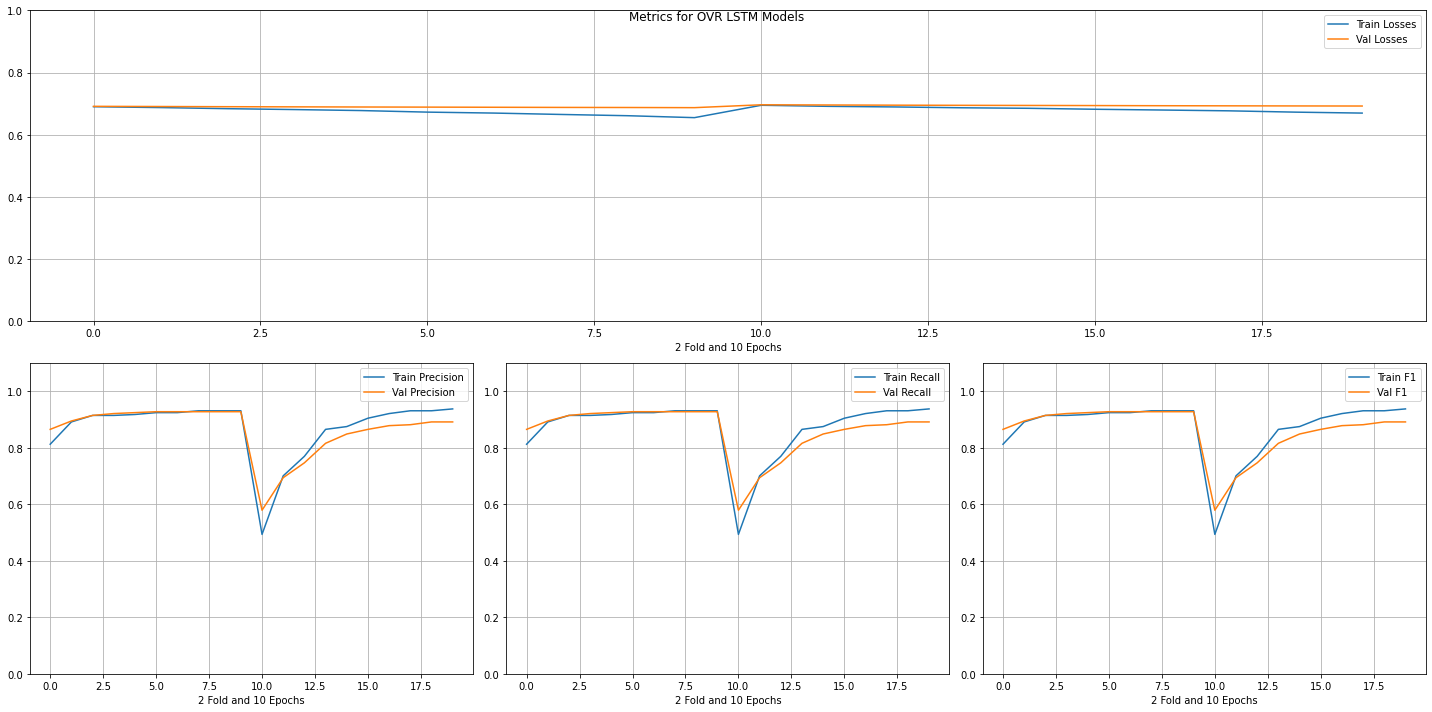

   train_f1  validation_f1  ...  train_losses  validation_losses
5  0.924342       0.927632  ...      0.672706           0.688799
6  0.924342       0.927632  ...      0.669632           0.688337
7  0.930921       0.927632  ...      0.665224           0.687857
8  0.930921       0.927632  ...      0.661164           0.687575
9  0.930921       0.927632  ...      0.654936           0.687083
4  0.917763       0.924342  ...      0.677763           0.689195
3  0.914474       0.921053  ...      0.680969           0.689684
2  0.914474       0.914474  ...      0.683808           0.690144
1  0.891447       0.894737  ...      0.687358           0.690751
9  0.937500       0.891447  ...      0.669609           0.692328
8  0.930921       0.891447  ...      0.672643           0.692626
7  0.930921       0.881579  ...      0.676883           0.692965
6  0.921053       0.878289  ...      0.679461           0.693328
5  0.904605       0.865132  ...      0.681919           0.693803
0  0.812500       0.86513

In [76]:
jovr_res_reduced = ovr_train_model_lstm(rdata, MfccMatrixJanakaRagaDataset, MfccLstmModel, "OVR LSTM Models", jlabels1, cl, lbl_encoder=jle, target='JanakaRagamCode')

In [77]:
for k in jovr_res_reduced:
  print(jle.inverse_transform([k]))
  print(results_to_df(jovr_res_reduced[k]).head())

['Chalanata']
   train_f1  validation_f1  ...  train_losses  validation_losses
2  0.950658       0.960526  ...      0.686350           0.686059
3  0.953947       0.960526  ...      0.683601           0.684904
4  0.953947       0.960526  ...      0.680440           0.683938
5  0.957237       0.960526  ...      0.677439           0.683004
6  0.953947       0.960526  ...      0.674729           0.682059

[5 rows x 8 columns]
['Hanumatodi']
   train_f1  validation_f1  ...  train_losses  validation_losses
9  0.980263       0.967105  ...      0.644917           0.672789
2  0.967105       0.967105  ...      0.680032           0.687471
3  0.967105       0.967105  ...      0.675979           0.686052
4  0.967105       0.967105  ...      0.671462           0.684642
5  0.967105       0.967105  ...      0.667025           0.683107

[5 rows x 8 columns]
['Harikambhoji']
   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.822368       0.815789  ...      0.692691           0.693677
